In [3]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import solve, block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics_new import a_grav, da_grav_dp_vec, d2a_grav_dp_vec_dp_vecT, a_J2, da_J2_dp_vec, d2a_J2_dp_vec_dp_vecT, a_drag, da_drag_dp_vec, da_drag_dv_vec, d2a_drag_dp_vec_dp_vecT, d2a_drag_dp_vec_dv_vecT, d2a_drag_dv_vec_dp_vecT, d2a_drag_dv_vec_dv_vecT
from utils import get_form_initial_conditions

In [4]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
H = 30 # Window size [min]
invalid_rmse = 1e20 # [m]

In [5]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [6]:
def diff_eq(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        v_vec_i = x_vec_i[n_p : n_x] 
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec_i, a_grav(x_vec_i)))# + a_J2(x_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def Ddiff_eq(x_vec):
    first_order_der = np.zeros((n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + n_p : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = da_grav_dp_vec(x_vec_i)# + da_J2_dp_vec(x_vec_i) + da_drag_dp_vec(x_vec_i)
        # first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def Hdiff_eq(x_vec):
    second_order_der = np.zeros((n, n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))# + d2a_J2_dp_vec_dp_vecT(x_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        # aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        # aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        # aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux_pp[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j + n_p] = aux_pv[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j] = aux_vp[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j + n_p] = aux_vv[:, :, j]
    return second_order_der.reshape((n * n, n))

def diff_eq(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        v_vec_i = x_vec_i[n_p : n_x] 
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec_i, a_grav(x_vec_i) + a_J2(x_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def Ddiff_eq(x_vec):
    first_order_der = np.zeros((n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + n_p : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = da_grav_dp_vec(x_vec_i) + da_J2_dp_vec(x_vec_i) + da_drag_dp_vec(x_vec_i)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def Hdiff_eq(x_vec):
    second_order_der = np.zeros((n, n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(x_vec_i) + d2a_J2_dp_vec_dp_vecT(x_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux_pp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j + n_p] = aux_pv[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j] = aux_vp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j + n_p] = aux_vv[:, :, j]
    return second_order_der.reshape((n * n, n))

def f(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)
    k4 = diff_eq(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = Ddiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = Hdiff_eq(x_old)
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ Hdiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(Ddiff_eq(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ Hdiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(Ddiff_eq(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ Hdiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(Ddiff_eq(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [7]:
def h(x_vec):
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    distances = [np.linalg.norm(p_vecs[j] - p_vecs[i]) for (i, j) in [(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)]]
    return np.concatenate((p_vecs[0], np.array(distances).reshape(-1, 1)))

def Dh(x_vec):
    first_order_der = np.zeros((o, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    
    first_order_der[:n_p, :n_p] = np.eye(n_p)
    
    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        first_order_der[k, i * n_x : i * n_x + n_p] = -d.T / norm_d
        first_order_der[k, j * n_x : j * n_x + n_p] = d.T / norm_d
    
    return first_order_der

def Hh(x_vec):
    second_order_der = np.zeros((o, n, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]

    def hessian_distance(d, norm_d):
        I = np.eye(n_p)
        return -(I / norm_d - np.outer(d, d) / norm_d**3)

    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        hess_d = hessian_distance(d, norm_d)
        
        second_order_der[k, i * n_x : i * n_x + n_p, i * n_x : i * n_x + n_p] = -hess_d
        second_order_der[k, i * n_x : i * n_x + n_p, j * n_x : j * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, i * n_x : i * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, j * n_x : j * n_x + n_p] = -hess_d
    
    return second_order_der.reshape((o * n, n))

In [8]:
def J_tau(tau, dt, y, x_vec):
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec))

def DJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return -STM.T @ Dh(x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def HJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    
    Df_x = STM
    Hf_x = DSTM    
    h_x = h(x_vec)
    Dh_x = Dh(x_vec)
    Hh_x = Hh(x_vec)
    R_inv = np.linalg.inv(R)
    return - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x

In [9]:
def J(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    J_x = 0
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        J_x += 1 / 2 * (y - h_x).T @ R_inv @ (y - h_x)
        x_vec = f(dt, x_vec)
    return J_x

def DJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DJ_x = np.zeros((n, 1))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        DJ_x += -STM.T @ Dh(x_vec).T @ R_inv @ (y - h(x_vec))
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return DJ_x

def HJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    HJ_x = np.zeros((n, n))
    for tau in range(k - H + 1, k + 1):
        Dh_x = Dh(x_vec)
        Df_x = STM
        HJ_x += Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return HJ_x

In [ ]:
class CentralizedGaussNewton:
    def __init__(self, tolerance=1e-6, max_iter=20):
        self.grad_tol = tolerance
        self.max_iter = max_iter
        self.iterations = None
        
        # Storage for results
        self.cost_values = []
        self.gradient_norm_values = []

    def solve(self, k, dt, Y, x_init, x_true_initial, x_true_end):
        x = x_init.copy()

        prev_cost_value = None
        prev_gradient_norm_value = None
        prev_global_estimation_error = None
        grad_norm_order_history = []

        for iteration in range(self.max_iter + 1):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            J_x = J(k, dt, Y, x)
            DJ_x = DJ(k, dt, Y, x)
            HJ_x = HJ(k, dt, Y, x)

            # Convergence tracking
            cost_value = J_x[0][0]
            gradient_norm_value = np.linalg.norm(DJ_x)

            # Store the values
            self.cost_values.append(cost_value)
            self.gradient_norm_values.append(gradient_norm_value)

            # Metrics
            if prev_cost_value is not None:
                cost_value_change = (cost_value - prev_cost_value) / abs(prev_cost_value) * 100
                gradient_norm_value_change = (gradient_norm_value - prev_gradient_norm_value) / abs(prev_gradient_norm_value) * 100
                global_estimation_error_change = (np.linalg.norm(x - x_true_initial) - prev_global_estimation_error) / abs(prev_global_estimation_error) * 100
            prev_cost_value = cost_value
            prev_gradient_norm_value = gradient_norm_value
            prev_global_estimation_error = np.linalg.norm(x - x_true_initial)
            
            # Track gradient norm order of magnitude
            current_order = int(np.floor(np.log10(gradient_norm_value + 1e-12)))  # avoid log(0)
            grad_norm_order_history.append(current_order)

            if len(grad_norm_order_history) >= 3:
                if grad_norm_order_history[-1] == grad_norm_order_history[-2] == grad_norm_order_history[-3]:
                    stagnant_order = True
                    if k == H - 1:
                        stagnant_order = False
                else:
                    stagnant_order = False
            else:
                stagnant_order = False
            
            # Propagate window initial conditions for metrics 
            x_end = x.copy()
            for _ in range(H - 1):
                x_end = f(dt, x_end)

            # Check convergence and print metrics
            if gradient_norm_value < self.grad_tol or iteration == self.max_iter or stagnant_order:
                reason = "tolerance reached" if gradient_norm_value < self.grad_tol else \
                        "max iteration reached" if iteration == self.max_iter else \
                        "gradient norm stagnated"
                print(f"STOP on Iteration {iteration} ({reason})")
                print(f"Cost function = {cost_value} ({cost_value_change:.2f}%)\nGradient norm = {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error = {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)")
                print(f"Final initial conditions estimation errors: {np.linalg.norm(x[:n_p, :] - x_true_initial[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true_initial[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true_initial[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true_initial[3 * n_x : 3 * n_x + n_p, :])} m")
                print(f"Final position estimation errors: {np.linalg.norm(x_end[:n_p, :] - x_true_end[:n_p, :])} m, {np.linalg.norm(x_end[n_x : n_x + n_p, :] - x_true_end[n_x : n_x + n_p, :])} m, {np.linalg.norm(x_end[2 * n_x : 2 * n_x + n_p, :] - x_true_end[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x_end[3 * n_x : 3 * n_x + n_p, :] - x_true_end[3 * n_x : 3 * n_x + n_p, :])} m\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_value}\nGradient norm: {gradient_norm_value}\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_value} ({cost_value_change:.2f}%)\nGradient norm: {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)")
                    
            # Print estimation errors 
            print(f"Initial conditions estimation errors: {np.linalg.norm(x[:n_p, :] - x_true_initial[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true_initial[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true_initial[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true_initial[3 * n_x : 3 * n_x + n_p, :])} m")
            print(f"Position estimation errors: {np.linalg.norm(x_end[:n_p, :] - x_true_end[:n_p, :])} m, {np.linalg.norm(x_end[n_x : n_x + n_p, :] - x_true_end[n_x : n_x + n_p, :])} m, {np.linalg.norm(x_end[2 * n_x : 2 * n_x + n_p, :] - x_true_end[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x_end[3 * n_x : 3 * n_x + n_p, :] - x_true_end[3 * n_x : 3 * n_x + n_p, :])} m\n")
                
            # Solve for the Newton step - this is one iteration
            delta_x = solve(HJ_x, -DJ_x)
            x += delta_x
        
            # Save the current iteration
            self.iterations = iteration + 1
            
        # Propagate window initial conditions getting estimate at timestamp k
        x_init = x
        for _ in range(H - 1):
            x = f(dt, x)

        return x_init, x

In [11]:
def plots(algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function')
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()

    plt.tight_layout()
    plt.show()

In [12]:
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
# X_true = np.zeros((n, 1, K))
# X_true[:, :, 0] = X_initial
# for k in range(K - 1):
#     X_true[:, :, k + 1] = f(dt, X_true[:, :, k])
with open(f"tudatpy_form{formation}.pkl", "rb") as file:
    X_true = pickle.load(file)

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = f(dt, X_est[:, :, k])
position_estimation_error_1_initial = np.linalg.norm(X_est[:n_p, :, :] - X_true[:n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_2_initial = np.linalg.norm(X_est[n_x:n_x + n_p, :, :] - X_true[n_x:n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_3_initial = np.linalg.norm(X_est[2 * n_x:2 * n_x + n_p, :, :] - X_true[2 * n_x:2 * n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_4_initial = np.linalg.norm(X_est[3 * n_x:3 * n_x + n_p, :, :] - X_true[3 * n_x:3 * n_x + n_p, :, :], axis=0).reshape(-1, 1)

MC run:   0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------ Monte Carlo run #1 ------------------------------------


Before applying the algorithm
Cost function: 301224484.3109193
Gradient norm: 2089042806.881653
Global estimation error: 429.5049051950654
Initial conditions estimation errors: 272.4697073631671 m, 173.20827048056321 m, 227.77973283351287 m, 168.3746081658613 m
Position estimation errors: 779.5967223627993 m, 1207.595181126871 m, 483.10528555259594 m, 358.4329736499271 m

Iteration 1
Cost function: 350557.5641967343 (-99.88%)
Gradient norm: 1147267.7490568669 (-99.95%)
Global estimation error: 158.44172619262454 (-63.11%)
Initial conditions estimation errors: 30.42032651358424 m, 101.59294922491141 m, 99.46006988708285 m, 62.96641630463791 m
Position estimation errors: 23.50478155887902 m, 24.577801596699715 m, 235.61144900452666 m, 245.29489231584398 m

Iteration 2
Cost function: 318961.72525714705 (-9.01%)
Gradient norm: 54352.237610211065 (-95.26%)
Global estimation error: 74.22841607413157 (-53.15%)
Initial conditions estimation errors: 30.419416671864248 m, 36.72406249413467 m, 42

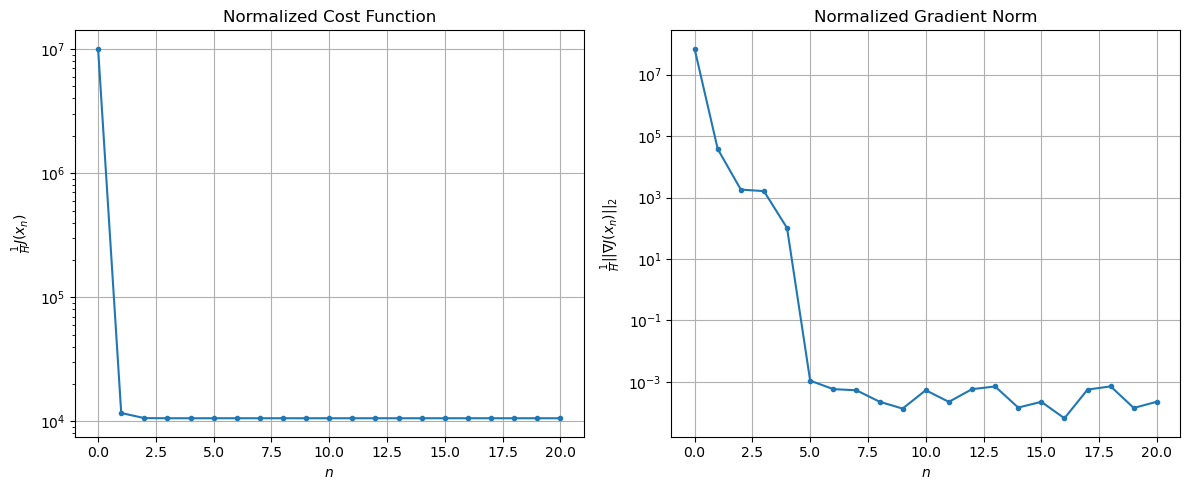

Before applying the algorithm
Cost function: 309964.16644561524
Gradient norm: 2619507.543356482
Global estimation error: 46.84597738429532
Initial conditions estimation errors: 23.648418714529804 m, 23.039027345568595 m, 23.70257038523605 m, 23.294120767535492 m
Position estimation errors: 27.389453155081117 m, 30.263269231694835 m, 26.475702665402384 m, 26.720068178341045 m

Iteration 1
Cost function: 295681.95050130587 (-4.61%)
Gradient norm: 41.982610592806374 (-100.00%)
Global estimation error: 56.76147634297661 (21.17%)
Initial conditions estimation errors: 29.01017404832239 m, 28.551380607351085 m, 27.781154648089593 m, 28.164167927189197 m
Position estimation errors: 23.437314185337023 m, 26.41872452006471 m, 22.603377142698424 m, 22.918837090563013 m

Iteration 2
Cost function: 295681.950208231 (-0.00%)
Gradient norm: 0.012944517217671373 (-99.97%)
Global estimation error: 56.75283722095691 (-0.02%)
Initial conditions estimation errors: 29.01017538967673 m, 28.55142957794465 m

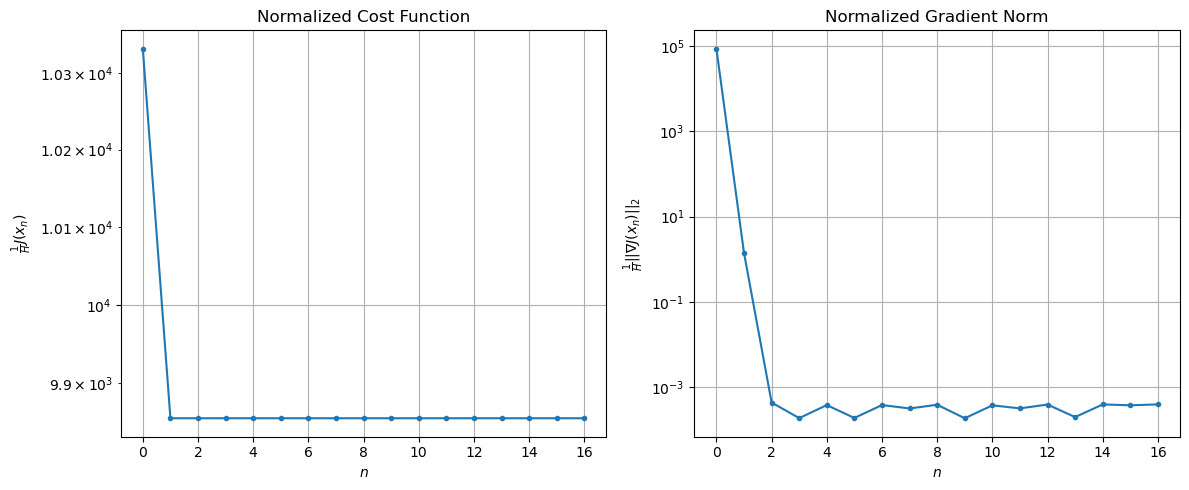

Before applying the algorithm
Cost function: 290767.8829257543
Gradient norm: 2592936.7163668624
Global estimation error: 43.57960403855055
Initial conditions estimation errors: 22.780431000526555 m, 22.228422301640922 m, 21.325305142956775 m, 20.767779765368715 m
Position estimation errors: 27.202711898313687 m, 30.143067277760757 m, 26.494575887479314 m, 26.99639096680383 m

Iteration 1
Cost function: 277310.3144810393 (-4.63%)
Gradient norm: 60.2938387082554 (-100.00%)
Global estimation error: 57.675760763650324 (32.35%)
Initial conditions estimation errors: 27.82146348669796 m, 27.936370953327852 m, 29.442635680989465 m, 30.084578777586078 m
Position estimation errors: 23.14460472203588 m, 25.35150742762253 m, 21.38240650781155 m, 21.5704086925738 m

Iteration 2
Cost function: 277310.3134543405 (-0.00%)
Gradient norm: 0.038143283166588625 (-99.94%)
Global estimation error: 57.60150149619816 (-0.13%)
Initial conditions estimation errors: 27.821464836651156 m, 27.93960040556531 m, 29

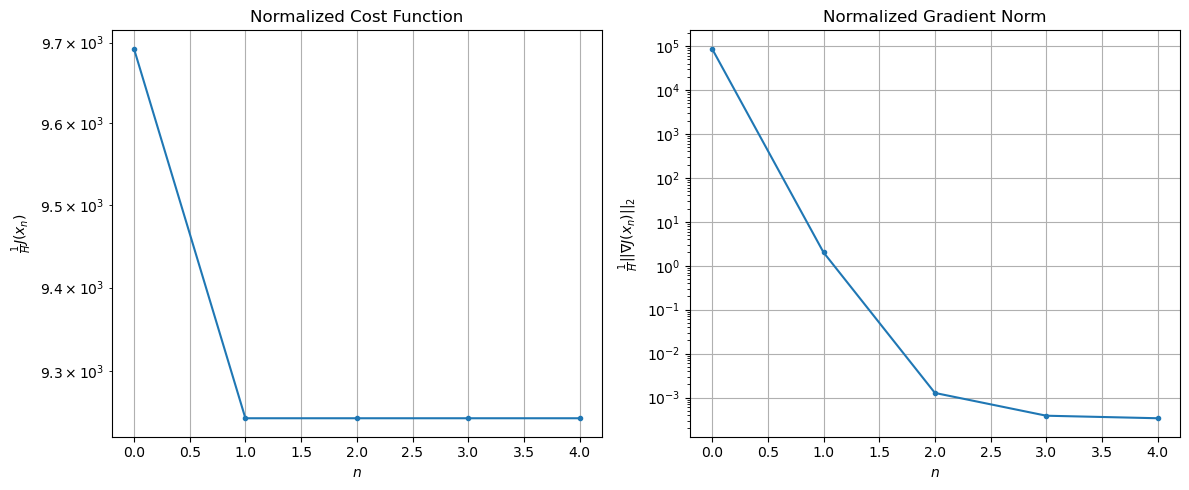

Before applying the algorithm
Cost function: 273824.9925219957
Gradient norm: 2624164.126280992
Global estimation error: 45.59982320310224
Initial conditions estimation errors: 22.086075181978757 m, 22.160451630107268 m, 23.24320017765536 m, 23.667823800922314 m
Position estimation errors: 26.695855072486445 m, 28.833672162718038 m, 24.935729058889056 m, 25.240080373982803 m

Iteration 1
Cost function: 261052.62981817755 (-4.66%)
Gradient norm: 93.69385731971447 (-100.00%)
Global estimation error: 59.48026090112841 (30.44%)
Initial conditions estimation errors: 26.877452099725787 m, 25.64431855697482 m, 33.45403818447172 m, 32.22800185821281 m
Position estimation errors: 22.548514035413515 m, 25.993863202648093 m, 18.205036940111157 m, 17.19514390809145 m

Iteration 2
Cost function: 261052.62560516564 (-0.00%)
Gradient norm: 0.20069706586019903 (-99.79%)
Global estimation error: 59.21184387846428 (-0.45%)
Initial conditions estimation errors: 26.877453331338568 m, 25.660924230421386 m,

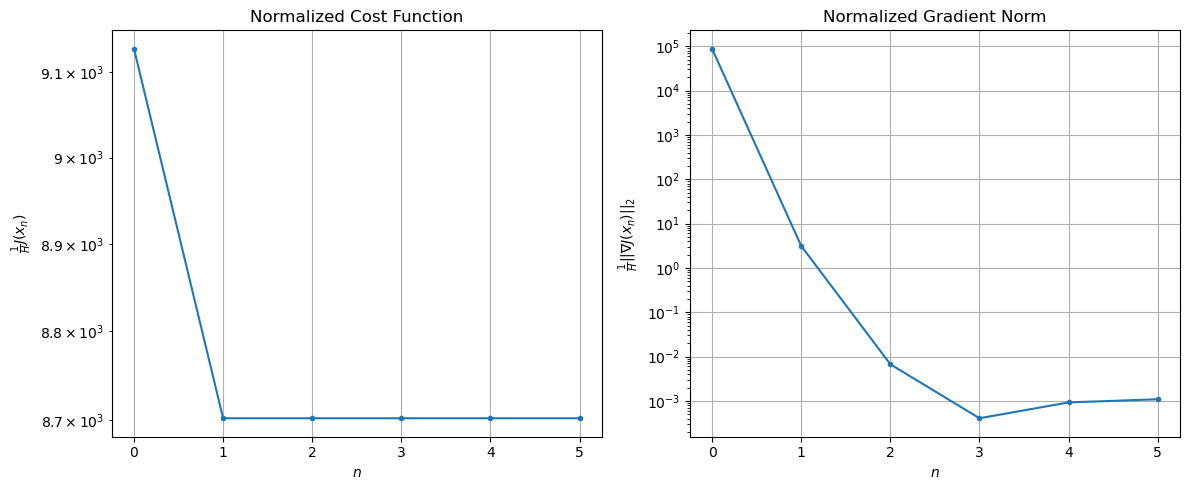

Before applying the algorithm
Cost function: 258016.21380929113
Gradient norm: 2726644.1719828807
Global estimation error: 48.33950486432928
Initial conditions estimation errors: 21.56797741254245 m, 20.300209861630993 m, 27.170584199904734 m, 26.85420350465375 m
Position estimation errors: 25.810101224413092 m, 29.371987380446868 m, 21.464910928744498 m, 20.467906774152514 m

Iteration 1
Cost function: 246112.46407919272 (-4.61%)
Gradient norm: 21.49626398861079 (-100.00%)
Global estimation error: 59.022294652519605 (22.10%)
Initial conditions estimation errors: 26.11667171882509 m, 25.653098604163535 m, 32.33930398581165 m, 33.12993139250157 m
Position estimation errors: 21.662429452588167 m, 24.364889413369266 m, 17.569288531009185 m, 17.229160406281657 m

Iteration 2
Cost function: 246112.4640378435 (-0.00%)
Gradient norm: 0.013970280912950642 (-99.94%)
Global estimation error: 59.00295334087042 (-0.03%)
Initial conditions estimation errors: 26.11667277302745 m, 25.65327431896791 m

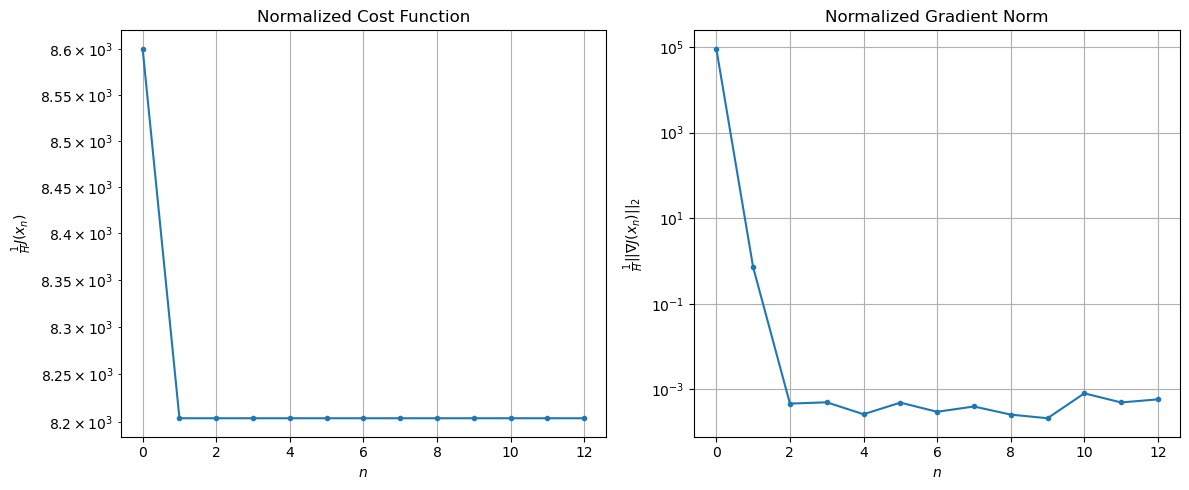

Before applying the algorithm
Cost function: 242488.87085115493
Gradient norm: 2869612.8779729875
Global estimation error: 48.87021241744416
Initial conditions estimation errors: 21.139323937689788 m, 20.746580041933935 m, 26.907618542059414 m, 28.05263006229098 m
Position estimation errors: 24.582739540873373 m, 27.465426950038356 m, 20.531015922773836 m, 19.91620625985408 m

Iteration 1
Cost function: 231381.77100415213 (-4.58%)
Gradient norm: 129.26021755908144 (-100.00%)
Global estimation error: 52.44918062436864 (7.32%)
Initial conditions estimation errors: 25.47912673895133 m, 23.207017103024167 m, 29.263017157511428 m, 26.585756084840952 m
Position estimation errors: 20.467517788059958 m, 25.078278498103383 m, 16.057302640624016 m, 15.427533789954857 m

Iteration 2
Cost function: 231381.7687932506 (-0.00%)
Gradient norm: 0.02702135617149824 (-99.98%)
Global estimation error: 52.39418722887992 (-0.10%)
Initial conditions estimation errors: 25.47912759610313 m, 23.22396070307774 m

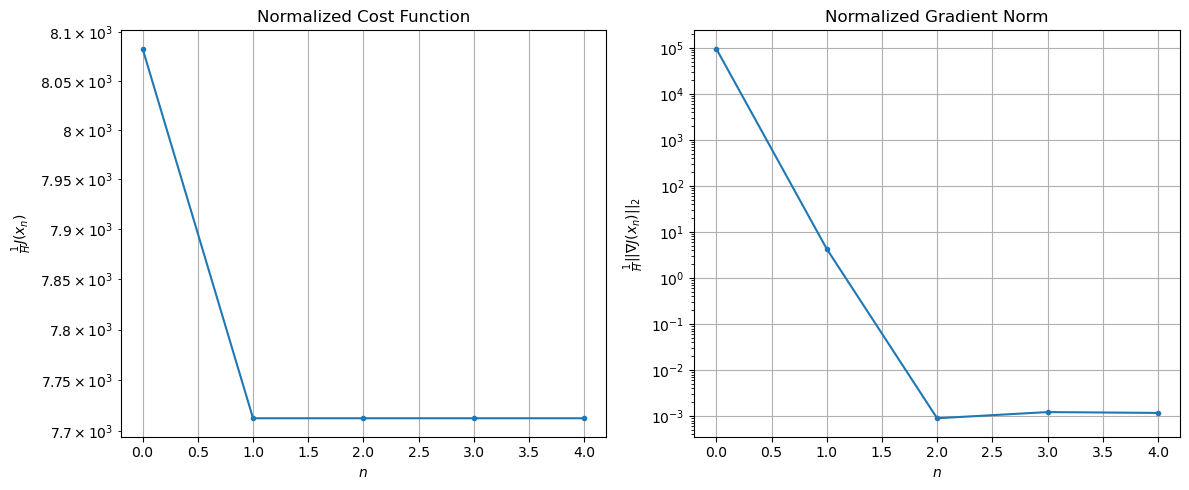

Before applying the algorithm
Cost function: 225795.9768788454
Gradient norm: 2992342.050287985
Global estimation error: 42.9079669825198
Initial conditions estimation errors: 20.742018709874905 m, 18.620193148495392 m, 23.733692862916655 m, 22.379268149932628 m
Position estimation errors: 23.0201329541734 m, 27.7934487084593 m, 19.025832377107427 m, 17.944405468990805 m

Iteration 1
Cost function: 215523.90014070895 (-4.55%)
Gradient norm: 84.93786564522598 (-100.00%)
Global estimation error: 48.87067964003997 (13.90%)
Initial conditions estimation errors: 24.88190449135516 m, 23.408987515568832 m, 26.131709121084423 m, 23.202451609785534 m
Position estimation errors: 18.990576214896873 m, 22.928094906339226 m, 18.493151979153495 m, 18.58138830430325 m

Iteration 2
Cost function: 215523.89995808573 (-0.00%)
Gradient norm: 0.018006398179883264 (-99.98%)
Global estimation error: 48.85569549539203 (-0.03%)
Initial conditions estimation errors: 24.881905161328426 m, 23.414310046696475 m, 

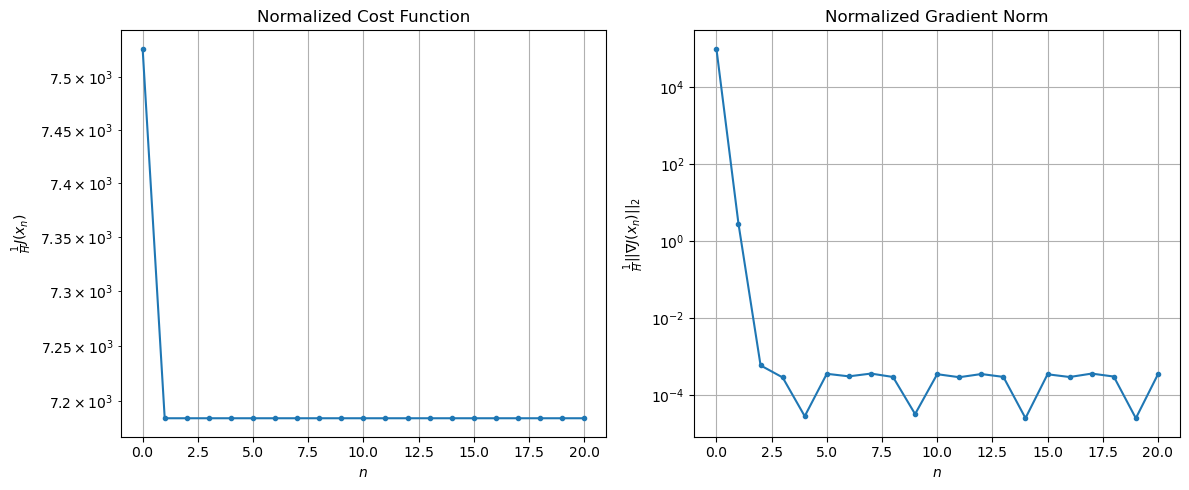

Before applying the algorithm
Cost function: 207015.53068370503
Gradient norm: 3180298.5025982154
Global estimation error: 39.45994330395797
Initial conditions estimation errors: 20.309076707455603 m, 19.00723764237216 m, 20.933179721662036 m, 18.577622406864855 m
Position estimation errors: 21.192277270936092 m, 25.24943121537965 m, 21.097782084164113 m, 20.959610336491405 m

Iteration 1
Cost function: 197686.20281604872 (-4.51%)
Gradient norm: 192.36185304855317 (-99.99%)
Global estimation error: 41.71097005116698 (5.70%)
Initial conditions estimation errors: 24.23653008052766 m, 22.968314008613845 m, 19.399370139631202 m, 15.763475222818338 m
Position estimation errors: 17.320465586939157 m, 22.289920410059814 m, 15.37976175507631 m, 15.201300110266738 m

Iteration 2
Cost function: 197686.20178043435 (-0.00%)
Gradient norm: 0.012744443808486822 (-99.99%)
Global estimation error: 41.685823561990915 (-0.06%)
Initial conditions estimation errors: 24.236530587823587 m, 22.97163053216584

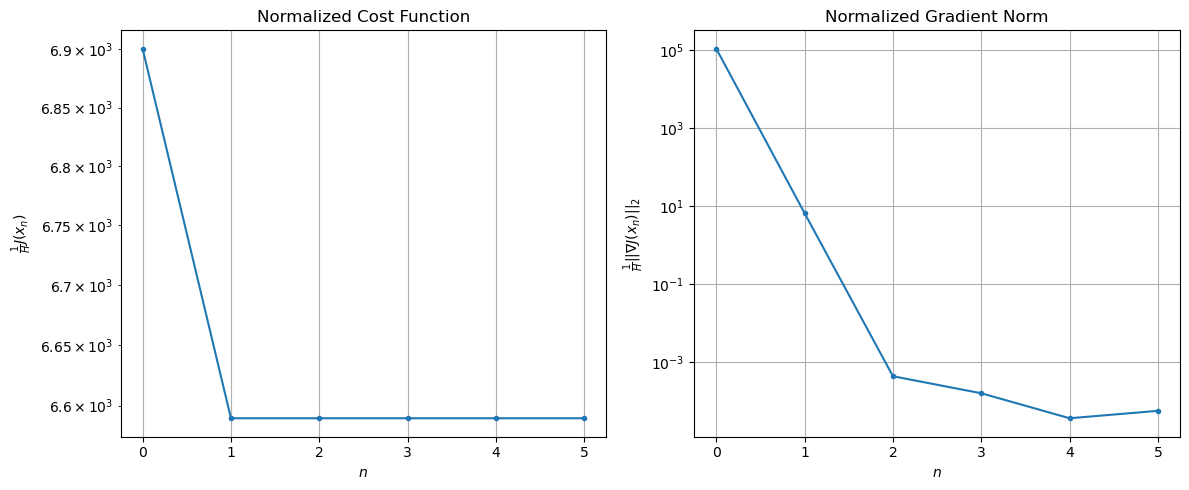

Before applying the algorithm
Cost function: 186655.03934237597
Gradient norm: 3307442.3315747413
Global estimation error: 33.1164477612003
Initial conditions estimation errors: 19.760060121119942 m, 18.765870822426912 m, 14.77145851399123 m, 11.655896652905904 m
Position estimation errors: 19.237661235980564 m, 24.090328380362525 m, 17.96746831396107 m, 17.63366707785048 m

Iteration 1
Cost function: 178471.78039732107 (-4.38%)
Gradient norm: 141.8984994649232 (-100.00%)
Global estimation error: 38.09960050594148 (15.05%)
Initial conditions estimation errors: 23.42208707279009 m, 22.638609152451718 m, 15.706563117385075 m, 11.989769762236756 m
Position estimation errors: 15.60338609079501 m, 21.06922182437184 m, 11.832696285974176 m, 11.485633216329218 m

Iteration 2
Cost function: 178471.78016123845 (-0.00%)
Gradient norm: 0.014353552113358833 (-99.99%)
Global estimation error: 38.089800257632234 (-0.03%)
Initial conditions estimation errors: 23.422087437364844 m, 22.63968861003735 m

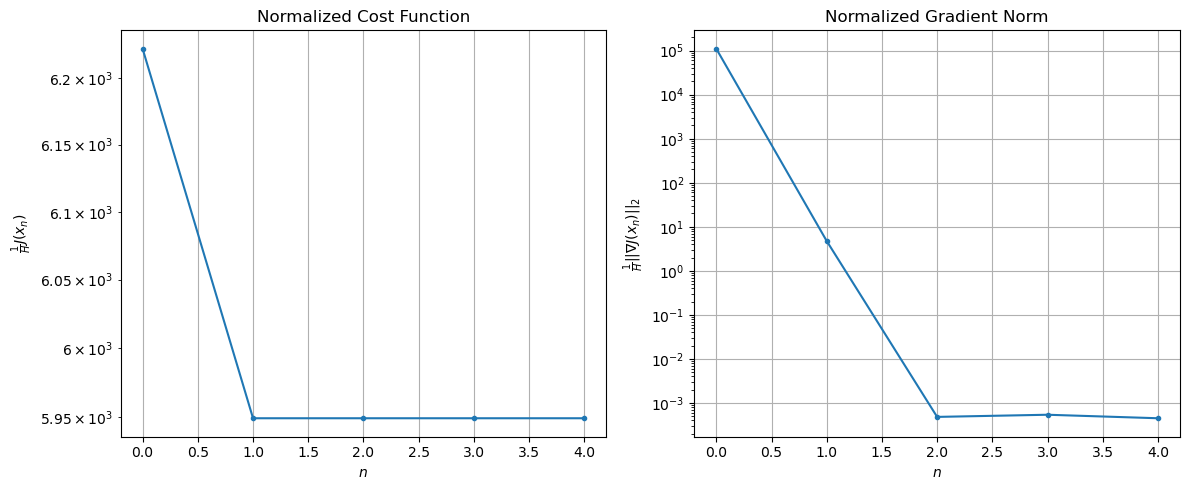

Before applying the algorithm
Cost function: 165956.0100846392
Gradient norm: 3560220.228415081
Global estimation error: 30.42296240029146
Initial conditions estimation errors: 18.988120267365243 m, 18.547060032654727 m, 11.815080046243292 m, 9.021805808720872 m
Position estimation errors: 17.367537804625663 m, 22.514764712103933 m, 14.572495545604419 m, 13.953793344927728 m

Iteration 1
Cost function: 158787.53932738342 (-4.32%)
Gradient norm: 45.03558982173969 (-100.00%)
Global estimation error: 35.971707345125594 (18.24%)
Initial conditions estimation errors: 22.382435827483274 m, 21.74847119816023 m, 13.371852945821884 m, 11.881094340868497 m
Position estimation errors: 13.97781911441051 m, 19.59661658841417 m, 10.591537182876449 m, 10.5113097477014 m

Iteration 2
Cost function: 158787.53918761507 (-0.00%)
Gradient norm: 0.051684982982152204 (-99.89%)
Global estimation error: 35.95282942786886 (-0.05%)
Initial conditions estimation errors: 22.382436086040066 m, 21.746650045647133 m

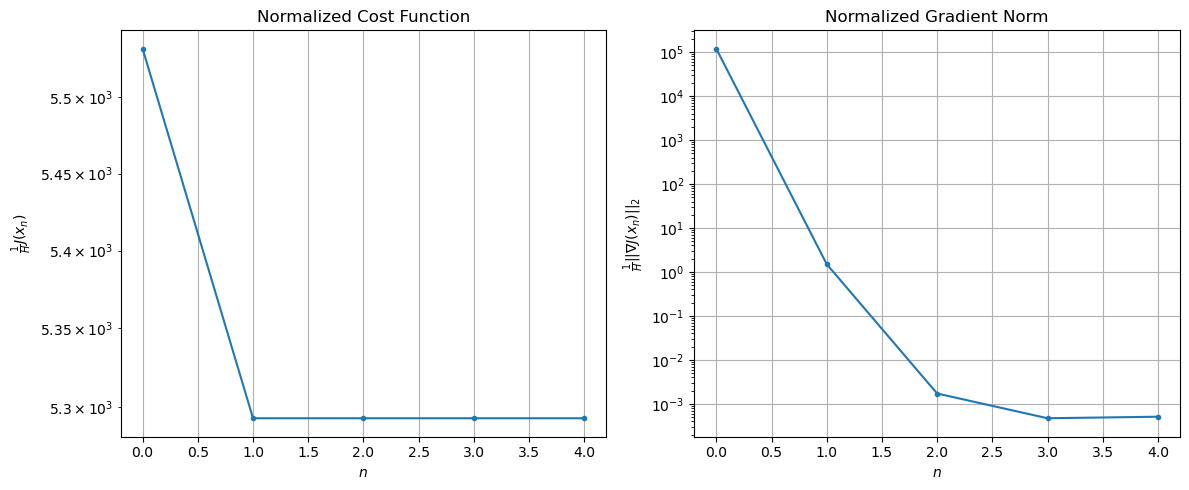

Before applying the algorithm
Cost function: 146311.89505588397
Gradient norm: 3650260.506192277
Global estimation error: 29.71208973042507
Initial conditions estimation errors: 17.96481747798914 m, 17.703479504543036 m, 10.43135539125905 m, 11.739756942402432 m
Position estimation errors: 15.738450098662033 m, 20.9432682729593 m, 13.438614430779078 m, 13.0015082254961 m

Iteration 1
Cost function: 140122.7855762058 (-4.23%)
Gradient norm: 406.20563738361966 (-99.99%)
Global estimation error: 34.6628426816739 (16.66%)
Initial conditions estimation errors: 21.079674584632077 m, 20.124556222291694 m, 14.260419184803206 m, 12.197445010779024 m
Position estimation errors: 12.64047016891408 m, 16.956403645988747 m, 14.802267393926506 m, 14.796859516642465 m

Iteration 2
Cost function: 140122.78442323813 (-0.00%)
Gradient norm: 0.00886891980671805 (-100.00%)
Global estimation error: 34.674969615542835 (0.03%)
Initial conditions estimation errors: 21.07967476121473 m, 20.1218966775405 m, 14.2

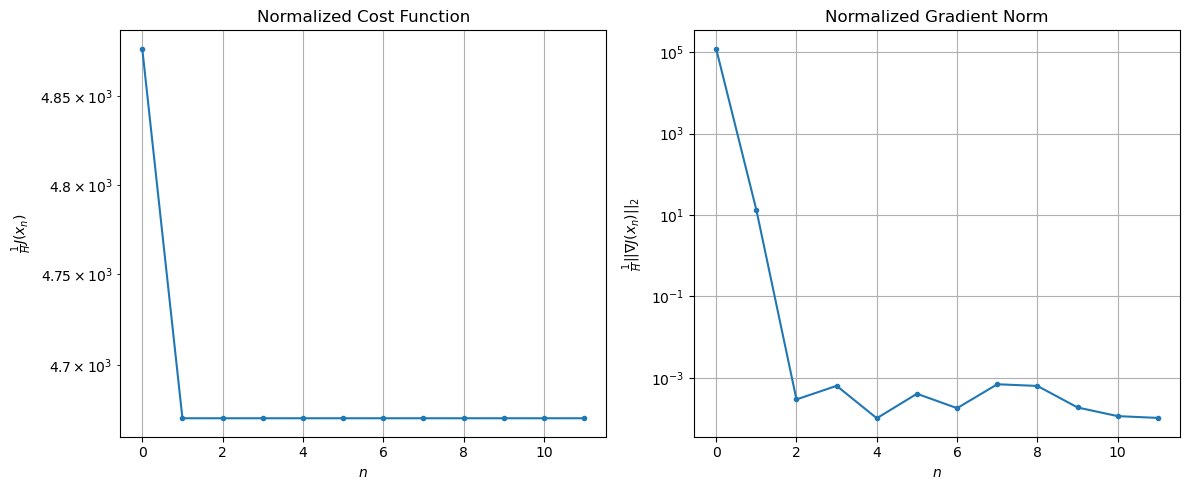

Before applying the algorithm
Cost function: 128086.336998208
Gradient norm: 3775870.621676805
Global estimation error: 27.25553886413182
Initial conditions estimation errors: 16.704860528738795 m, 16.075247632007034 m, 10.000576418697795 m, 10.264712072465953 m
Position estimation errors: 14.523667335942593 m, 18.463079745259833 m, 16.928686038164248 m, 17.021134296003403 m

Iteration 1
Cost function: 122938.20011665054 (-4.02%)
Gradient norm: 681.7767508336259 (-99.98%)
Global estimation error: 34.31133413804566 (25.89%)
Initial conditions estimation errors: 19.496739514143922 m, 19.30234732672609 m, 13.659279750568135 m, 15.42601167526232 m
Position estimation errors: 11.76599202398964 m, 16.861039664894573 m, 11.048030498107082 m, 10.892482338430657 m

Iteration 2
Cost function: 122938.1917492139 (-0.00%)
Gradient norm: 0.022240713160509955 (-100.00%)
Global estimation error: 34.275719406832636 (-0.10%)
Initial conditions estimation errors: 19.496739621134207 m, 19.314113023100653 

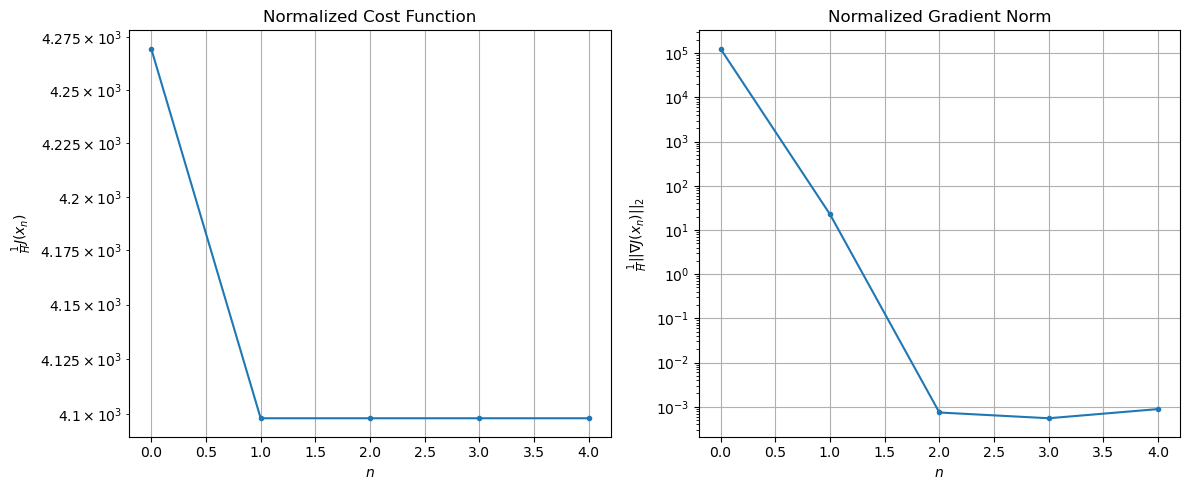

Before applying the algorithm
Cost function: 113278.44888018795
Gradient norm: 3983209.6735212705
Global estimation error: 31.11799991467436
Initial conditions estimation errors: 15.239384546080577 m, 15.49502277161412 m, 12.919206056858872 m, 18.140184257699488 m
Position estimation errors: 13.813258776750915 m, 18.310233865707037 m, 13.935508190909196 m, 13.672467608549162 m

Iteration 1
Cost function: 108919.34434062216 (-3.85%)
Gradient norm: 253.32900272012733 (-99.99%)
Global estimation error: 35.73692136441612 (14.84%)
Initial conditions estimation errors: 17.739796554442687 m, 18.763881366030787 m, 20.743192856650452 m, 13.417765530779876 m
Position estimation errors: 11.328186872454726 m, 15.96027940376586 m, 10.772951928935585 m, 10.97972478219074 m

Iteration 2
Cost function: 108919.34333083412 (-0.00%)
Gradient norm: 0.004083187541289724 (-100.00%)
Global estimation error: 35.749506040975 (0.04%)
Initial conditions estimation errors: 17.739796617513026 m, 18.766493200965733

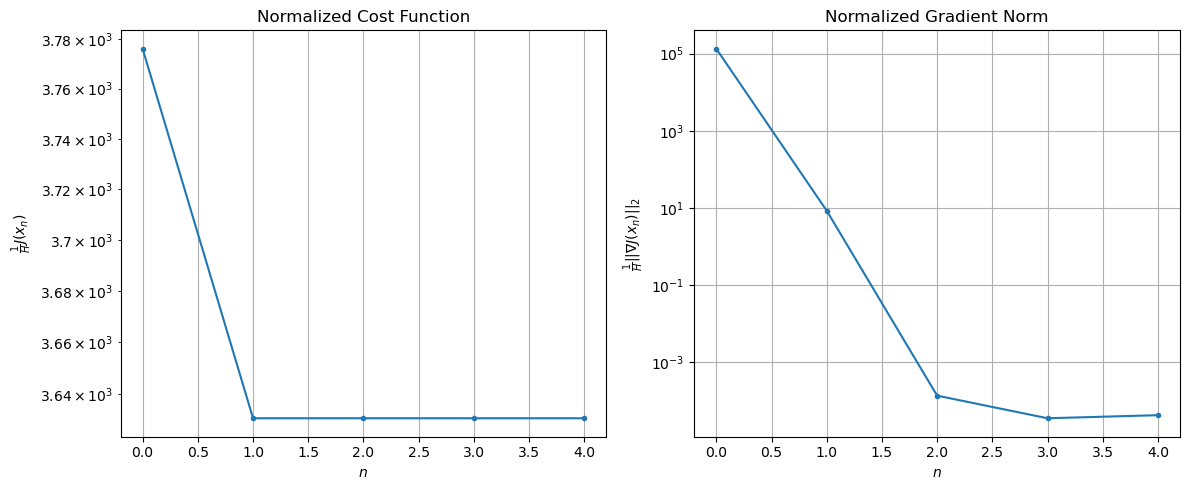

Before applying the algorithm
Cost function: 102157.80142753579
Gradient norm: 4161299.3776081335
Global estimation error: 34.13890201972263
Initial conditions estimation errors: 13.686371634358087 m, 15.189064609238919 m, 20.639063534842958 m, 17.92892149878563 m
Position estimation errors: 13.51127799725597 m, 17.797758477483253 m, 13.83762994715128 m, 13.66562220307232 m

Iteration 1
Cost function: 98532.31145311426 (-3.55%)
Gradient norm: 47.131305203739686 (-100.00%)
Global estimation error: 38.615016138087576 (13.11%)
Initial conditions estimation errors: 15.879667920879797 m, 17.553060040574287 m, 19.343687211594624 m, 23.593310126816153 m
Position estimation errors: 11.241861190151713 m, 14.877528435735234 m, 11.377219702567507 m, 11.49493638749906 m

Iteration 2
Cost function: 98532.31099595006 (-0.00%)
Gradient norm: 0.02514429141203087 (-99.95%)
Global estimation error: 38.49323932707116 (-0.32%)
Initial conditions estimation errors: 15.879667973848779 m, 17.553992252073197 

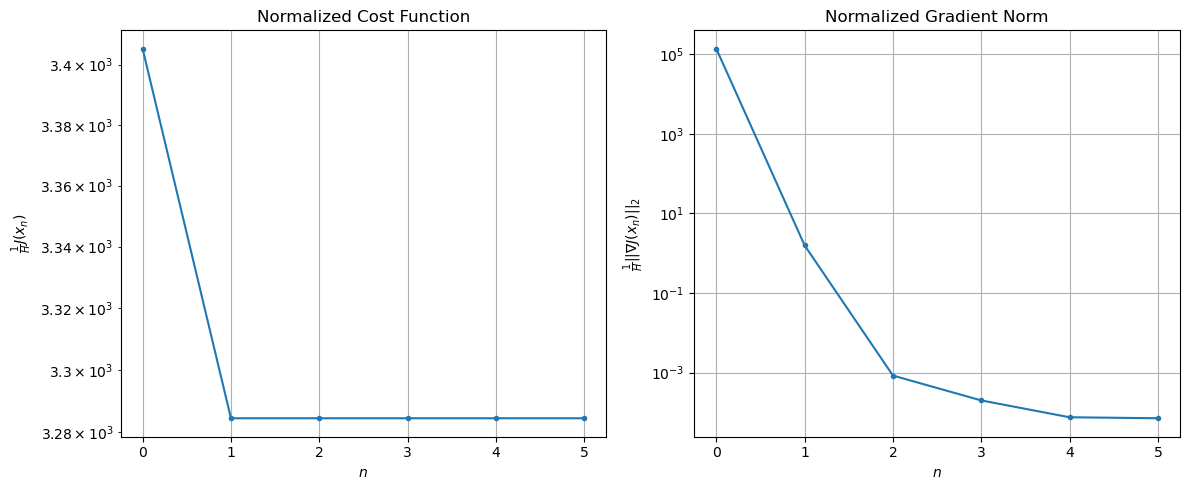

Before applying the algorithm
Cost function: 95050.96944925084
Gradient norm: 4271321.858424704
Global estimation error: 38.88918037557505
Initial conditions estimation errors: 12.121453244220001 m, 14.117358783458208 m, 20.913308625983735 m, 26.995431130733728 m
Position estimation errors: 13.505262268939505 m, 16.81803454183225 m, 14.629213827180438 m, 14.659624440120043 m

Iteration 1
Cost function: 92003.72632103224 (-3.21%)
Gradient norm: 32.43588762175666 (-100.00%)
Global estimation error: 35.65790857162304 (-8.31%)
Initial conditions estimation errors: 14.043966528983816 m, 16.112689876905744 m, 15.345295272852523 m, 24.065250730558656 m
Position estimation errors: 11.376285170564406 m, 14.446351198563276 m, 10.975993755288313 m, 10.881276083638102 m

Iteration 2
Cost function: 92003.72619425645 (-0.00%)
Gradient norm: 0.013770370480225306 (-99.96%)
Global estimation error: 35.570199945827184 (-0.25%)
Initial conditions estimation errors: 14.04396659152052 m, 16.113064987615527

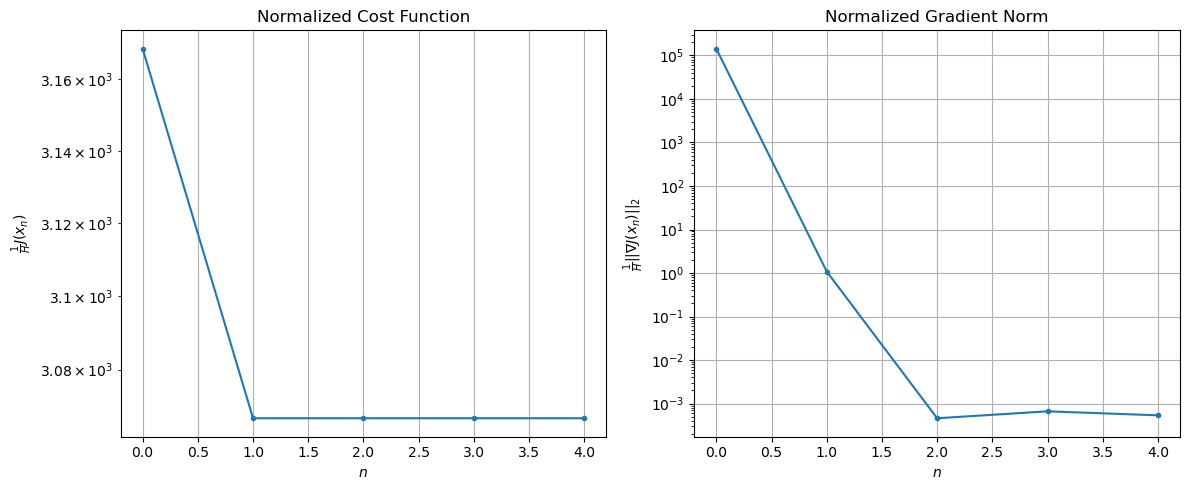

Before applying the algorithm
Cost function: 91617.8306984229
Gradient norm: 4482967.318410792
Global estimation error: 36.7534992952996
Initial conditions estimation errors: 10.682822688412898 m, 13.066754004851738 m, 18.006856830738805 m, 27.234053461269717 m
Position estimation errors: 13.675450518373259 m, 16.414933366348077 m, 13.874036515150754 m, 13.49069342175913 m

Iteration 1
Cost function: 88886.38921823494 (-2.98%)
Gradient norm: 3181.295439839405 (-99.93%)
Global estimation error: 32.65375572125971 (-11.15%)
Initial conditions estimation errors: 12.412242711425373 m, 12.191724562176518 m, 16.17985226849976 m, 22.40011385938988 m
Position estimation errors: 11.556561893901112 m, 12.352469970745881 m, 15.024714791619822 m, 16.025117878591804 m

Iteration 2
Cost function: 88886.19898906577 (-0.00%)
Gradient norm: 0.016437728027390946 (-100.00%)
Global estimation error: 32.68283348849946 (0.09%)
Initial conditions estimation errors: 12.412242793396015 m, 12.203239470773442 m, 

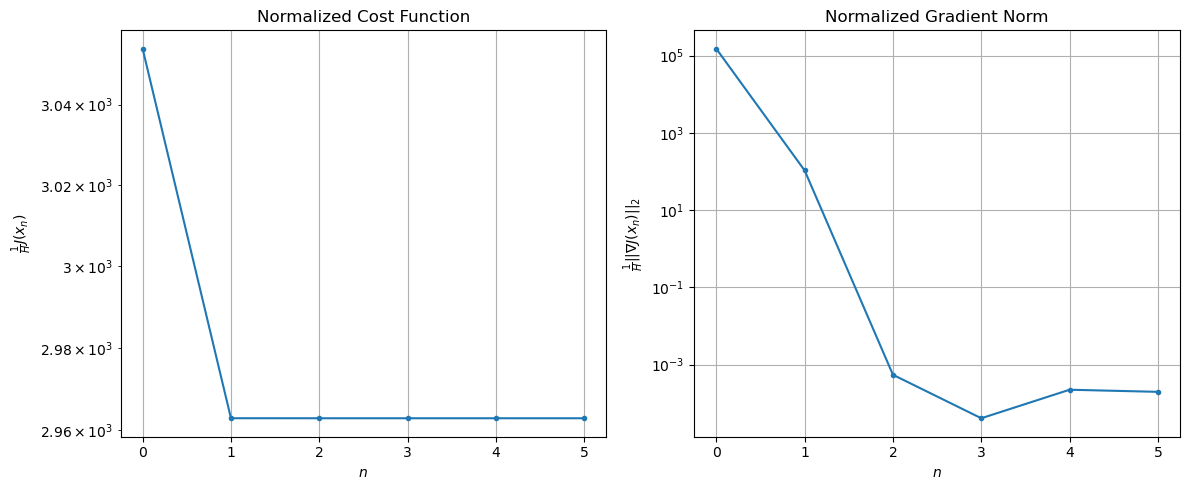

Before applying the algorithm
Cost function: 90641.7756714928
Gradient norm: 4523124.850060262
Global estimation error: 27.679895882215856
Initial conditions estimation errors: 9.547862047610376 m, 9.379640826426412 m, 14.002573271600824 m, 19.772578036139976 m
Position estimation errors: 13.864285977146595 m, 14.61663780952107 m, 16.57632265109427 m, 17.494143644391272 m

Iteration 1
Cost function: 88166.47210968434 (-2.73%)
Gradient norm: 373.6653362492672 (-99.99%)
Global estimation error: 41.78444819848411 (50.96%)
Initial conditions estimation errors: 11.126177747194737 m, 9.830795537611785 m, 25.929645814888058 m, 29.208692928313972 m
Position estimation errors: 11.737834626493603 m, 11.562010580744971 m, 16.413595471103157 m, 18.525015318147286 m

Iteration 2
Cost function: 88166.46980541489 (-0.00%)
Gradient norm: 0.03186677524704633 (-99.99%)
Global estimation error: 41.860042863069076 (0.18%)
Initial conditions estimation errors: 11.126177856470472 m, 9.824022078424596 m, 25.

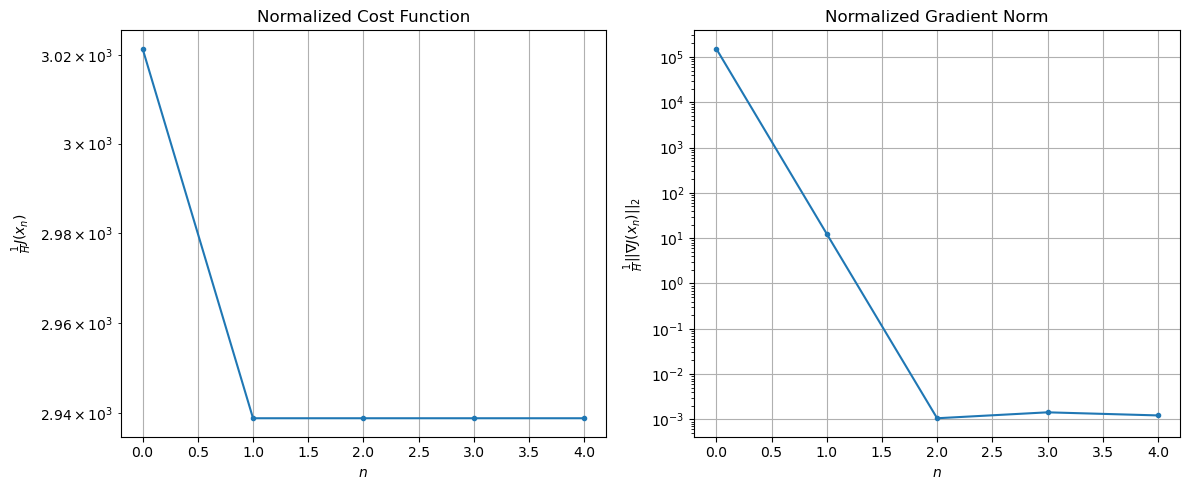

Before applying the algorithm
Cost function: 91979.11479828708
Gradient norm: 4752435.752779755
Global estimation error: 38.25579283802864
Initial conditions estimation errors: 8.798800825886373 m, 7.717313534717026 m, 24.36628951706784 m, 27.07039751243248 m
Position estimation errors: 14.060128561208192 m, 13.795996386245758 m, 17.53460456979411 m, 19.37343363902507 m

Iteration 1
Cost function: 89549.13351917337 (-2.64%)
Gradient norm: 479.9779215103298 (-99.99%)
Global estimation error: 23.540318868487393 (-38.47%)
Initial conditions estimation errors: 10.298149301992154 m, 12.020107653221682 m, 7.754848016451641 m, 15.603396046612284 m
Position estimation errors: 11.838491461458336 m, 11.73785560969677 m, 17.270781690621053 m, 18.540199320365637 m

Iteration 2
Cost function: 89549.12301426723 (-0.00%)
Gradient norm: 0.0072178738728118684 (-100.00%)
Global estimation error: 23.56730847900411 (0.11%)
Initial conditions estimation errors: 10.298149436165296 m, 12.022193430144041 m, 7

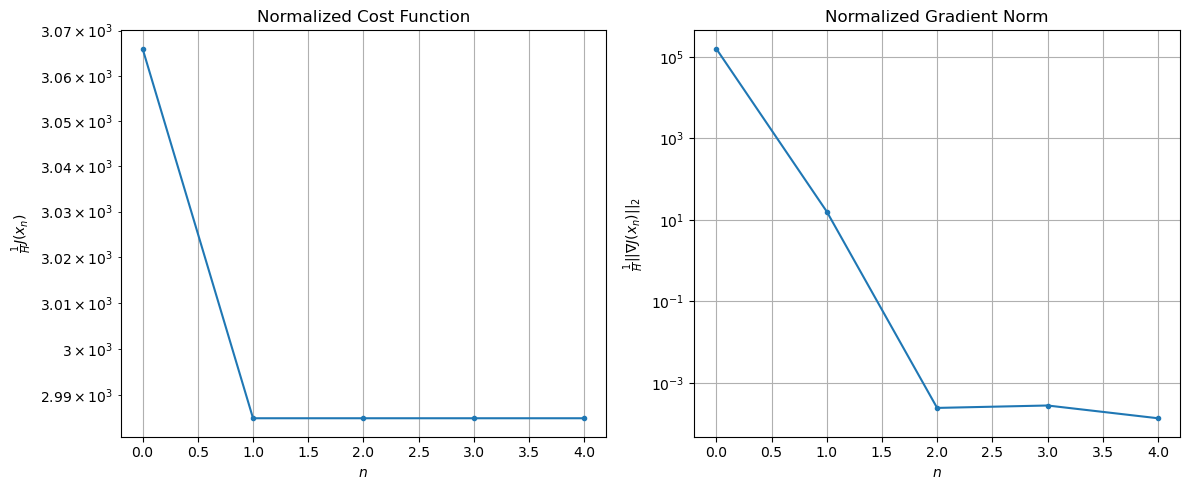

Before applying the algorithm
Cost function: 94189.67081129136
Gradient norm: 4782420.44342938
Global estimation error: 20.308064372246648
Initial conditions estimation errors: 8.471268216079265 m, 10.23052619674494 m, 6.671783965496505 m, 13.837354610346045 m
Position estimation errors: 14.193757670585144 m, 14.045866490275609 m, 19.160753082121097 m, 20.55038067109606 m

Iteration 1
Cost function: 91766.18295315698 (-2.57%)
Gradient norm: 2236.836349579281 (-99.95%)
Global estimation error: 54.2718620349302 (167.24%)
Initial conditions estimation errors: 9.969456019372975 m, 8.77614901544247 m, 35.941338422882545 m, 38.43488078841551 m
Position estimation errors: 11.91683265618319 m, 11.552945727353874 m, 21.844817744284686 m, 26.011831979630106 m

Iteration 2
Cost function: 91766.0776865284 (-0.00%)
Gradient norm: 0.07182605707113911 (-100.00%)
Global estimation error: 54.627569591980176 (0.66%)
Initial conditions estimation errors: 9.969456174214752 m, 8.76767692870068 m, 36.170930

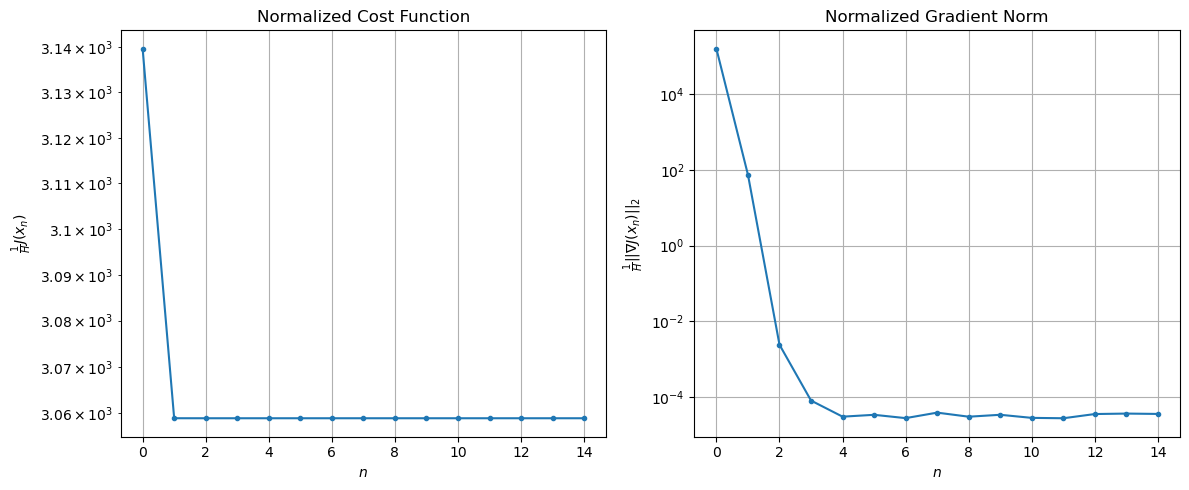

Before applying the algorithm
Cost function: 96959.76972547123
Gradient norm: 4895047.096742544
Global estimation error: 53.53133590021436
Initial conditions estimation errors: 8.562879676545096 m, 8.304262325314397 m, 35.42369418006792 m, 38.32073463197732 m
Position estimation errors: 14.32719842045054 m, 14.045698061096545 m, 22.56927511503206 m, 26.017971139742233 m

Iteration 1
Cost function: 94470.71262889585 (-2.57%)
Gradient norm: 523.0274737248095 (-99.99%)
Global estimation error: 77.26452727751179 (44.34%)
Initial conditions estimation errors: 10.076604019458275 m, 9.787486633198496 m, 50.782520172626555 m, 56.51200184140214 m
Position estimation errors: 11.972770499378804 m, 10.435128567776971 m, 22.250245776197623 m, 26.88376075633216 m

Iteration 2
Cost function: 94470.70793788733 (-0.00%)
Gradient norm: 0.026702091915974505 (-99.99%)
Global estimation error: 77.29816684542719 (0.04%)
Initial conditions estimation errors: 10.076604183172902 m, 9.788128539425161 m, 50.8020

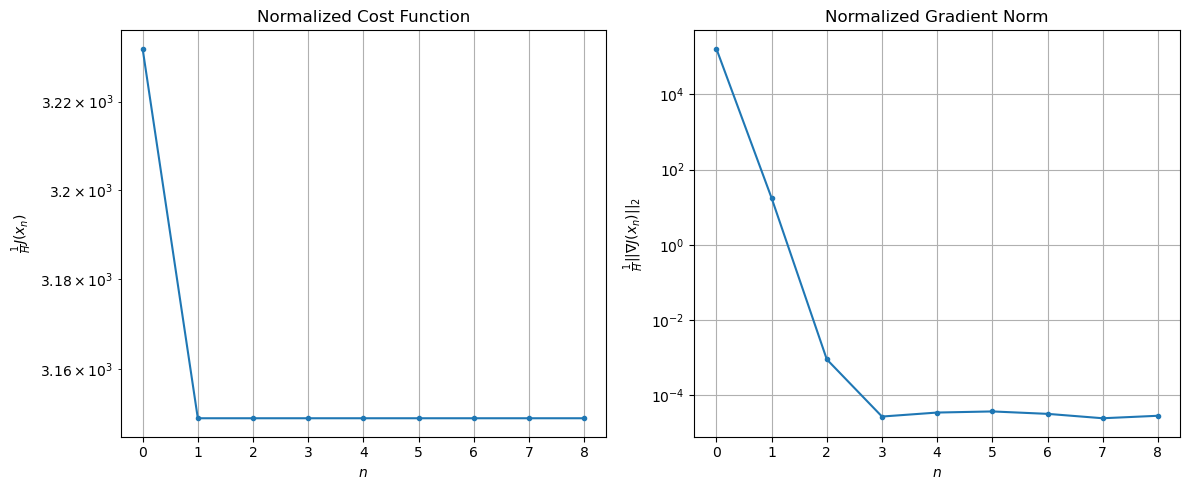

Before applying the algorithm
Cost function: 100217.37165475081
Gradient norm: 4997614.667445908
Global estimation error: 76.94476585933043
Initial conditions estimation errors: 8.96027990300478 m, 9.605294974331237 m, 50.30098874072998 m, 56.72526756350301 m
Position estimation errors: 14.42722940748957 m, 12.804360188035297 m, 22.804516800744217 m, 25.878103508464086 m

Iteration 1
Cost function: 97593.83953984766 (-2.62%)
Gradient norm: 135.10269416039586 (-100.00%)
Global estimation error: 60.676640633890734 (-21.14%)
Initial conditions estimation errors: 10.545620807050955 m, 11.374052748570533 m, 40.06985023392084 m, 42.84249434073246 m
Position estimation errors: 12.00272538144978 m, 11.096120498870835 m, 24.584409983806136 m, 30.400336303119612 m

Iteration 2
Cost function: 97593.83774986786 (-0.00%)
Gradient norm: 0.02427458445111192 (-99.98%)
Global estimation error: 60.74274535729256 (0.11%)
Initial conditions estimation errors: 10.545620958715604 m, 11.373481556392118 m, 40

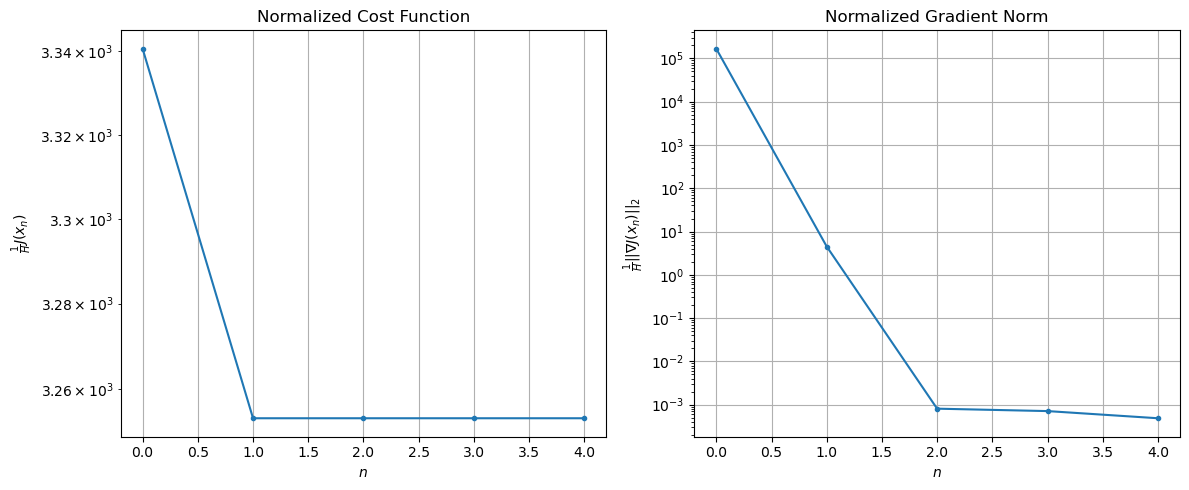

Before applying the algorithm
Cost function: 102441.41221390088
Gradient norm: 4800602.47348151
Global estimation error: 60.64127419737165
Initial conditions estimation errors: 9.517009879086267 m, 10.884084876866147 m, 39.6753439438944 m, 43.52230315744958 m
Position estimation errors: 14.478106334371795 m, 13.56399223581185 m, 25.05078559013442 m, 29.69105958081019 m

Iteration 1
Cost function: 99779.13233274553 (-2.60%)
Gradient norm: 1110.4823673959725 (-99.98%)
Global estimation error: 47.02087529422765 (-22.46%)
Initial conditions estimation errors: 11.22663977959236 m, 12.207721567954515 m, 30.2705918478078 m, 31.9309224939698 m
Position estimation errors: 12.105517520687863 m, 10.939969880266139 m, 13.116573612223203 m, 14.030901716369666 m

Iteration 2
Cost function: 99779.12433800001 (-0.00%)
Gradient norm: 0.030865857077067856 (-100.00%)
Global estimation error: 47.0724291812008 (0.11%)
Initial conditions estimation errors: 11.226639876534314 m, 12.20169883222343 m, 30.30834

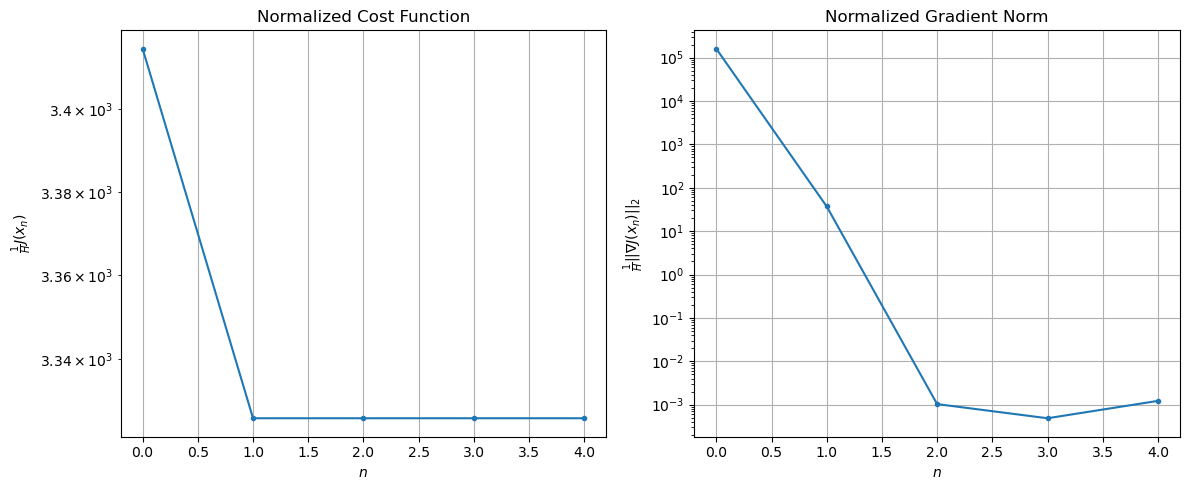

Before applying the algorithm
Cost function: 104407.50064681566
Gradient norm: 4757678.575215782
Global estimation error: 45.092575721017376
Initial conditions estimation errors: 10.047370863842817 m, 10.905993604896732 m, 28.896285599366387 m, 31.280183547509495 m
Position estimation errors: 14.589291689894319 m, 13.261941585381082 m, 14.647275633950292 m, 14.222796552343812 m

Iteration 1
Cost function: 101615.60890932054 (-2.67%)
Gradient norm: 5810.487224929012 (-99.88%)
Global estimation error: 39.0480260848458 (-13.40%)
Initial conditions estimation errors: 11.91387280649425 m, 16.743551583992513 m, 20.54230514864361 m, 26.08575271496502 m
Position estimation errors: 12.237640274913668 m, 10.977818464207566 m, 8.765942841896923 m, 9.213212596951575 m

Iteration 2
Cost function: 101615.06345111156 (-0.00%)
Gradient norm: 0.03164652108113918 (-100.00%)
Global estimation error: 38.950144388316076 (-0.25%)
Initial conditions estimation errors: 11.913872801257996 m, 16.734833904923953

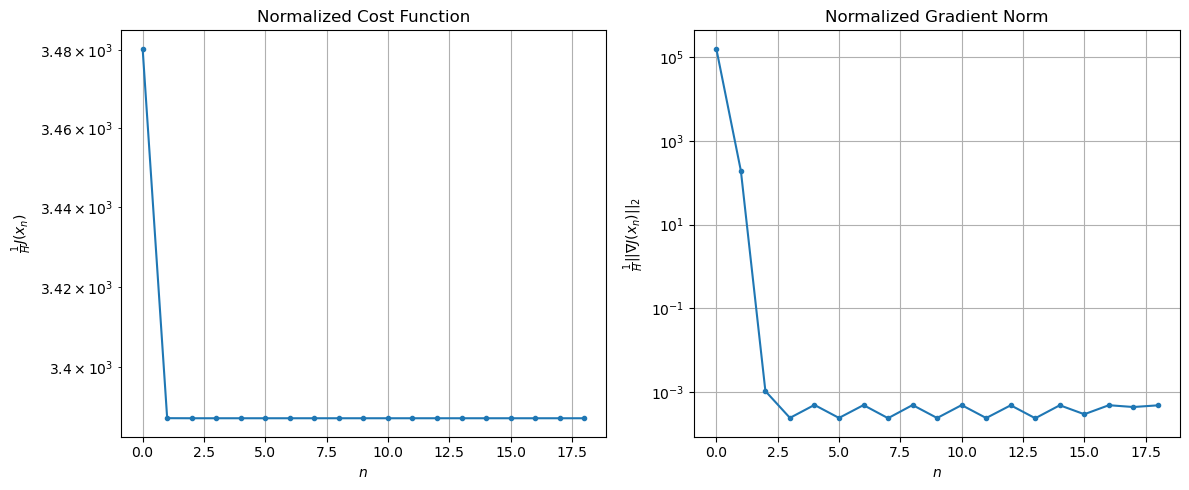

Before applying the algorithm
Cost function: 105755.34549521116
Gradient norm: 4681826.9216260025
Global estimation error: 39.67646647600186
Initial conditions estimation errors: 10.409546077038325 m, 14.985858975307458 m, 22.478616744173117 m, 27.12913972779819 m
Position estimation errors: 14.724692038948117 m, 13.030854820195144 m, 10.366645472419046 m, 9.439622532791786 m

Iteration 1
Cost function: 102679.52337309803 (-2.91%)
Gradient norm: 1658.4210361239914 (-99.96%)
Global estimation error: 69.68959001362485 (75.64%)
Initial conditions estimation errors: 12.526056897195595 m, 19.129338472742567 m, 41.6565142958616 m, 50.97574528121513 m
Position estimation errors: 12.360304053890516 m, 11.514692518594737 m, 10.323866033463984 m, 17.21413596650792 m

Iteration 2
Cost function: 102679.49351416324 (-0.00%)
Gradient norm: 0.015014691188305335 (-100.00%)
Global estimation error: 69.67084113485365 (-0.03%)
Initial conditions estimation errors: 12.526056743742245 m, 19.12737542740453 

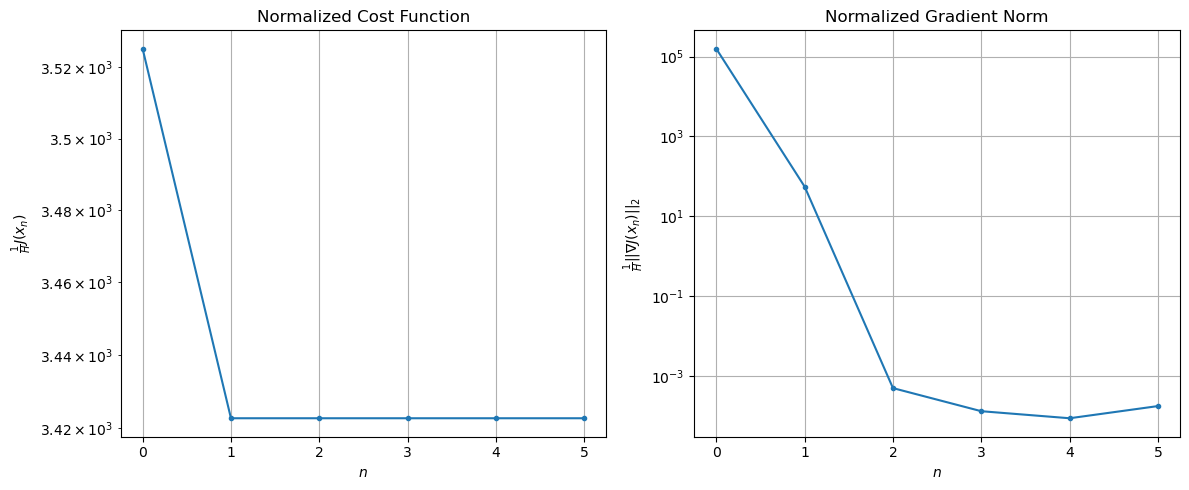

Before applying the algorithm
Cost function: 105790.85543653171
Gradient norm: 4490657.399275483
Global estimation error: 72.42839096764024
Initial conditions estimation errors: 10.624522881008645 m, 17.350509160487768 m, 44.5016986218758 m, 53.39978032149441 m
Position estimation errors: 14.845108330398508 m, 13.435470815717602 m, 9.065417232156564 m, 14.27776007552889 m

Iteration 1
Cost function: 102471.10965555212 (-3.14%)
Gradient norm: 200.19963585699014 (-100.00%)
Global estimation error: 67.93566536607176 (-6.20%)
Initial conditions estimation errors: 13.013567962032216 m, 18.31882621119771 m, 39.65688707852807 m, 50.374962604775554 m
Position estimation errors: 12.51779571394608 m, 10.982489790376817 m, 13.177302379462308 m, 23.93049460142431 m

Iteration 2
Cost function: 102471.10918002346 (-0.00%)
Gradient norm: 0.05861010992878142 (-99.97%)
Global estimation error: 67.98655070776955 (0.07%)
Initial conditions estimation errors: 13.013567645651523 m, 18.322681290744452 m, 39

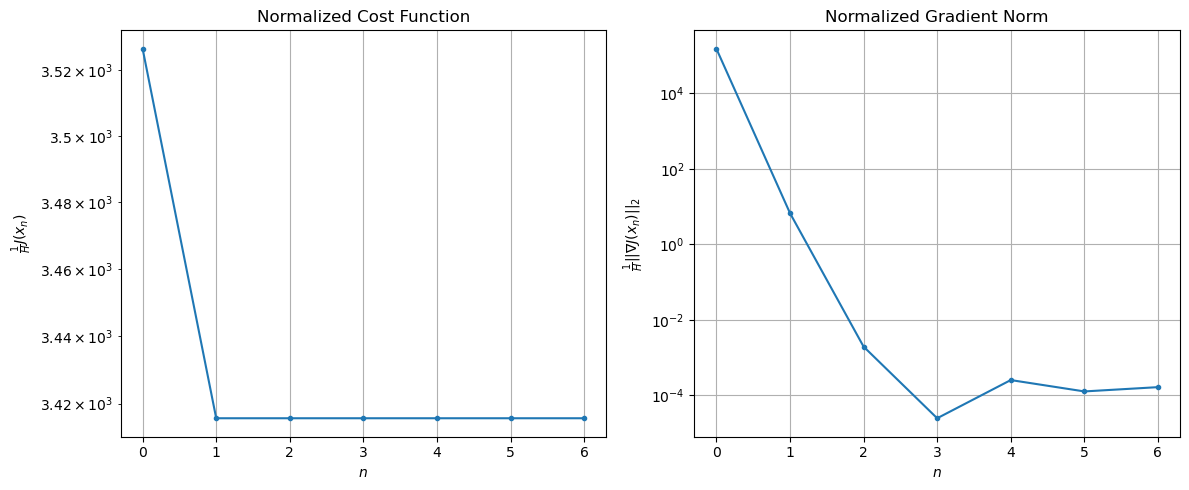

Before applying the algorithm
Cost function: 105059.7873561565
Gradient norm: 4314545.78412456
Global estimation error: 70.44617706479569
Initial conditions estimation errors: 10.71622116595844 m, 16.520616555493802 m, 42.42736246956945 m, 52.6763474314195 m
Position estimation errors: 15.00762046699183 m, 12.857915542083637 m, 11.072222623383759 m, 20.918746842428757 m

Iteration 1
Cost function: 101451.98761997928 (-3.43%)
Gradient norm: 24.846890415428568 (-100.00%)
Global estimation error: 66.28807548572895 (-5.90%)
Initial conditions estimation errors: 13.382732748353014 m, 18.07405140199053 m, 38.67002046933127 m, 48.91779804773169 m
Position estimation errors: 12.691768207568309 m, 11.972371704662823 m, 11.620232147327068 m, 22.86671386804646 m

Iteration 2
Cost function: 101451.98760842158 (-0.00%)
Gradient norm: 0.004004284705150207 (-99.98%)
Global estimation error: 66.24653323292898 (-0.06%)
Initial conditions estimation errors: 13.382732309038209 m, 18.071123183233137 m, 38

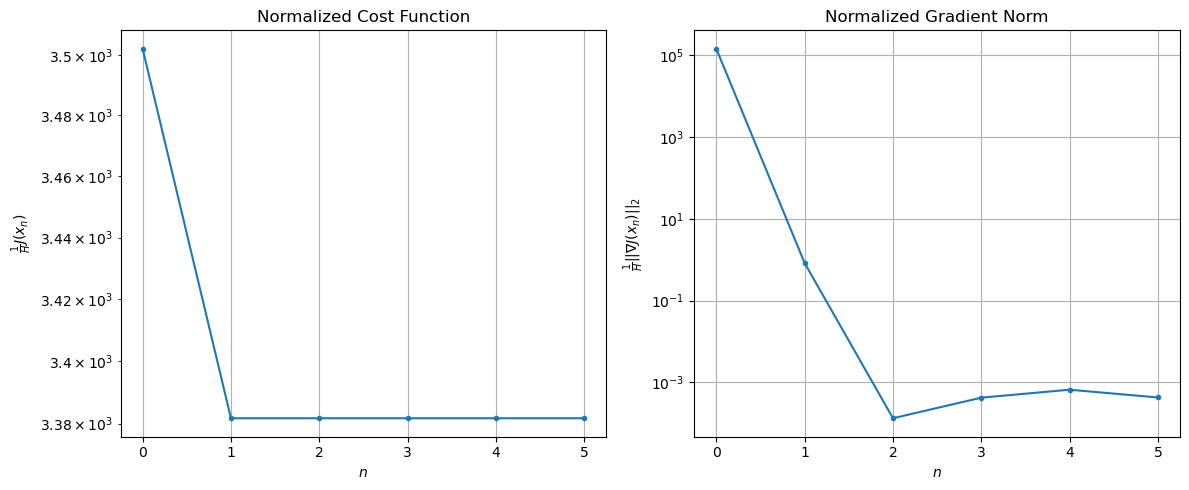

Before applying the algorithm
Cost function: 104537.66794994794
Gradient norm: 4277640.944105068
Global estimation error: 68.04729716148908
Initial conditions estimation errors: 10.732006363578318 m, 16.269538213968502 m, 40.91590482790619 m, 50.75855163720541 m
Position estimation errors: 15.202782002970284 m, 13.832493835616164 m, 9.766712633936201 m, 20.029110597040667 m

Iteration 1
Cost function: 100684.36822114333 (-3.69%)
Gradient norm: 1926.5661027560586 (-99.95%)
Global estimation error: 73.43345607648384 (7.92%)
Initial conditions estimation errors: 13.574790135391561 m, 17.188124305838503 m, 39.34345622004633 m, 58.007142519388616 m
Position estimation errors: 12.830157363543167 m, 15.25780963862709 m, 25.532717752020393 m, 45.85612378197071 m

Iteration 2
Cost function: 100684.35518868988 (-0.00%)
Gradient norm: 0.02182773939727216 (-100.00%)
Global estimation error: 73.3750812241943 (-0.08%)
Initial conditions estimation errors: 13.574789665726897 m, 17.190617529259054 m, 

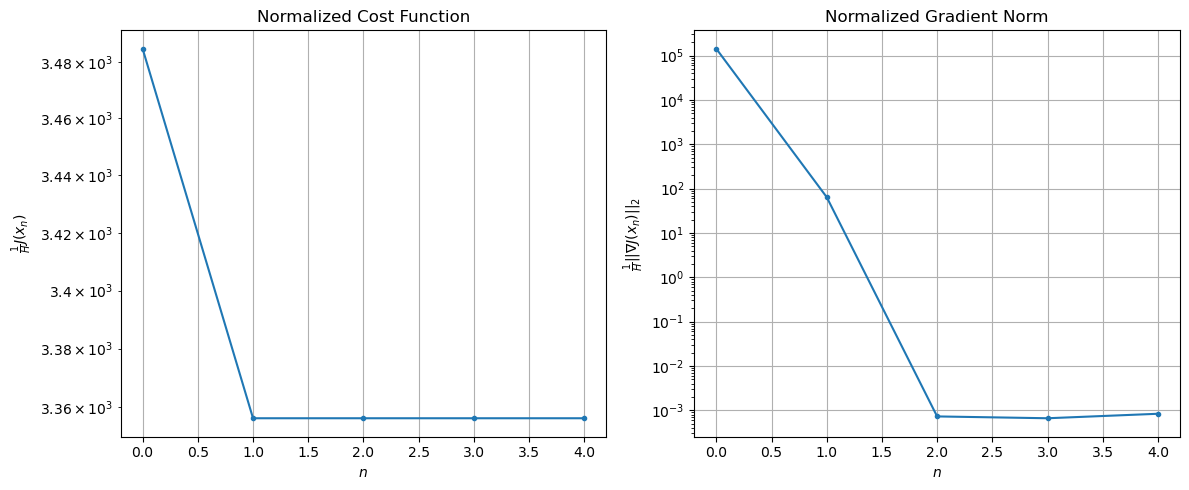

Before applying the algorithm
Cost function: 103110.60419095526
Gradient norm: 4124717.659480595
Global estimation error: 76.03804457916134
Initial conditions estimation errors: 10.670193543740268 m, 15.53550273260394 m, 42.776568259705016 m, 59.9726266521912 m
Position estimation errors: 15.36894260886036 m, 16.98828649702367 m, 21.369056092522452 m, 41.11628174488274 m

Iteration 1
Cost function: 99004.48274440713 (-3.98%)
Gradient norm: 3833.005107049039 (-99.91%)
Global estimation error: 44.38119352784361 (-41.63%)
Initial conditions estimation errors: 13.697117384344029 m, 16.29138372114986 m, 21.081002488841726 m, 32.74504210042357 m
Position estimation errors: 12.953990427222358 m, 11.274431083619454 m, 10.534940823322772 m, 20.213572989774214 m

Iteration 2
Cost function: 99004.38069729194 (-0.00%)
Gradient norm: 0.01032822600370381 (-100.00%)
Global estimation error: 44.40867061788187 (0.06%)
Initial conditions estimation errors: 13.697116976012365 m, 16.28324256238756 m, 21.0

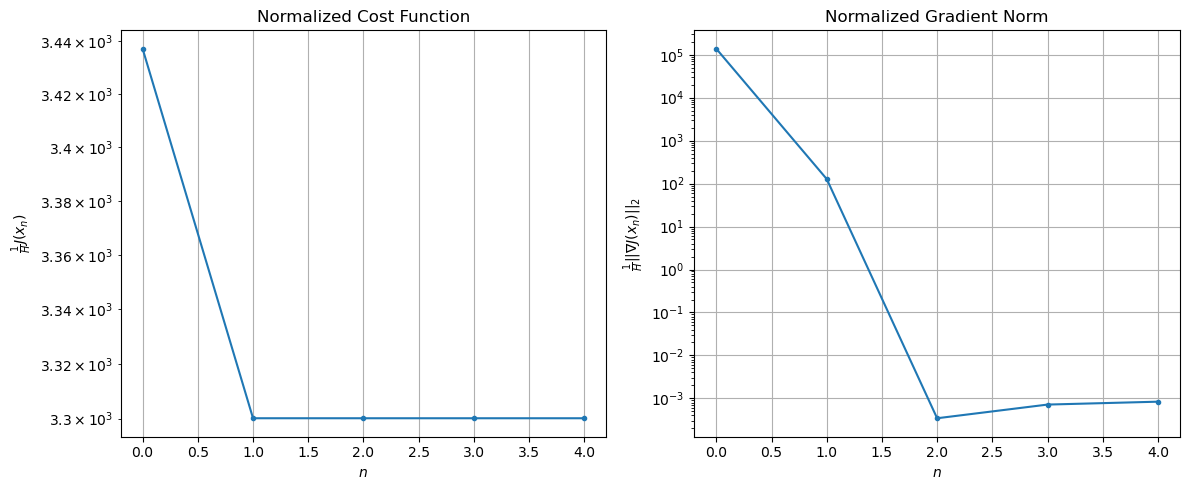

Before applying the algorithm
Cost function: 101719.86399078714
Gradient norm: 3990902.7066794755
Global estimation error: 41.751502402576534
Initial conditions estimation errors: 10.67434990740424 m, 14.113858632112283 m, 21.244725671864252 m, 31.283932109689516 m
Position estimation errors: 15.515837607453497 m, 13.471907530593093 m, 11.711828520350746 m, 20.20616139486138 m

Iteration 1
Cost function: 97471.41970516951 (-4.18%)
Gradient norm: 3290.7217818560493 (-99.92%)
Global estimation error: 30.3162723717576 (-27.39%)
Initial conditions estimation errors: 13.75055979291552 m, 13.569552833255441 m, 14.25854488296155 m, 18.507791626202888 m
Position estimation errors: 13.01592003811207 m, 10.918757029919231 m, 15.158000354116952 m, 15.006908044348627 m

Iteration 2
Cost function: 97471.32956396497 (-0.00%)
Gradient norm: 0.06619221078370524 (-100.00%)
Global estimation error: 30.34992759676514 (0.11%)
Initial conditions estimation errors: 13.750559534818068 m, 13.570777857207423 m

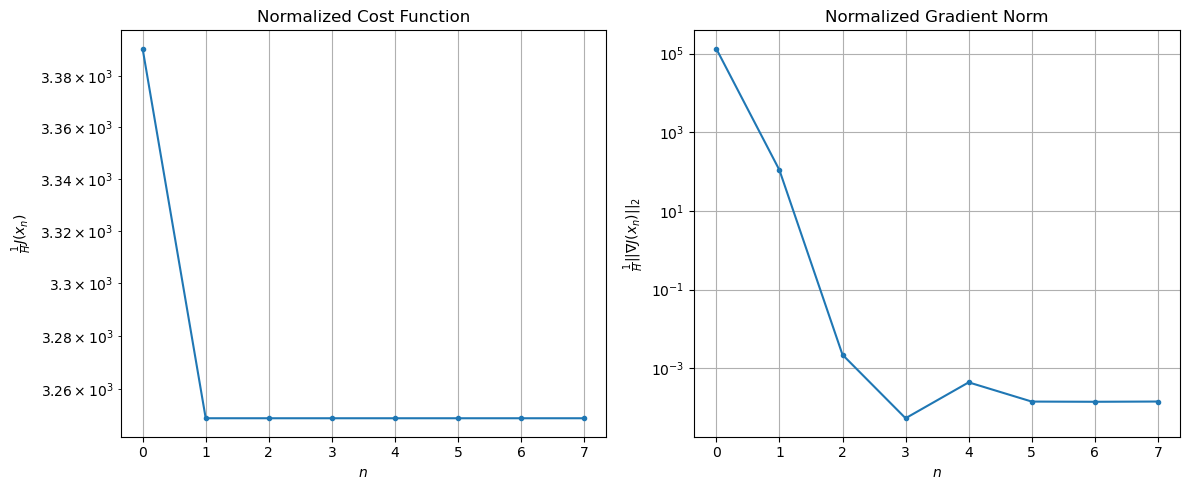

Before applying the algorithm
Cost function: 99961.7809666059
Gradient norm: 3977566.6601811037
Global estimation error: 25.097442041600054
Initial conditions estimation errors: 10.771967947115975 m, 11.153231309721564 m, 12.008872007110634 m, 15.65950121790234 m
Position estimation errors: 15.585587236486951 m, 13.418865292752994 m, 17.409337001190472 m, 17.351262971417068 m

Iteration 1
Cost function: 95648.85568404233 (-4.31%)
Gradient norm: 60.022038176494036 (-100.00%)
Global estimation error: 35.72044436271891 (42.33%)
Initial conditions estimation errors: 13.817397757686512 m, 13.936310081439414 m, 18.338330707113844 m, 23.54768289967687 m
Position estimation errors: 13.001675478563408 m, 10.077604282800158 m, 15.880736785892854 m, 15.187575989375544 m

Iteration 2
Cost function: 95648.8556411765 (-0.00%)
Gradient norm: 0.006866414506978135 (-99.99%)
Global estimation error: 35.73123796072661 (0.03%)
Initial conditions estimation errors: 13.817397691945612 m, 13.934915339763343 

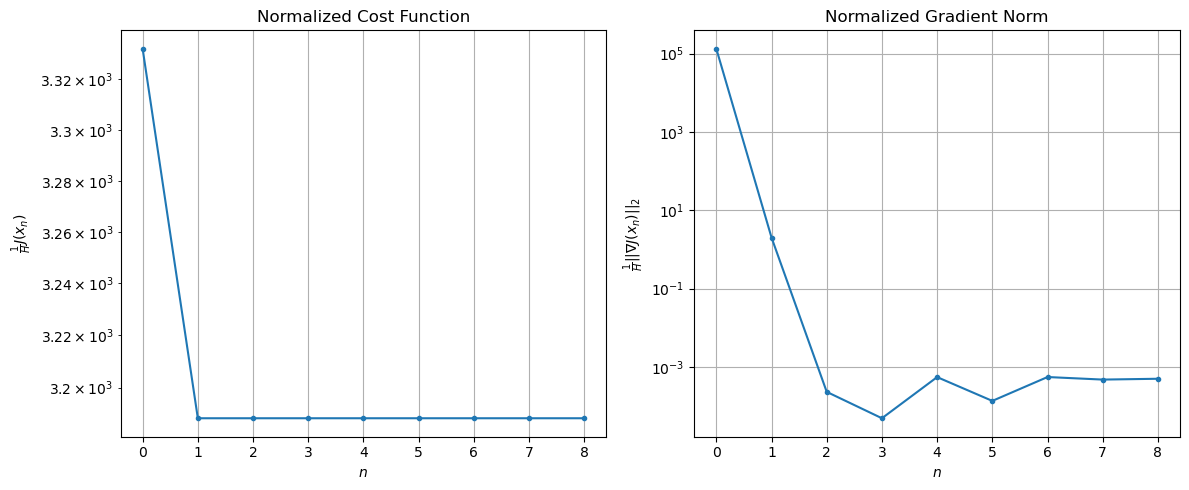

Before applying the algorithm
Cost function: 97793.40718432819
Gradient norm: 3926291.5204855567
Global estimation error: 31.689834432965487
Initial conditions estimation errors: 10.994814667888969 m, 11.700264884840612 m, 16.90562662950145 m, 21.462674212099614 m
Position estimation errors: 15.564651455351534 m, 12.617117383637531 m, 17.982576782822964 m, 17.1775479631614 m

Iteration 1
Cost function: 93435.49411848538 (-4.46%)
Gradient norm: 700.7682700518908 (-99.98%)
Global estimation error: 46.32405275328412 (46.18%)
Initial conditions estimation errors: 13.974574627611952 m, 13.295455413485259 m, 26.440478650816438 m, 32.78325350313886 m
Position estimation errors: 12.879937101920321 m, 9.554753284077124 m, 22.707821728546993 m, 25.330569822485224 m

Iteration 2
Cost function: 93435.49140741833 (-0.00%)
Gradient norm: 0.03437037967188479 (-100.00%)
Global estimation error: 46.27338252721417 (-0.11%)
Initial conditions estimation errors: 13.974574739721586 m, 13.299610617760457 m,

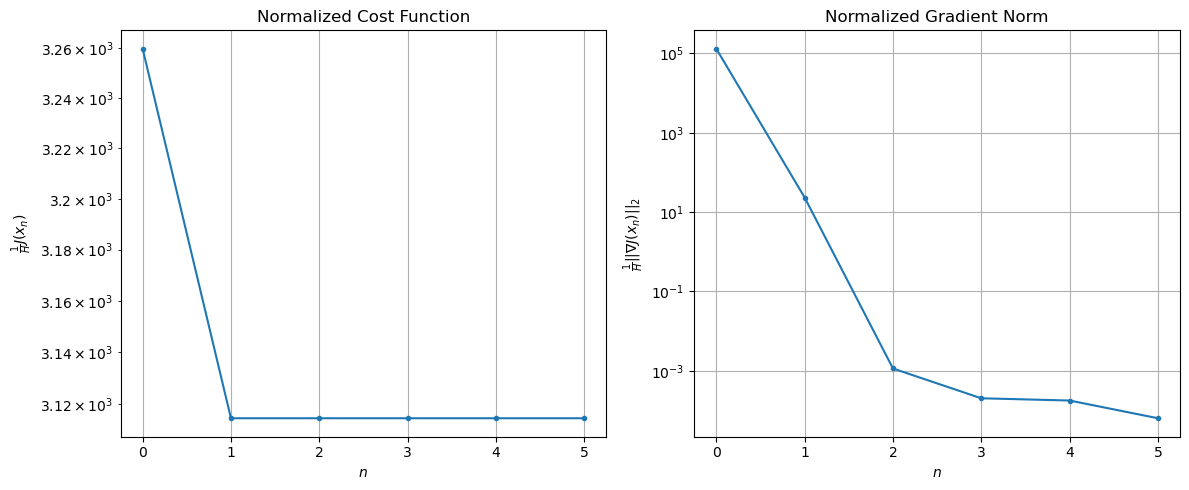

Before applying the algorithm
Cost function: 95231.78569737118
Gradient norm: 3989375.7346165734
Global estimation error: 44.72630417320553
Initial conditions estimation errors: 11.350630832686042 m, 11.100140521619906 m, 26.007412582977533 m, 32.741299318929364 m
Position estimation errors: 15.427907500578309 m, 12.189220800475397 m, 23.887452020905094 m, 25.57015745426254 m

Iteration 1
Cost function: 90827.65896656278 (-4.62%)
Gradient norm: 3497.9938652695687 (-99.91%)
Global estimation error: 31.675535262116338 (-29.18%)
Initial conditions estimation errors: 14.248936744115442 m, 15.323599997143097 m, 13.216088629735832 m, 19.768977666106625 m
Position estimation errors: 12.638734151365002 m, 12.122948262142046 m, 9.57860331147465 m, 14.865692283793315 m

Iteration 2
Cost function: 90827.58795133476 (-0.00%)
Gradient norm: 0.04886086297889561 (-100.00%)
Global estimation error: 31.71307864904301 (0.12%)
Initial conditions estimation errors: 14.248936993010398 m, 15.314093362842883

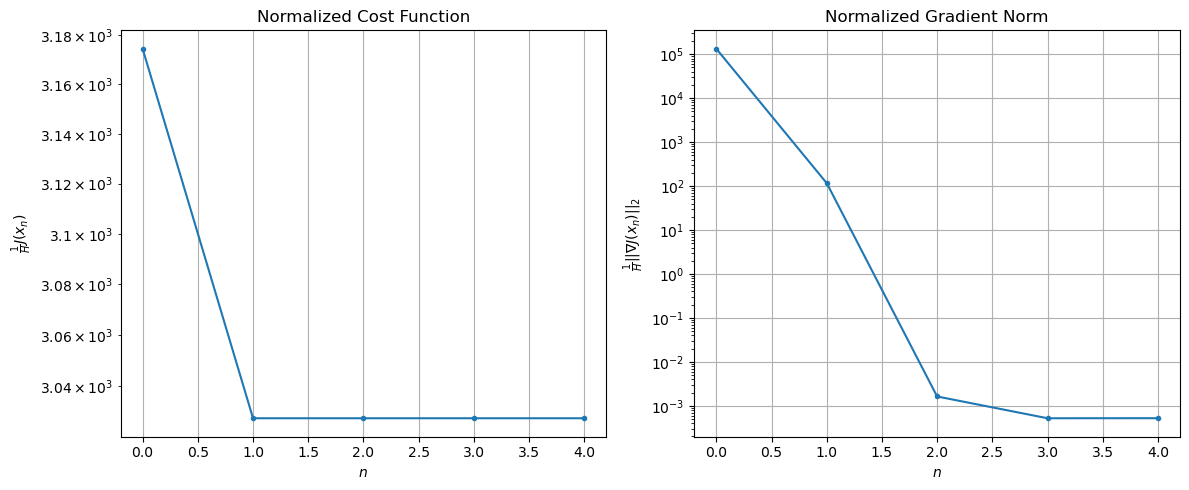

Before applying the algorithm
Cost function: 92016.1062135757
Gradient norm: 3929607.8054874754
Global estimation error: 26.15636673739623
Initial conditions estimation errors: 11.789079902045469 m, 13.54240397620307 m, 10.944869465831243 m, 15.555509405985582 m
Position estimation errors: 15.16336372906806 m, 14.413921310958322 m, 12.174060517223968 m, 16.95004894937369 m

Iteration 1
Cost function: 87656.98048466207 (-4.74%)
Gradient norm: 2972.4675512670847 (-99.92%)
Global estimation error: 54.36755951109125 (107.86%)
Initial conditions estimation errors: 14.608105092517375 m, 13.480361740683415 m, 31.52458683692698 m, 39.58411143592477 m
Position estimation errors: 12.322733546281905 m, 10.589305673923944 m, 20.927734685645635 m, 21.255597602737858 m

Iteration 2
Cost function: 87656.91592714327 (-0.00%)
Gradient norm: 0.34765950981607724 (-99.99%)
Global estimation error: 54.2053845731586 (-0.30%)
Initial conditions estimation errors: 14.608105423130903 m, 13.492126243608508 m, 3

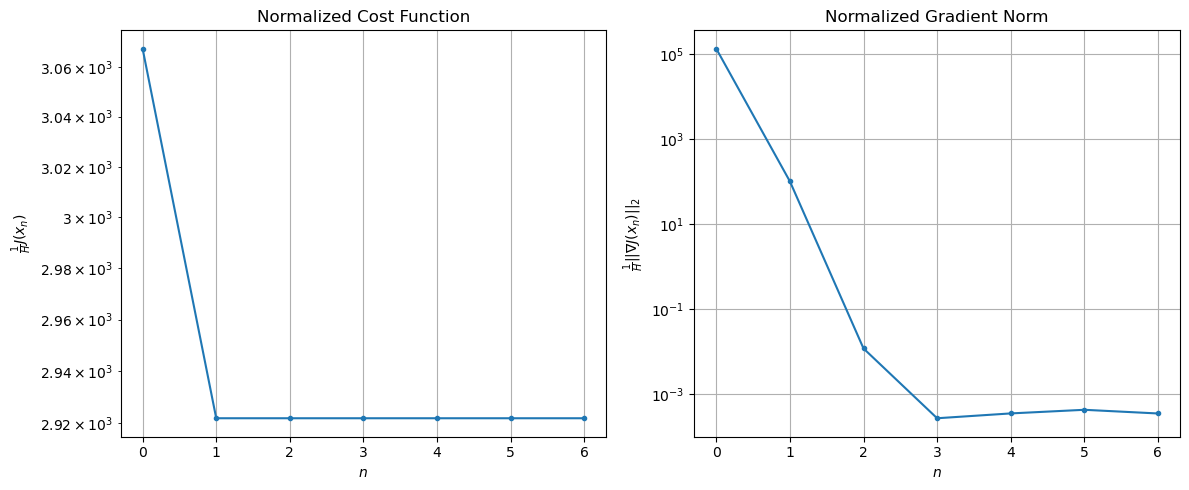

Before applying the algorithm
Cost function: 88018.80189793668
Gradient norm: 3927648.9608554845
Global estimation error: 52.055974302495635
Initial conditions estimation errors: 12.23660584406424 m, 11.267387709487528 m, 30.868124850530492 m, 38.47447935628429 m
Position estimation errors: 14.832859020014048 m, 13.146967274452514 m, 22.485357436794402 m, 21.92549681410018 m

Iteration 1
Cost function: 83676.57189362033 (-4.93%)
Gradient norm: 213.94081640207483 (-99.99%)
Global estimation error: 53.62378685240625 (3.01%)
Initial conditions estimation errors: 15.009535301203007 m, 13.991547862242774 m, 31.056907602695905 m, 38.599466832336645 m
Position estimation errors: 11.950801936860202 m, 11.158304306105281 m, 15.04188251330988 m, 12.17902435333073 m

Iteration 2
Cost function: 83676.57169582663 (-0.00%)
Gradient norm: 0.04652327899661422 (-99.98%)
Global estimation error: 53.707650627195406 (0.16%)
Initial conditions estimation errors: 15.00953567525917 m, 13.988490787567404 m, 3

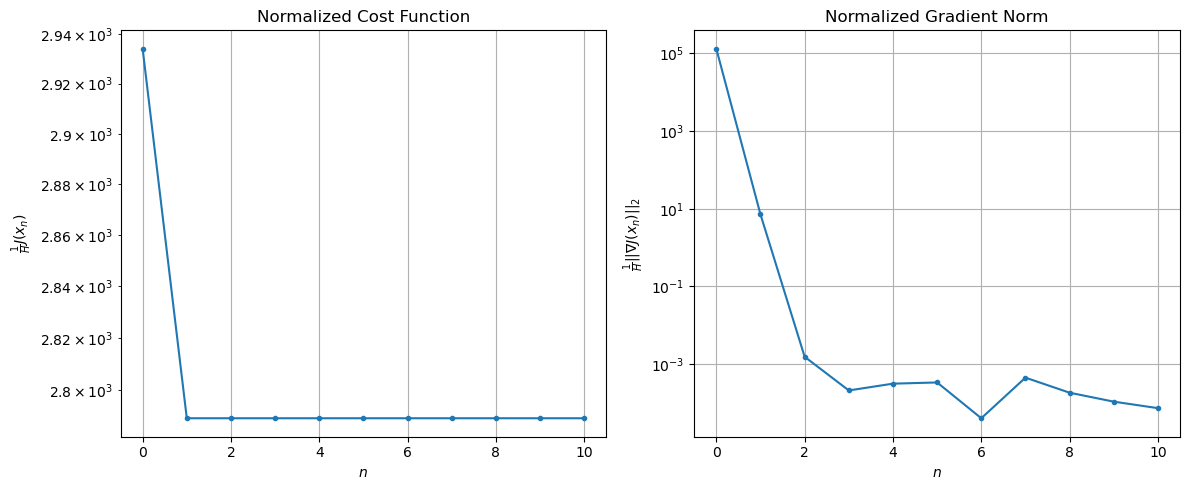

Before applying the algorithm
Cost function: 83187.7429322903
Gradient norm: 4015284.306573227
Global estimation error: 50.43895552259842
Initial conditions estimation errors: 12.618016403415295 m, 11.716195461280098 m, 30.01697478878273 m, 36.69574193912687 m
Position estimation errors: 14.485165044675403 m, 13.679143364886054 m, 17.352163263091263 m, 14.228393622908674 m

Iteration 1
Cost function: 78850.71610436881 (-5.21%)
Gradient norm: 587.0335824473023 (-99.99%)
Global estimation error: 57.54303869195058 (14.08%)
Initial conditions estimation errors: 15.362831250983726 m, 14.694092009760578 m, 34.32053011448953 m, 41.00440595057624 m
Position estimation errors: 11.578484932934984 m, 11.09515365865082 m, 15.197436225611076 m, 20.765398682462134 m

Iteration 2
Cost function: 78850.71481690492 (-0.00%)
Gradient norm: 0.05476796432387303 (-99.99%)
Global estimation error: 57.46058945735903 (-0.14%)
Initial conditions estimation errors: 15.362831641518213 m, 14.701678893680011 m, 34.

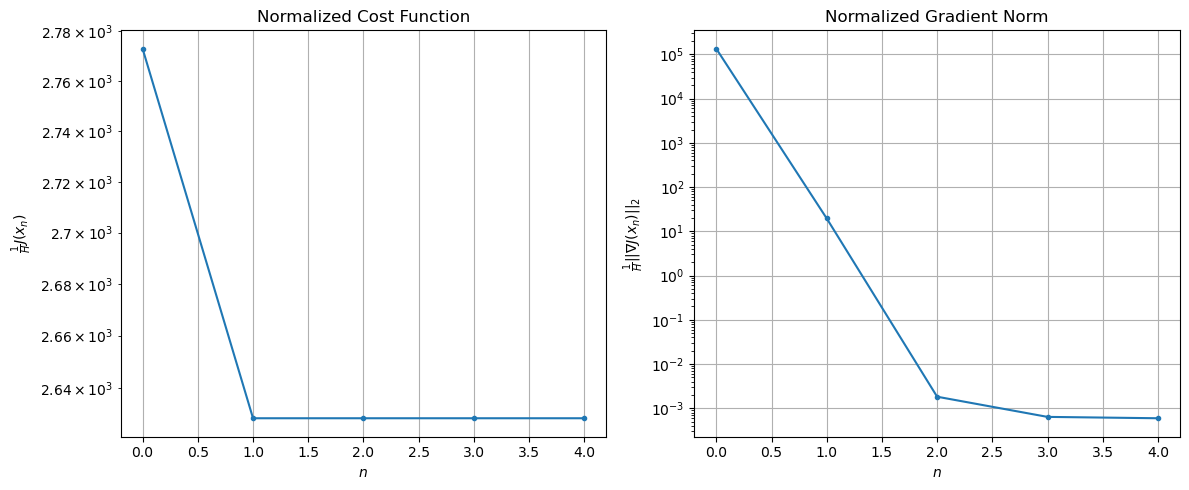

Before applying the algorithm
Cost function: 77341.74787962255
Gradient norm: 4093004.5637538303
Global estimation error: 55.274444774331
Initial conditions estimation errors: 12.826862381530121 m, 12.26477894049021 m, 33.27167152406981 m, 40.41410113492447 m
Position estimation errors: 14.215322284024126 m, 13.736994560427025 m, 16.23265907125181 m, 20.511980876734153 m

Iteration 1
Cost function: 72907.65524490924 (-5.73%)
Gradient norm: 110.28830112175187 (-100.00%)
Global estimation error: 54.22697098506043 (-1.90%)
Initial conditions estimation errors: 15.59959242063325 m, 16.148035719446682 m, 31.91549061949366 m, 37.65436364561575 m
Position estimation errors: 11.270741356322409 m, 10.75619564679005 m, 8.496464448449318 m, 14.077679119753041 m

Iteration 2
Cost function: 72907.65515370369 (-0.00%)
Gradient norm: 0.006338664810060692 (-99.99%)
Global estimation error: 54.242895502300804 (0.03%)
Initial conditions estimation errors: 15.59959281491053 m, 16.144940447762927 m, 31.92

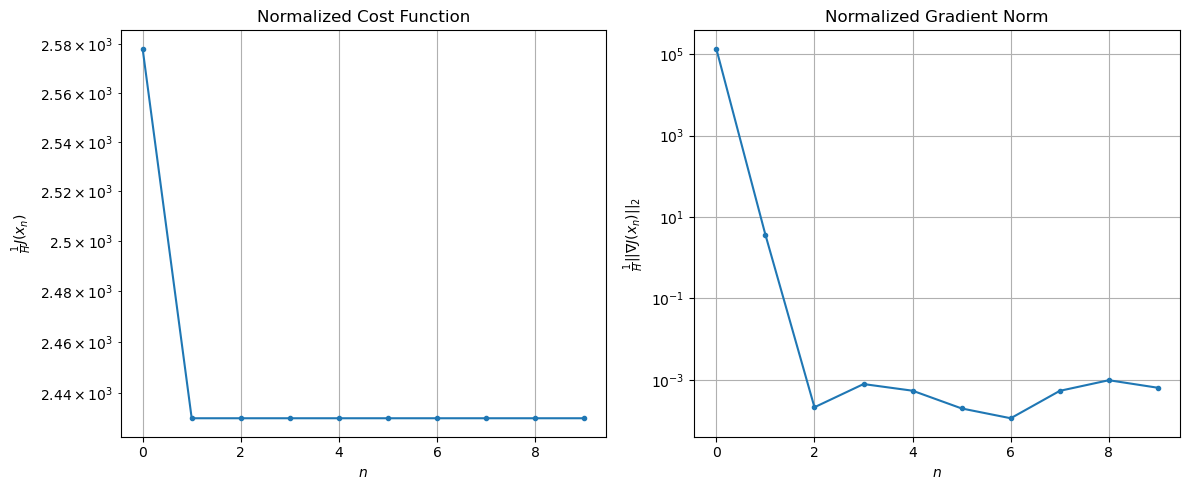

Before applying the algorithm
Cost function: 70439.75228397033
Gradient norm: 4190274.22059075
Global estimation error: 50.8966576659683
Initial conditions estimation errors: 12.816225184965429 m, 13.48924196245813 m, 30.224789231244632 m, 36.47887102541959 m
Position estimation errors: 14.11662193228474 m, 13.517234104943874 m, 9.581462877143021 m, 13.975649170207431 m

Iteration 1
Cost function: 66044.33516198135 (-6.24%)
Gradient norm: 318.5390212852413 (-99.99%)
Global estimation error: 55.72248418525657 (9.48%)
Initial conditions estimation errors: 15.577665632921654 m, 14.123347223281954 m, 32.81608017092236 m, 39.82409663362534 m
Position estimation errors: 11.181009816680255 m, 12.66241790772112 m, 11.405476389284692 m, 25.175388696566557 m

Iteration 2
Cost function: 66044.3348089137 (-0.00%)
Gradient norm: 0.039154906674818 (-99.99%)
Global estimation error: 55.809955121784725 (0.16%)
Initial conditions estimation errors: 15.577666010934836 m, 14.128541939862108 m, 32.8634369

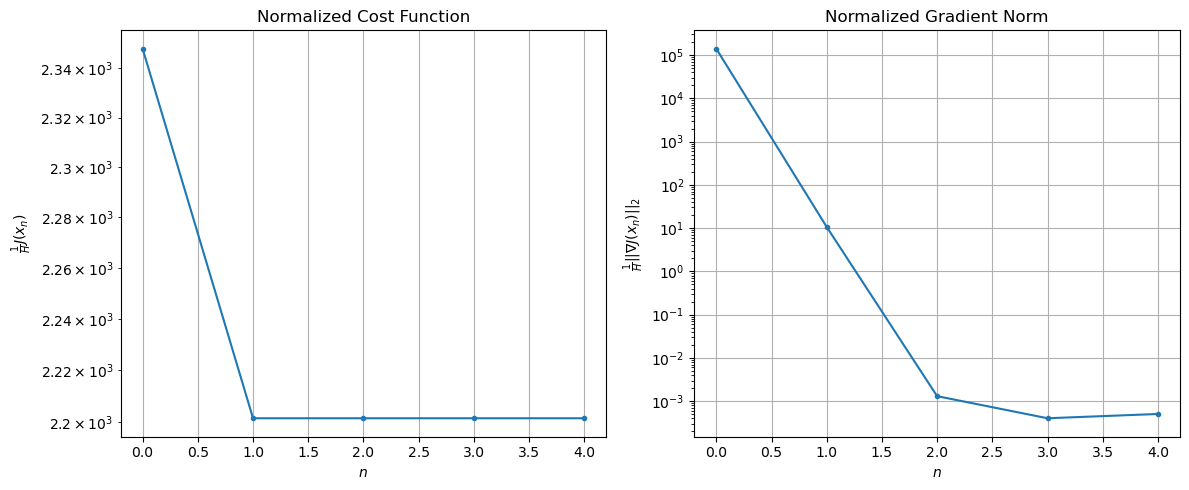

Before applying the algorithm
Cost function: 64030.34609921739
Gradient norm: 4431739.389298927
Global estimation error: 52.84834757618305
Initial conditions estimation errors: 12.502573672796254 m, 11.253147288036887 m, 31.09956254506628 m, 39.27859736109055 m
Position estimation errors: 14.354423657663231 m, 15.595520326672313 m, 11.496323032800436 m, 24.524802484203093 m

Iteration 1
Cost function: 59583.18158898452 (-6.95%)
Gradient norm: 410.44253533768295 (-99.99%)
Global estimation error: 65.35253836130742 (23.66%)
Initial conditions estimation errors: 15.259240235158392 m, 11.642135324652655 m, 37.831341864612725 m, 49.71267689677925 m
Position estimation errors: 11.37600565377831 m, 13.479076491041647 m, 15.344398319388397 m, 34.086632412839535 m

Iteration 2
Cost function: 59583.18050830217 (-0.00%)
Gradient norm: 0.11774454629140091 (-99.97%)
Global estimation error: 65.50408443265894 (0.23%)
Initial conditions estimation errors: 15.259240582137968 m, 11.648274864874283 m, 3

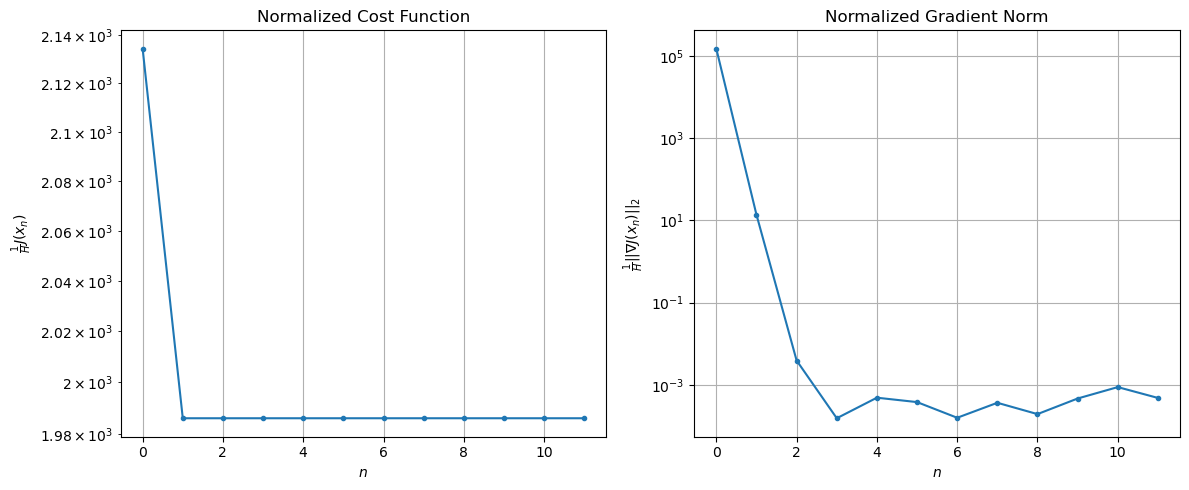

Before applying the algorithm
Cost function: 59472.24330129969
Gradient norm: 4885472.951587307
Global estimation error: 63.350035367560466
Initial conditions estimation errors: 11.910524461587501 m, 8.571110472082898 m, 36.35386968216338 m, 49.76232247908706 m
Position estimation errors: 14.968050706131523 m, 16.879649565950995 m, 15.247225876155635 m, 32.687372117264516 m

Iteration 1
Cost function: 54898.975705073244 (-7.69%)
Gradient norm: 4272.807677436906 (-99.91%)
Global estimation error: 36.26572557204197 (-42.75%)
Initial conditions estimation errors: 14.650096551323928 m, 12.653459399500669 m, 20.588584825900966 m, 22.728000870044017 m
Position estimation errors: 11.880884241999274 m, 13.094113030982015 m, 4.86079531347358 m, 7.124162023393637 m

Iteration 2
Cost function: 54898.87487548963 (-0.00%)
Gradient norm: 1.5694489287873392 (-99.96%)
Global estimation error: 35.8628587068243 (-1.11%)
Initial conditions estimation errors: 14.650096867014533 m, 12.672472741432172 m, 20

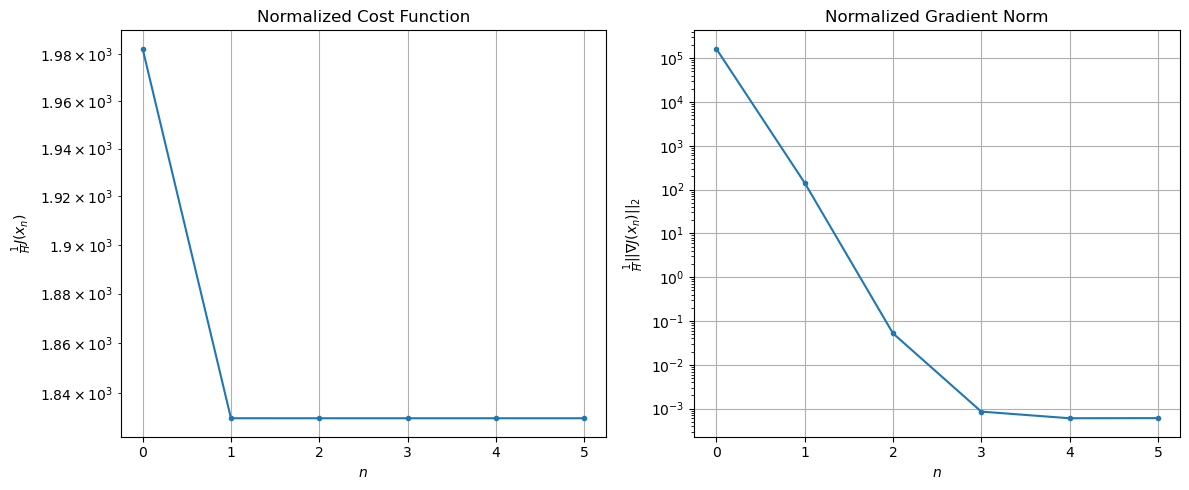

Before applying the algorithm
Cost function: 57345.14561471741
Gradient norm: 5274791.579498015
Global estimation error: 28.998050680101905
Initial conditions estimation errors: 11.11116100319046 m, 9.378526567292884 m, 16.902100924250817 m, 18.541195060306194 m
Position estimation errors: 15.917663599215551 m, 16.890322064669036 m, 7.385691780782905 m, 6.890427264559893 m

Iteration 1
Cost function: 52700.46344242056 (-8.10%)
Gradient norm: 1671.6115456153498 (-99.97%)
Global estimation error: 22.605263662692877 (-22.05%)
Initial conditions estimation errors: 13.81443195487582 m, 11.698679210805851 m, 10.581177354121625 m, 8.444855441617316 m
Position estimation errors: 12.732025071194172 m, 14.53216321909853 m, 13.188828535291552 m, 27.837626041761084 m

Iteration 2
Cost function: 52700.44776571632 (-0.00%)
Gradient norm: 0.6002384642214782 (-99.96%)
Global estimation error: 22.593642896882358 (-0.05%)
Initial conditions estimation errors: 13.81443223081967 m, 11.720273753929495 m, 1

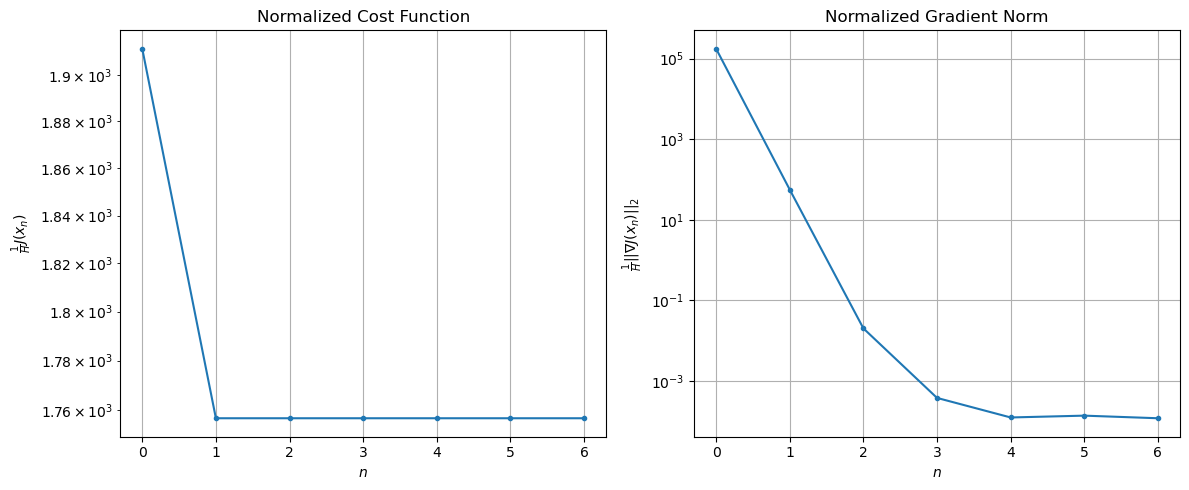

Before applying the algorithm
Cost function: 57611.05399524492
Gradient norm: 5737475.359676159
Global estimation error: 17.135703521210097
Initial conditions estimation errors: 10.212668682942839 m, 8.371127900691306 m, 7.144885345340156 m, 8.257548621934944 m
Position estimation errors: 17.179495423293773 m, 18.683691888872918 m, 12.676142411175027 m, 25.437734547956175 m

Iteration 1
Cost function: 52664.20895128445 (-8.59%)
Gradient norm: 131.57803257721227 (-100.00%)
Global estimation error: 20.482382670432198 (19.53%)
Initial conditions estimation errors: 12.954770954355743 m, 9.761733091157359 m, 10.400289178685293 m, 6.944305587432326 m
Position estimation errors: 13.819037930233401 m, 16.605745164796243 m, 11.47162723455153 m, 20.56008847312705 m

Iteration 2
Cost function: 52664.20884455518 (-0.00%)
Gradient norm: 0.024988292604956802 (-99.98%)
Global estimation error: 20.49755935847388 (0.07%)
Initial conditions estimation errors: 12.954771194974416 m, 9.768640203745017 m, 1

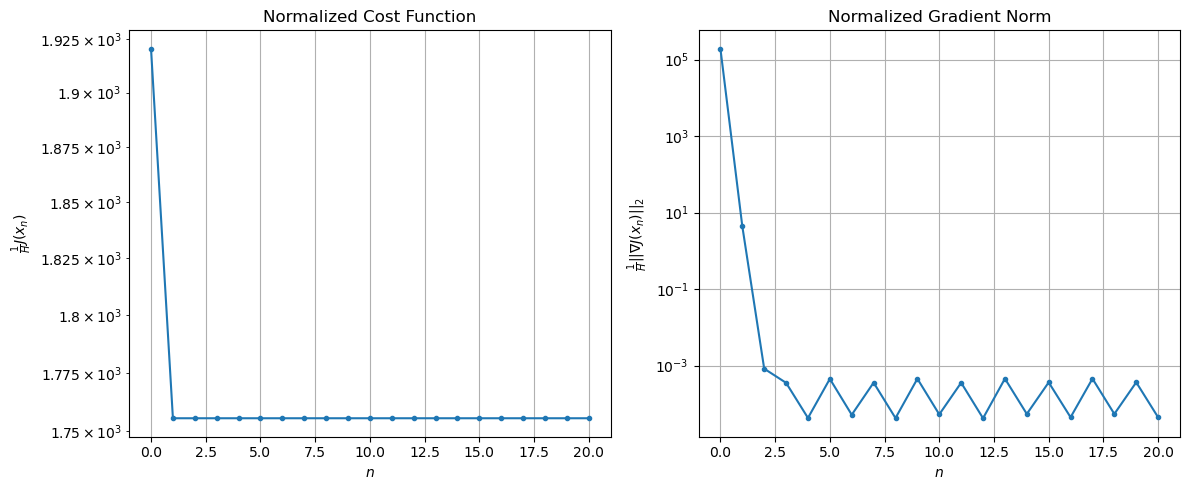

Before applying the algorithm
Cost function: 61586.7957820312
Gradient norm: 6244429.962216341
Global estimation error: 14.821598595364321
Initial conditions estimation errors: 9.41790584585219 m, 6.697249253007145 m, 6.924144959008041 m, 6.178013055962702 m
Position estimation errors: 18.596162973438325 m, 21.11682589636652 m, 9.973373494583281 m, 17.587770445021377 m

Iteration 1
Cost function: 56348.69224414951 (-8.51%)
Gradient norm: 86.12335051957639 (-100.00%)
Global estimation error: 19.304460918173767 (30.25%)
Initial conditions estimation errors: 12.161068752138327 m, 9.373720882843164 m, 8.11704009781822 m, 8.426005758687934 m
Position estimation errors: 15.048259075506527 m, 15.934962494391081 m, 10.183158210876611 m, 20.104618343265887 m

Iteration 2
Cost function: 56348.692209289766 (-0.00%)
Gradient norm: 0.015844671413384425 (-99.98%)
Global estimation error: 19.29911559457192 (-0.03%)
Initial conditions estimation errors: 12.161068960912097 m, 9.370907645683385 m, 8.119

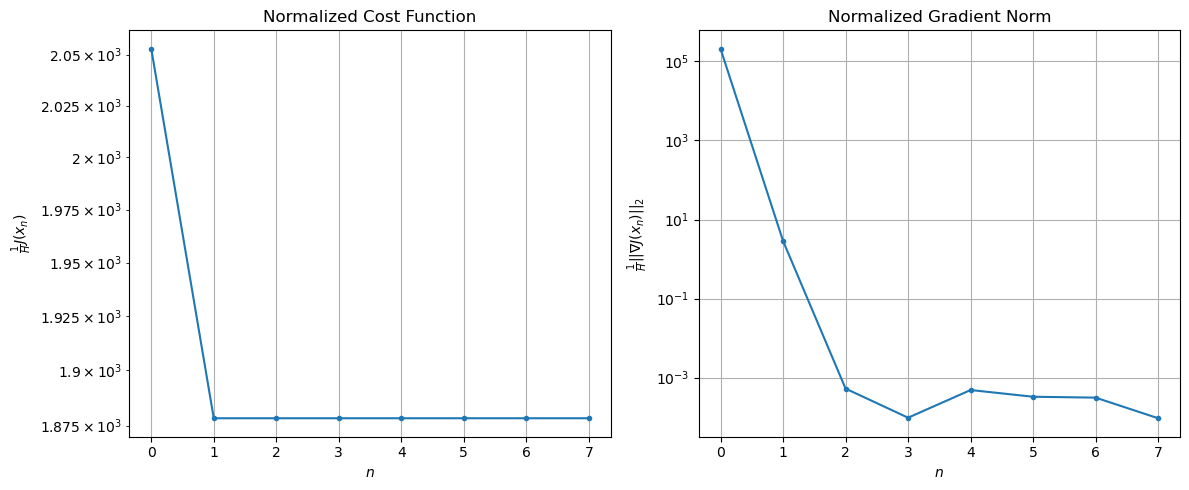

Before applying the algorithm
Cost function: 69098.71314398677
Gradient norm: 6691203.315355595
Global estimation error: 15.400722593756544
Initial conditions estimation errors: 8.77958819103628 m, 6.35379884475651 m, 5.6975996119272345 m, 9.340843888617725 m
Position estimation errors: 20.08655335864117 m, 20.851470437951942 m, 11.09994620198808 m, 18.152846157921807 m

Iteration 1
Cost function: 63535.285856629016 (-8.05%)
Gradient norm: 2407.958382011356 (-99.96%)
Global estimation error: 36.90762698629517 (139.65%)
Initial conditions estimation errors: 11.518116351277577 m, 15.842608272421943 m, 15.09257426876895 m, 27.39898394169921 m
Position estimation errors: 16.35171459770794 m, 13.61220065926338 m, 18.97821923005735 m, 46.544830337047266 m

Iteration 2
Cost function: 63535.25461502658 (-0.00%)
Gradient norm: 0.10670807429662993 (-100.00%)
Global estimation error: 36.97455413584288 (0.18%)
Initial conditions estimation errors: 11.518116548879242 m, 15.894687206569674 m, 15.104

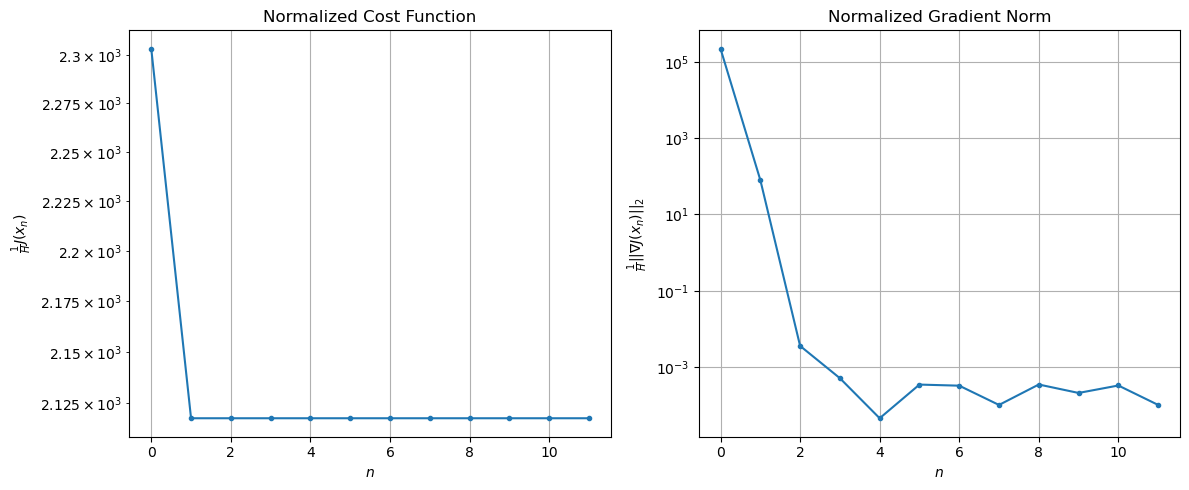

Before applying the algorithm
Cost function: 79947.03574242939
Gradient norm: 6963559.079702093
Global estimation error: 39.78770282043845
Initial conditions estimation errors: 8.348713652156603 m, 12.680410993623921 m, 17.170127841766867 m, 32.522789318826504 m
Position estimation errors: 21.58762825658078 m, 18.538764465943427 m, 19.840114933843385 m, 43.103634398483 m

Iteration 1
Cost function: 74090.50089127154 (-7.33%)
Gradient norm: 970.1938106880822 (-99.99%)
Global estimation error: 28.730712960956765 (-27.79%)
Initial conditions estimation errors: 11.102134625407208 m, 12.39561671996181 m, 11.230918213931414 m, 20.552208831278865 m
Position estimation errors: 17.71798962266622 m, 16.4699620232213 m, 14.558826391773845 m, 27.133891386402258 m

Iteration 2
Cost function: 74090.495781687 (-0.00%)
Gradient norm: 0.029176806767581262 (-100.00%)
Global estimation error: 28.699478897896977 (-0.11%)
Initial conditions estimation errors: 11.102134818484112 m, 12.391942337619307 m, 11.

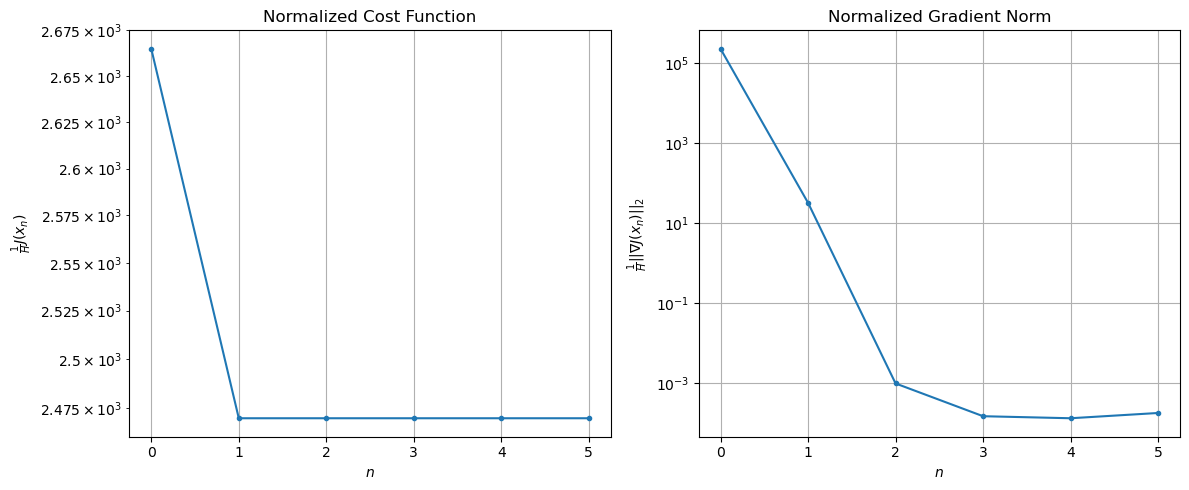

Before applying the algorithm
Cost function: 94537.75015612728
Gradient norm: 7247879.4097047495
Global estimation error: 29.01085674614652
Initial conditions estimation errors: 8.17642911197359 m, 9.409279512647096 m, 11.772620791605776 m, 23.401553693750564 m
Position estimation errors: 23.08126214865481 m, 21.787255622024446 m, 18.04360245836063 m, 26.862464322217505 m

Iteration 1
Cost function: 88198.8597005921 (-6.71%)
Gradient norm: 314.47627360230894 (-100.00%)
Global estimation error: 25.401489910013133 (-12.44%)
Initial conditions estimation errors: 10.981089166333804 m, 11.022600355305435 m, 9.479892492972427 m, 17.69950371965668 m
Position estimation errors: 19.041658355264065 m, 18.769263474430584 m, 15.224001434448025 m, 18.435108731572043 m

Iteration 2
Cost function: 88198.85924127483 (-0.00%)
Gradient norm: 0.018471822583723856 (-99.99%)
Global estimation error: 25.35354714405915 (-0.19%)
Initial conditions estimation errors: 10.98108937010249 m, 11.018607477882288 m, 

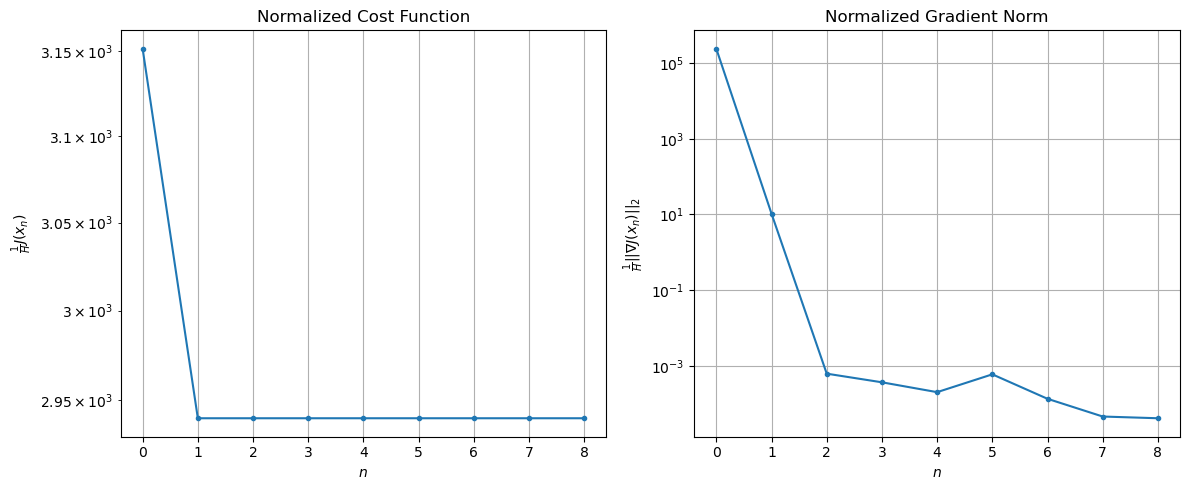

Before applying the algorithm
Cost function: 112006.47799903143
Gradient norm: 7265997.150076896
Global estimation error: 24.63800566268254
Initial conditions estimation errors: 8.3094935442889 m, 8.34886189015454 m, 8.831501211282852 m, 19.755388577079582 m
Position estimation errors: 24.427256783945246 m, 24.177661867816507 m, 20.05733535856328 m, 22.073373324639142 m

Iteration 1
Cost function: 105229.63804195142 (-6.05%)
Gradient norm: 805.098397296418 (-99.99%)
Global estimation error: 20.820021491637792 (-15.50%)
Initial conditions estimation errors: 11.191946114822809 m, 12.496910347388624 m, 8.469609962392758 m, 8.960925891375231 m
Position estimation errors: 20.283375541926905 m, 20.310119308837407 m, 21.66544122764077 m, 21.258467936789327 m

Iteration 2
Cost function: 105229.63422267808 (-0.00%)
Gradient norm: 0.11263434279457478 (-99.99%)
Global estimation error: 20.817817598185037 (-0.01%)
Initial conditions estimation errors: 11.191946344711058 m, 12.511173697664836 m, 8.

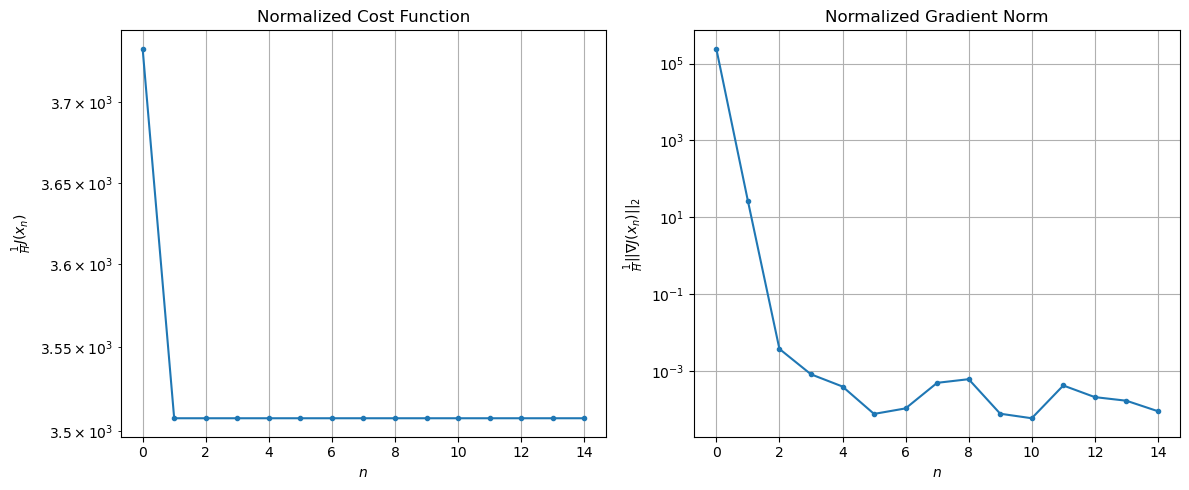

Before applying the algorithm
Cost function: 131564.1436572586
Gradient norm: 7099721.511987999
Global estimation error: 16.728659262794242
Initial conditions estimation errors: 8.746666607558303 m, 10.058436068304857 m, 6.189054828581493 m, 7.991335285368885 m
Position estimation errors: 25.601760292794314 m, 25.668506917646997 m, 27.16559173561844 m, 27.31580349434042 m

Iteration 1
Cost function: 124402.87973128576 (-5.44%)
Gradient norm: 1698.725460673472 (-99.98%)
Global estimation error: 35.15050742549143 (110.12%)
Initial conditions estimation errors: 11.72075843395527 m, 15.32951998425168 m, 13.369024971254616 m, 26.16192658247383 m
Position estimation errors: 21.407101497572338 m, 19.378632895773066 m, 22.925074213312946 m, 26.037976115073228 m

Iteration 2
Cost function: 124402.86205995509 (-0.00%)
Gradient norm: 0.02987984586382012 (-100.00%)
Global estimation error: 35.11349087544691 (-0.11%)
Initial conditions estimation errors: 11.720758697239974 m, 15.313416251882382 m, 

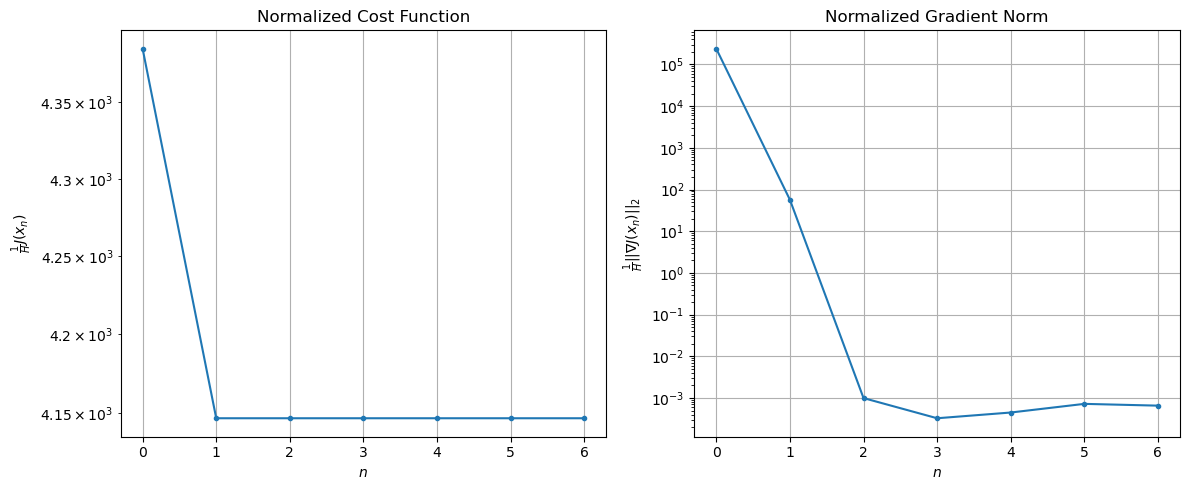

Before applying the algorithm
Cost function: 152739.21587873023
Gradient norm: 6859249.858804306
Global estimation error: 35.579473878219545
Initial conditions estimation errors: 9.444144583345714 m, 12.980781196140848 m, 13.741770286870523 m, 28.624502354870504 m
Position estimation errors: 26.61993844503703 m, 24.43017733344132 m, 28.37959694821352 m, 30.044220629699755 m

Iteration 1
Cost function: 145151.76251198255 (-4.97%)
Gradient norm: 7290.504095191098 (-99.89%)
Global estimation error: 22.651225845421074 (-36.34%)
Initial conditions estimation errors: 12.548028243945256 m, 10.955900290336514 m, 12.051475677979013 m, 9.505261851286354 m
Position estimation errors: 22.403783996330514 m, 27.363105792932274 m, 32.39347683945293 m, 57.13032481254774 m

Iteration 2
Cost function: 145151.5326681937 (-0.00%)
Gradient norm: 1.9595329592318342 (-99.97%)
Global estimation error: 22.701106151062028 (0.22%)
Initial conditions estimation errors: 12.548028548918449 m, 11.032806086948561 m, 

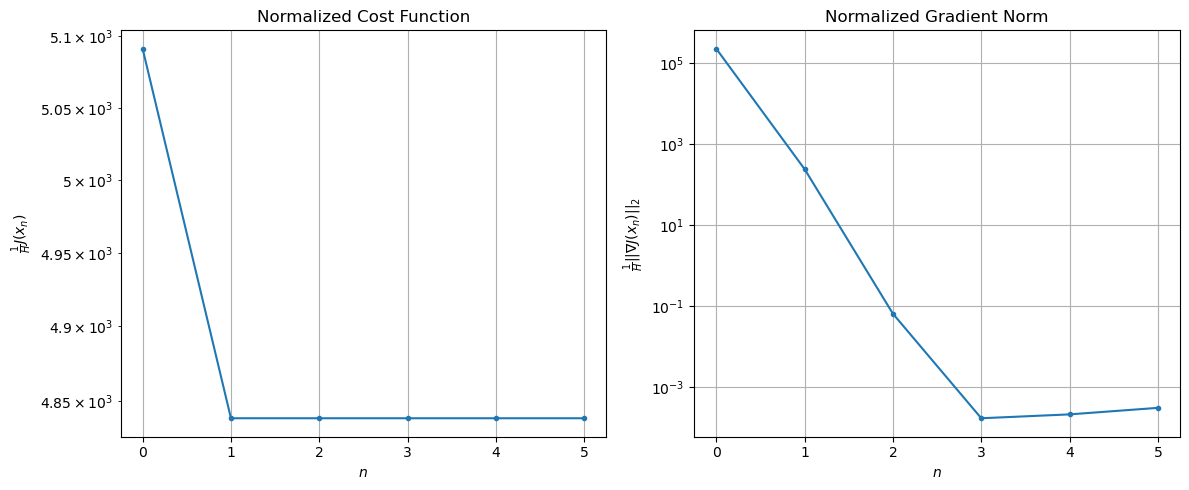

Before applying the algorithm
Cost function: 175078.95951673097
Gradient norm: 6387075.202042523
Global estimation error: 18.79674429164161
Initial conditions estimation errors: 10.369472168568617 m, 9.016656836996997 m, 9.975241821046184 m, 8.061153056446313 m
Position estimation errors: 27.525049234843742 m, 32.557084286136785 m, 37.74176090913295 m, 61.76131131819927 m

Iteration 1
Cost function: 167033.0963317164 (-4.60%)
Gradient norm: 589.6197127957602 (-99.99%)
Global estimation error: 25.868875365316097 (37.62%)
Initial conditions estimation errors: 13.636800155140236 m, 11.260867926384492 m, 16.72253548146547 m, 8.762443181743556 m
Position estimation errors: 23.303546920082713 m, 30.764402728807553 m, 34.92414011349037 m, 72.28901116109378 m

Iteration 2
Cost function: 167033.09494275146 (-0.00%)
Gradient norm: 0.03232765989638532 (-99.99%)
Global estimation error: 25.855708321905592 (-0.05%)
Initial conditions estimation errors: 13.636800522005153 m, 11.268364220140043 m, 16

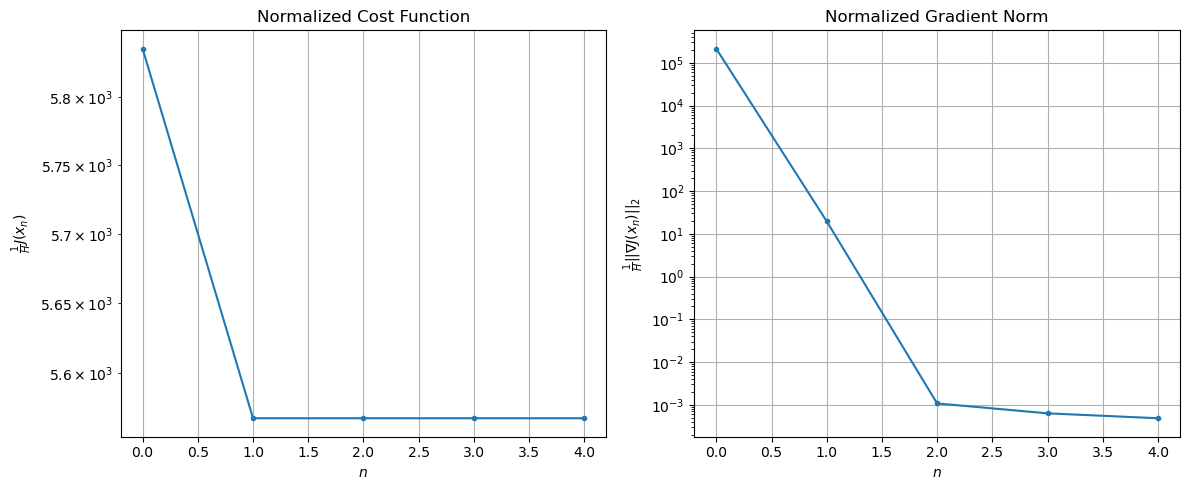

Before applying the algorithm
Cost function: 198068.05791694525
Gradient norm: 5792597.676866477
Global estimation error: 22.700625940178533
Initial conditions estimation errors: 11.481909698681946 m, 9.40475085502137 m, 15.257175728902677 m, 7.88978268546175 m
Position estimation errors: 28.35122100271387 m, 35.99642310572237 m, 39.94950423479873 m, 76.61166058029151 m

Iteration 1
Cost function: 189548.44803964425 (-4.30%)
Gradient norm: 59.00437413632137 (-100.00%)
Global estimation error: 33.398830327622136 (47.13%)
Initial conditions estimation errors: 14.950217974148224 m, 11.902922623022103 m, 21.880113662239765 m, 16.478716233712326 m
Position estimation errors: 24.15028771952995 m, 32.768579065705225 m, 34.11591676792974 m, 72.26919134358924 m

Iteration 2
Cost function: 189548.4479885461 (-0.00%)
Gradient norm: 0.015119294686411034 (-99.97%)
Global estimation error: 33.40647514627824 (0.02%)
Initial conditions estimation errors: 14.950218405552656 m, 11.898637608319731 m, 21.

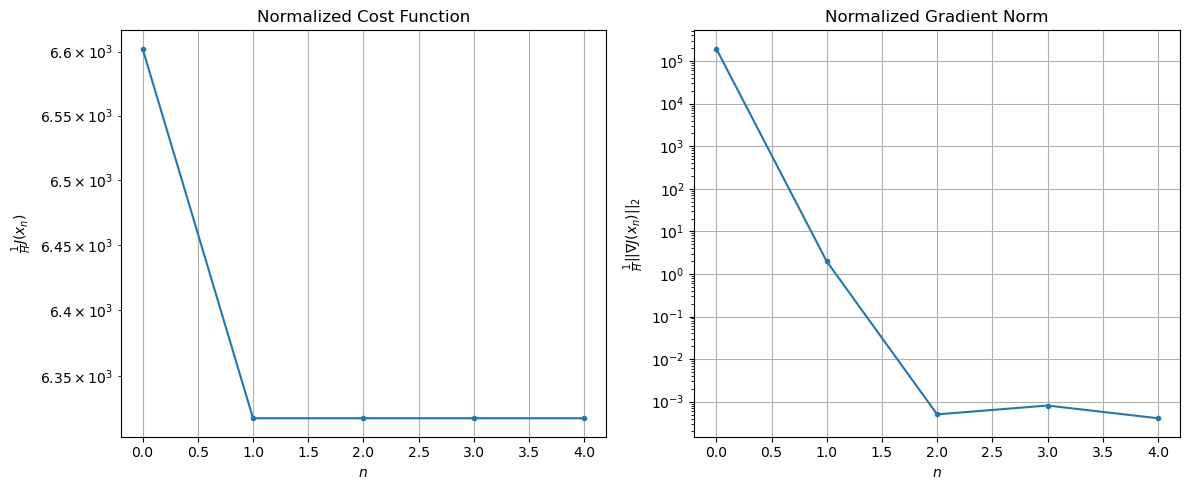

Before applying the algorithm
Cost function: 220735.452498956
Gradient norm: 5246988.011890905
Global estimation error: 31.440677948120356
Initial conditions estimation errors: 12.73158522040046 m, 10.066280007715688 m, 20.53813979223192 m, 17.41472101627599 m
Position estimation errors: 29.125667219864102 m, 37.92136480947557 m, 38.73462389834773 m, 75.87536137085709 m

Iteration 1
Cost function: 211604.78678808874 (-4.14%)
Gradient norm: 1923.2144765392666 (-99.96%)
Global estimation error: 44.8186067095782 (42.55%)
Initial conditions estimation errors: 16.426065324182293 m, 12.924162482532685 m, 31.233399240874903 m, 24.41973078278185 m
Position estimation errors: 24.91992992739825 m, 37.47688352485905 m, 38.91989033739149 m, 99.78557549242925 m

Iteration 2
Cost function: 211604.77204913332 (-0.00%)
Gradient norm: 0.1535477603400363 (-99.99%)
Global estimation error: 44.91375491222881 (0.21%)
Initial conditions estimation errors: 16.426065842311885 m, 12.909414350809554 m, 31.31419

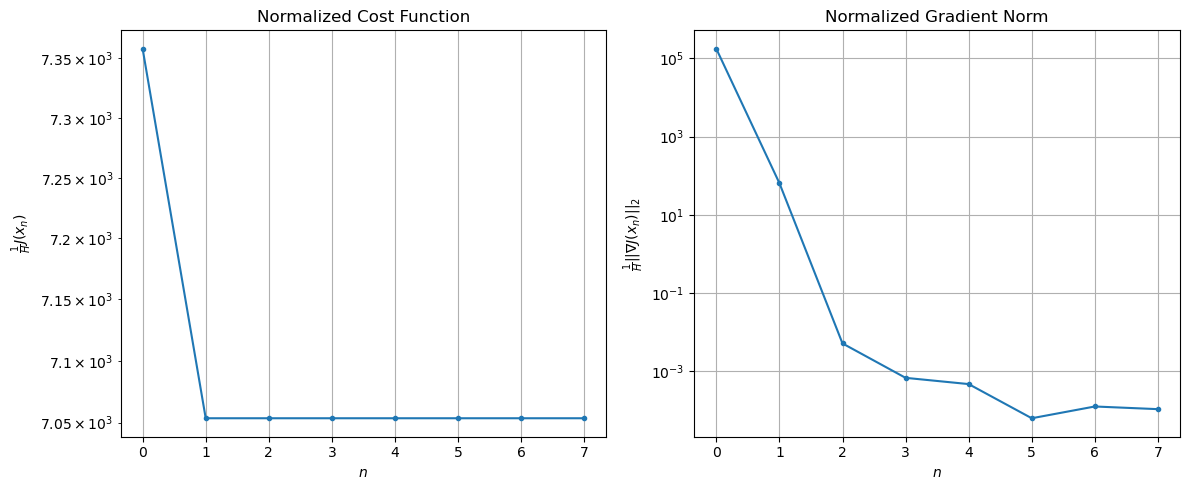

Before applying the algorithm
Cost function: 242745.22760702518
Gradient norm: 4616597.603486072
Global estimation error: 44.813142147365674
Initial conditions estimation errors: 14.058729455542272 m, 11.136274009376955 m, 30.233935256816675 m, 27.79304185521142 m
Position estimation errors: 29.813152878788323 m, 42.52002127275521 m, 42.8926940296971 m, 102.16320342451765 m

Iteration 1
Cost function: 232887.40800280383 (-4.06%)
Gradient norm: 11579.75002990904 (-99.75%)
Global estimation error: 44.39518106100296 (-0.93%)
Initial conditions estimation errors: 17.98798621377936 m, 21.052563856981813 m, 19.632351809880962 m, 28.613233781756346 m
Position estimation errors: 25.575273833759038 m, 24.510163239562548 m, 26.202315294661908 m, 28.588729326569343 m

Iteration 2
Cost function: 232886.87877707533 (-0.00%)
Gradient norm: 0.08588913283949644 (-100.00%)
Global estimation error: 44.34845917229967 (-0.11%)
Initial conditions estimation errors: 17.98798683446718 m, 21.024844635344504 m

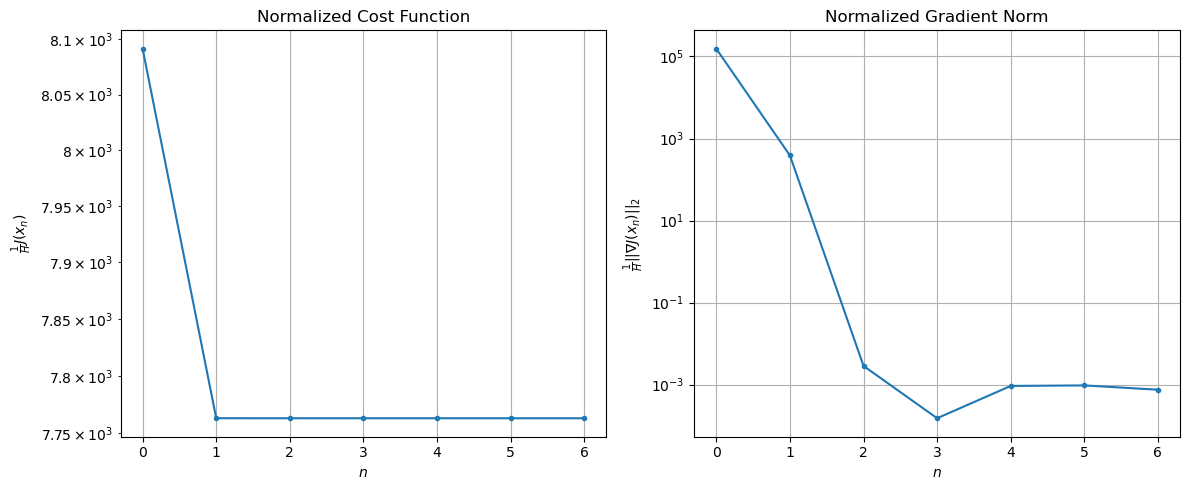

Before applying the algorithm
Cost function: 263281.59946215263
Gradient norm: 3927453.2768633403
Global estimation error: 39.83585284485752
Initial conditions estimation errors: 15.411072301683038 m, 18.60553729194405 m, 17.562883899020843 m, 26.358401072588816 m
Position estimation errors: 30.39007076920395 m, 29.086057887659656 m, 30.753911349035505 m, 32.738278819513525 m

Iteration 1
Cost function: 252924.85462968852 (-3.93%)
Gradient norm: 169.67357780977727 (-100.00%)
Global estimation error: 44.06528974126541 (10.62%)
Initial conditions estimation errors: 19.500501546573965 m, 23.97192129686971 m, 18.401873117031823 m, 25.459535520106844 m
Position estimation errors: 26.150903015215487 m, 22.169018944093615 m, 26.1391574299183 m, 23.20587715080896 m

Iteration 2
Cost function: 252924.85443959292 (-0.00%)
Gradient norm: 0.01836253544450225 (-99.99%)
Global estimation error: 44.0317303330187 (-0.08%)
Initial conditions estimation errors: 19.500502259843554 m, 23.9599577939925 m, 

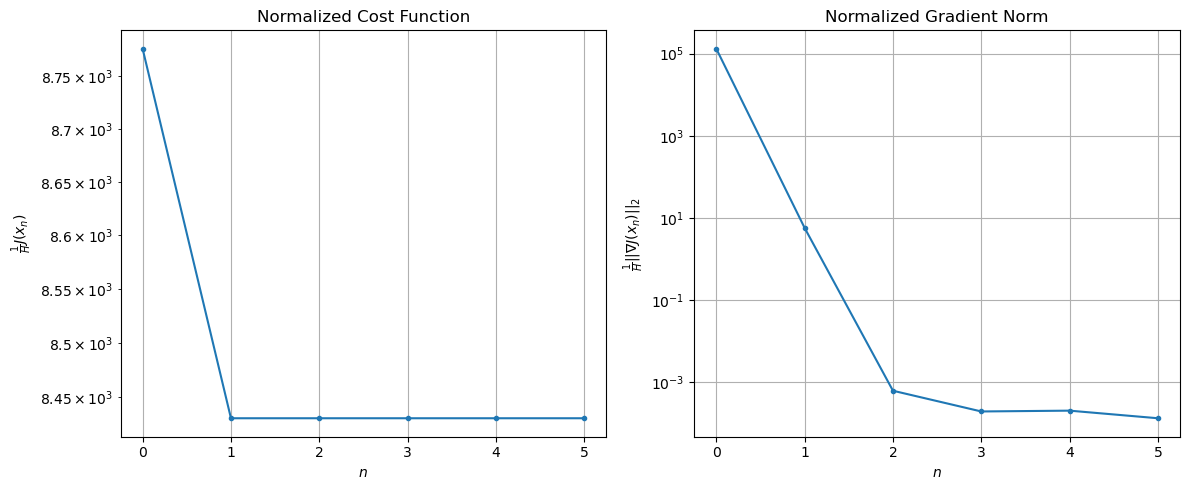

Before applying the algorithm
Cost function: 280967.63907237863
Gradient norm: 3345249.871430644
Global estimation error: 38.48111479504785
Initial conditions estimation errors: 16.685552334842082 m, 21.171484088908006 m, 15.956239849939655 m, 22.350494184013574 m
Position estimation errors: 30.918307078260977 m, 26.566021215931706 m, 30.863665893930342 m, 27.532623692045014 m

Iteration 1
Cost function: 269927.03538604133 (-3.93%)
Gradient norm: 57.13723125051997 (-100.00%)
Global estimation error: 50.54170659768014 (31.34%)
Initial conditions estimation errors: 20.9752466630373 m, 26.49267114637527 m, 21.620652584314467 m, 30.74370857166687 m
Position estimation errors: 26.646464302742572 m, 20.571346523909845 m, 23.970894129833482 m, 16.44283493111494 m

Iteration 2
Cost function: 269927.03533867403 (-0.00%)
Gradient norm: 0.020060419449517544 (-99.96%)
Global estimation error: 50.586007191667676 (0.09%)
Initial conditions estimation errors: 20.975247487528822 m, 26.497993274945937 

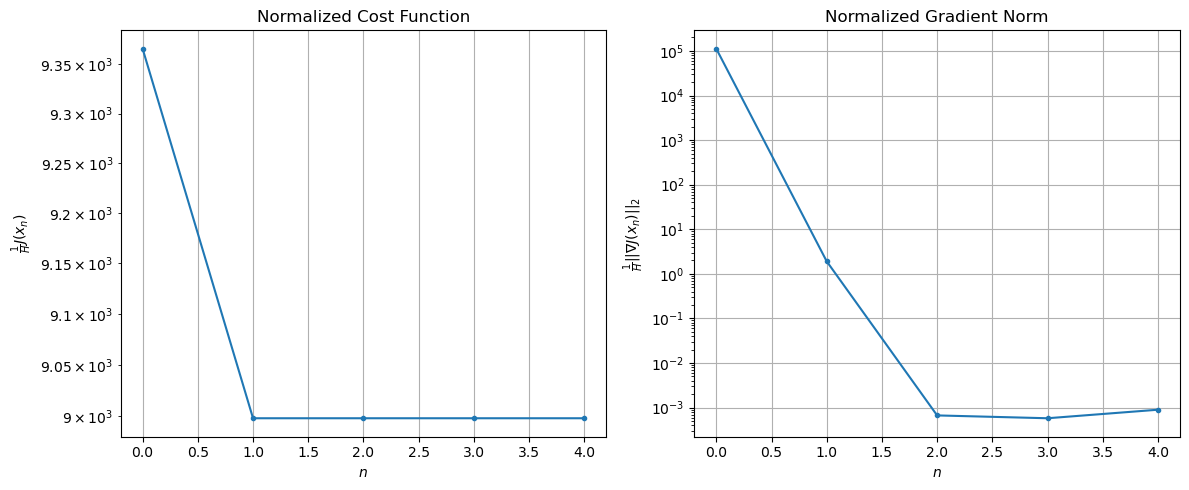

Before applying the algorithm
Cost function: 297092.05940084375
Gradient norm: 2988034.5430792533
Global estimation error: 44.363557587965076
Initial conditions estimation errors: 17.910502152701774 m, 23.399634239173512 m, 18.87593342287152 m, 27.266862795095047 m
Position estimation errors: 31.41237577064039 m, 24.998080449913225 m, 28.711752936827363 m, 20.386679283679257 m

Iteration 1
Cost function: 285238.9375216788 (-3.99%)
Gradient norm: 21.847239832616523 (-100.00%)
Global estimation error: 49.36352026198558 (11.27%)
Initial conditions estimation errors: 22.3797677655954 m, 27.56947089075247 m, 21.503312911320315 m, 26.709912943448963 m
Position estimation errors: 27.049517756474263 m, 21.152920213284 m, 26.41471565462793 m, 20.316533159577986 m

Iteration 2
Cost function: 285238.93750021566 (-0.00%)
Gradient norm: 0.019515427553696743 (-99.91%)
Global estimation error: 49.32031559514071 (-0.09%)
Initial conditions estimation errors: 22.3797686931701 m, 27.55804878032673 m, 21

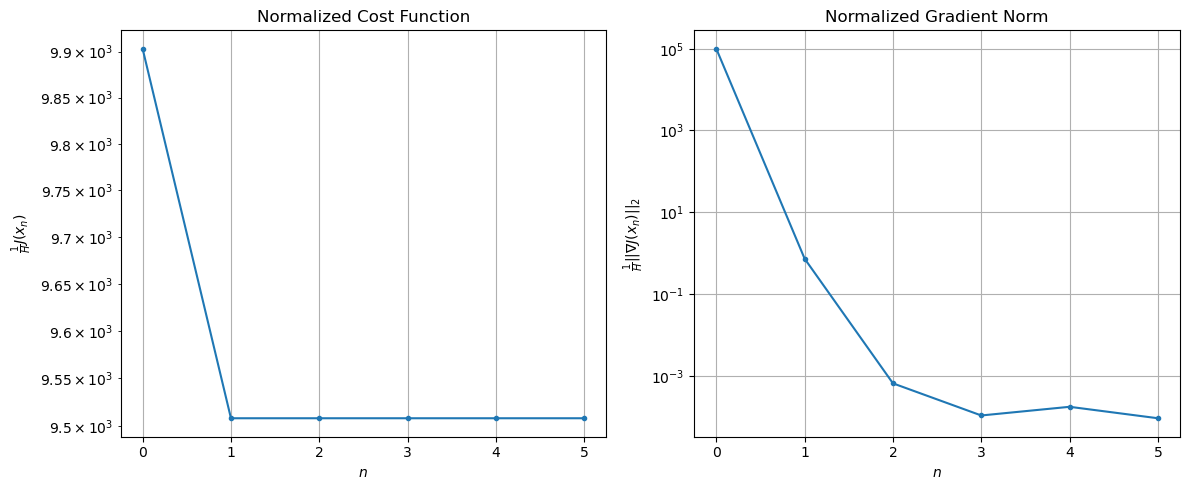

Before applying the algorithm
Cost function: 310704.93058358075
Gradient norm: 2860495.8786975653
Global estimation error: 42.59255831013532
Initial conditions estimation errors: 19.072639067765525 m, 24.16446462980521 m, 18.43818061592262 m, 22.944654315777704 m
Position estimation errors: 31.858340342632484 m, 25.68125088945389 m, 31.346466270745466 m, 24.79516163869836 m

Iteration 1
Cost function: 298104.47944600956 (-4.06%)
Gradient norm: 67.92646344429942 (-100.00%)
Global estimation error: 53.15680446853995 (24.80%)
Initial conditions estimation errors: 23.670774957467643 m, 28.268886402464215 m, 24.798806441965578 m, 29.175544573229253 m
Position estimation errors: 27.382618083606292 m, 22.616473257041047 m, 26.35286202301446 m, 23.572433947366648 m

Iteration 2
Cost function: 298104.4794389192 (-0.00%)
Gradient norm: 0.015252881265898436 (-99.98%)
Global estimation error: 53.16204726990572 (0.01%)
Initial conditions estimation errors: 23.670775978464018 m, 28.27440990919352 m,

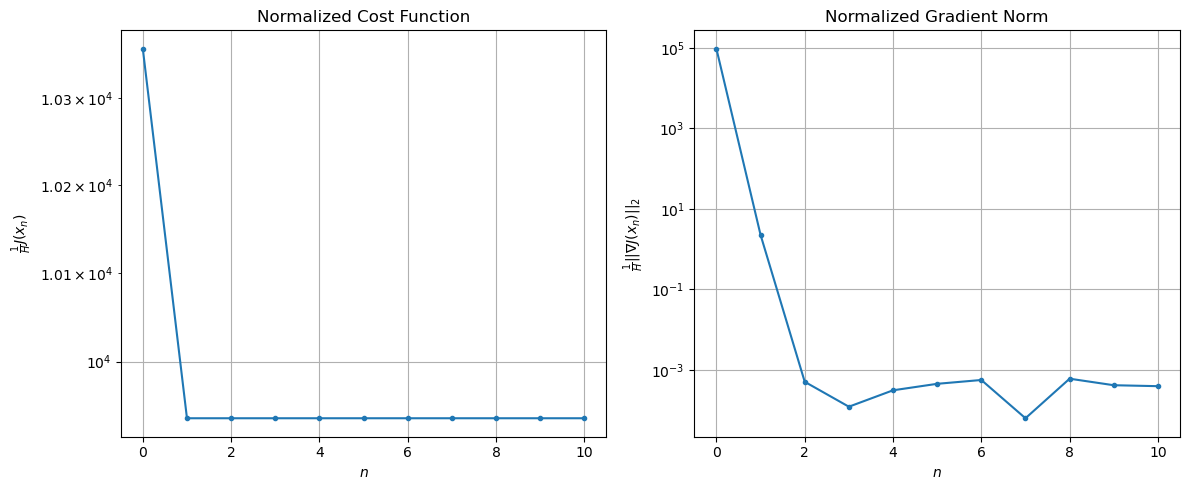

Before applying the algorithm
Cost function: 321832.46731301234
Gradient norm: 2977617.0597655075
Global estimation error: 46.19145840625081
Initial conditions estimation errors: 20.142070719249162 m, 24.693915389281077 m, 21.476885139771127 m, 25.629767126939477 m
Position estimation errors: 32.265861407946495 m, 27.272093674594014 m, 31.219273184995163 m, 28.077595114826167 m

Iteration 1
Cost function: 308428.2026379385 (-4.16%)
Gradient norm: 16.718414542967604 (-100.00%)
Global estimation error: 51.58847957974879 (11.68%)
Initial conditions estimation errors: 24.863437853506387 m, 28.243531558176397 m, 25.202645549551484 m, 24.70407619734902 m
Position estimation errors: 27.652189728666855 m, 23.714162737528707 m, 27.93925800265252 m, 27.340691898477445 m

Iteration 2
Cost function: 308428.202622415 (-0.00%)
Gradient norm: 0.022480518044971483 (-99.87%)
Global estimation error: 51.5639801516443 (-0.05%)
Initial conditions estimation errors: 24.863438931763728 m, 28.237864584106873

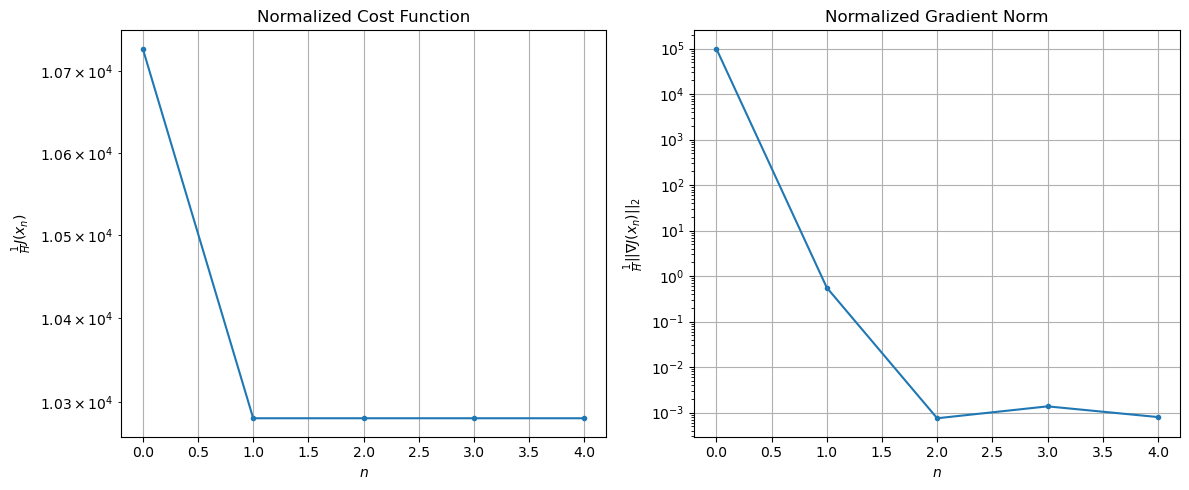

Before applying the algorithm
Cost function: 330670.59375628404
Gradient norm: 3252060.285751887
Global estimation error: 44.14131078500851
Initial conditions estimation errors: 21.122051267180712 m, 24.4236267712204 m, 21.550786292110647 m, 21.00823829555974 m
Position estimation errors: 32.613113585168776 m, 28.52029355510326 m, 32.924799393493664 m, 32.31112326082155 m

Iteration 1
Cost function: 316582.8760304062 (-4.26%)
Gradient norm: 40.729012469536244 (-100.00%)
Global estimation error: 51.64064050643553 (16.99%)
Initial conditions estimation errors: 25.92831736429685 m, 27.96247674586125 m, 27.72543280644973 m, 21.06793373441947 m
Position estimation errors: 27.8634619228171 m, 25.144001270207877 m, 27.936464380083073 m, 32.38858836115127 m

Iteration 2
Cost function: 316582.8760190154 (-0.00%)
Gradient norm: 0.003607942138404684 (-99.99%)
Global estimation error: 51.63664056083942 (-0.01%)
Initial conditions estimation errors: 25.928318457045414 m, 27.963145257696468 m, 27.72

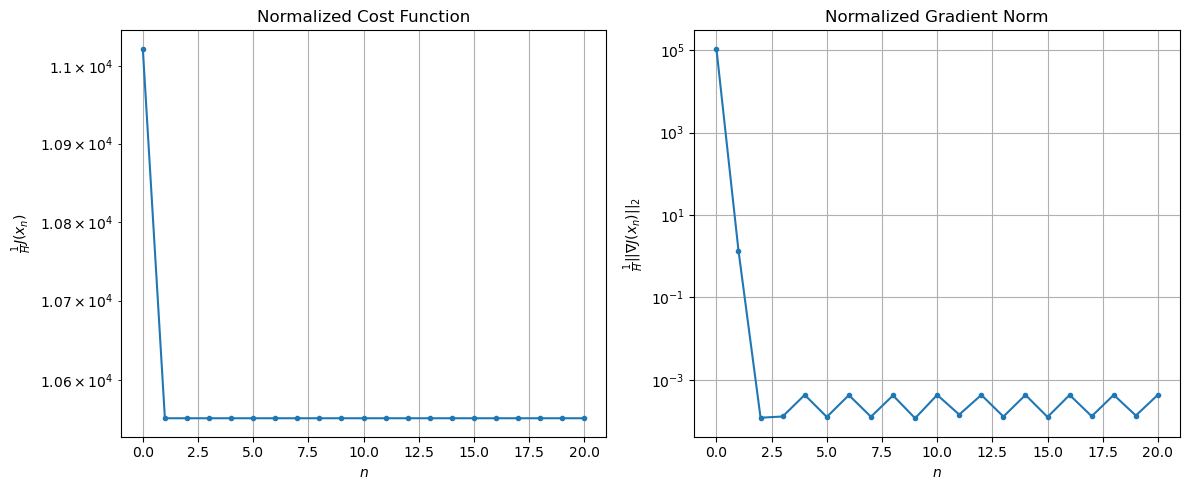

Before applying the algorithm
Cost function: 335990.7590759005
Gradient norm: 3545694.146005723
Global estimation error: 43.82599839180731
Initial conditions estimation errors: 21.976698311446103 m, 23.933140936896624 m, 23.648979871692653 m, 17.482951260075094 m
Position estimation errors: 32.87298644573897 m, 30.139364723994028 m, 32.844486818777426 m, 37.750381518238456 m

Iteration 1
Cost function: 321206.78340621263 (-4.40%)
Gradient norm: 15.390657665094661 (-100.00%)
Global estimation error: 55.70880046166666 (27.11%)
Initial conditions estimation errors: 26.8668685960165 m, 28.364290150322542 m, 29.492696457493718 m, 26.594499384008564 m
Position estimation errors: 27.974516149413333 m, 26.44928454353034 m, 27.284058011484284 m, 31.178988802916603 m

Iteration 2
Cost function: 321206.78339061455 (-0.00%)
Gradient norm: 0.007828771824191196 (-99.95%)
Global estimation error: 55.726859239138655 (0.03%)
Initial conditions estimation errors: 26.866869657200112 m, 28.371621544359176

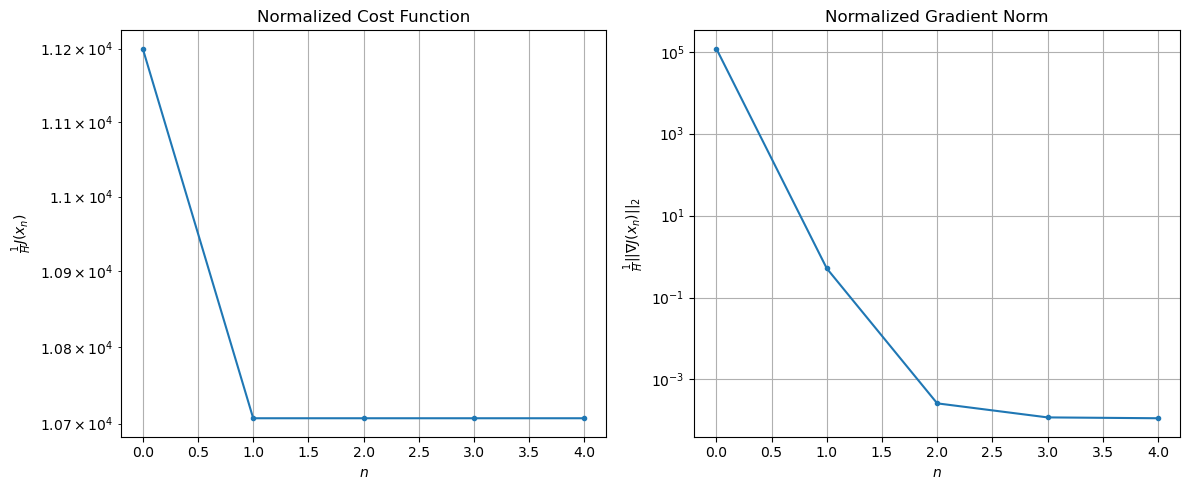

Before applying the algorithm
Cost function: 339669.678550702
Gradient norm: 3903398.7713816487
Global estimation error: 47.54138806695717
Initial conditions estimation errors: 22.713419039518683 m, 24.192377574198 m, 25.264031233384177 m, 22.819293636999426 m
Position estimation errors: 32.98044197833673 m, 31.494443590846636 m, 32.10519543763185 m, 36.253857090572254 m

Iteration 1
Cost function: 324430.93075296533 (-4.49%)
Gradient norm: 47.00482998681771 (-100.00%)
Global estimation error: 54.498280378351254 (14.63%)
Initial conditions estimation errors: 27.627356552035714 m, 27.35682451981192 m, 31.02166811154813 m, 22.271691615464317 m
Position estimation errors: 27.954271081641448 m, 28.211155902553106 m, 27.332580707041465 m, 36.81206776678151 m

Iteration 2
Cost function: 324430.9307240994 (-0.00%)
Gradient norm: 0.022206636224902987 (-99.95%)
Global estimation error: 54.48305698620678 (-0.03%)
Initial conditions estimation errors: 27.627357523837567 m, 27.35146056807807 m, 31

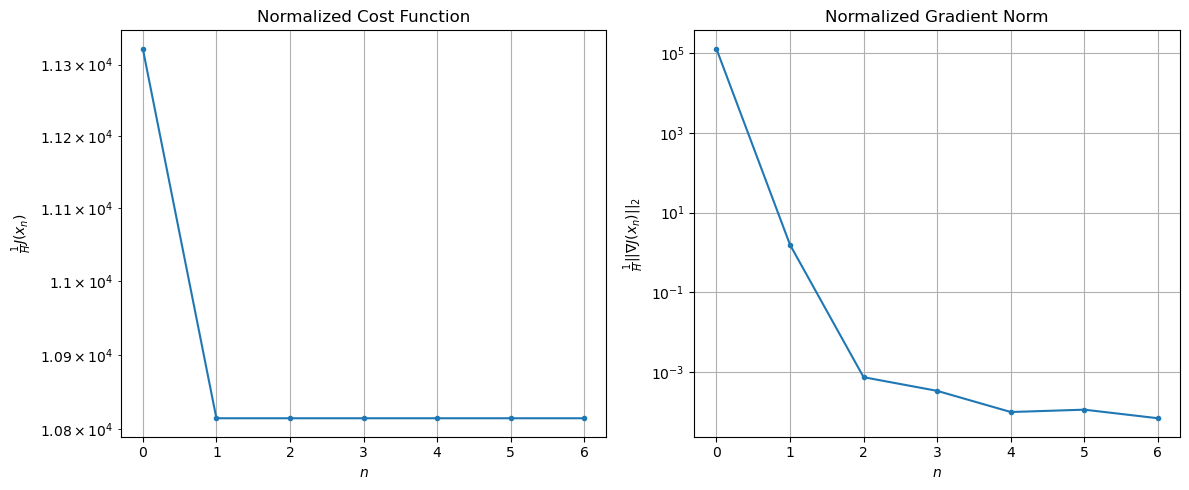

Before applying the algorithm
Cost function: 340900.1575649873
Gradient norm: 4197567.299792749
Global estimation error: 46.02387987652586
Initial conditions estimation errors: 23.28926746455144 m, 23.01691143499205 m, 26.45373093157216 m, 18.606625681902212 m
Position estimation errors: 32.90897607696714 m, 33.3207814946438 m, 31.911205050627967 m, 42.25817549933625 m

Iteration 1
Cost function: 325245.62129446893 (-4.59%)
Gradient norm: 143.34834806997105 (-100.00%)
Global estimation error: 52.834588007085856 (14.80%)
Initial conditions estimation errors: 28.22782494803577 m, 27.154944587365524 m, 30.075068318639676 m, 18.78180491669515 m
Position estimation errors: 27.76644461081475 m, 27.025675620046727 m, 27.85476958933729 m, 32.38003418864833 m

Iteration 2
Cost function: 325245.62117750687 (-0.00%)
Gradient norm: 0.008627199798888421 (-99.99%)
Global estimation error: 52.84426885665654 (0.02%)
Initial conditions estimation errors: 28.227825787623214 m, 27.157167088103403 m, 30.0

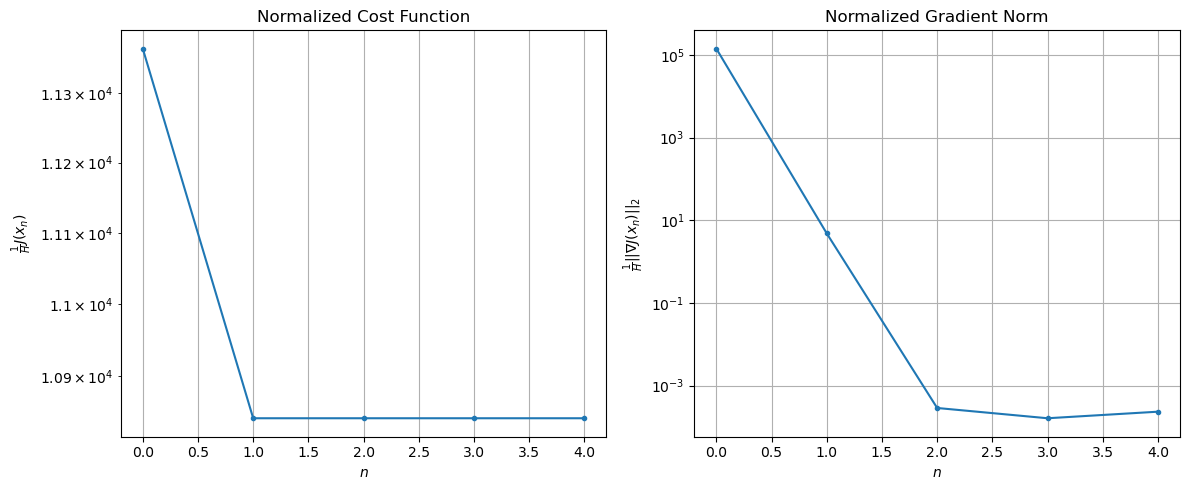

Before applying the algorithm
Cost function: 338903.5981240285
Gradient norm: 4342111.294209181
Global estimation error: 43.98021584078257
Initial conditions estimation errors: 23.718979768347765 m, 22.550140321814766 m, 25.32834415081479 m, 14.886559172152213 m
Position estimation errors: 32.64359628835938 m, 32.17928592840691 m, 32.497216480944665 m, 38.10895849352527 m

Iteration 1
Cost function: 323182.2584214711 (-4.64%)
Gradient norm: 145.80906612468618 (-100.00%)
Global estimation error: 50.09837764223704 (13.91%)
Initial conditions estimation errors: 28.634296215166742 m, 25.99302074009065 m, 28.907994905869938 m, 13.363582164812506 m
Position estimation errors: 27.447316779936457 m, 25.571408209536685 m, 29.44955741151496 m, 30.282849464864473 m

Iteration 2
Cost function: 323182.25825259765 (-0.00%)
Gradient norm: 0.022580193727741362 (-99.98%)
Global estimation error: 50.105950868841475 (0.02%)
Initial conditions estimation errors: 28.634296875811007 m, 25.997181098258764 m,

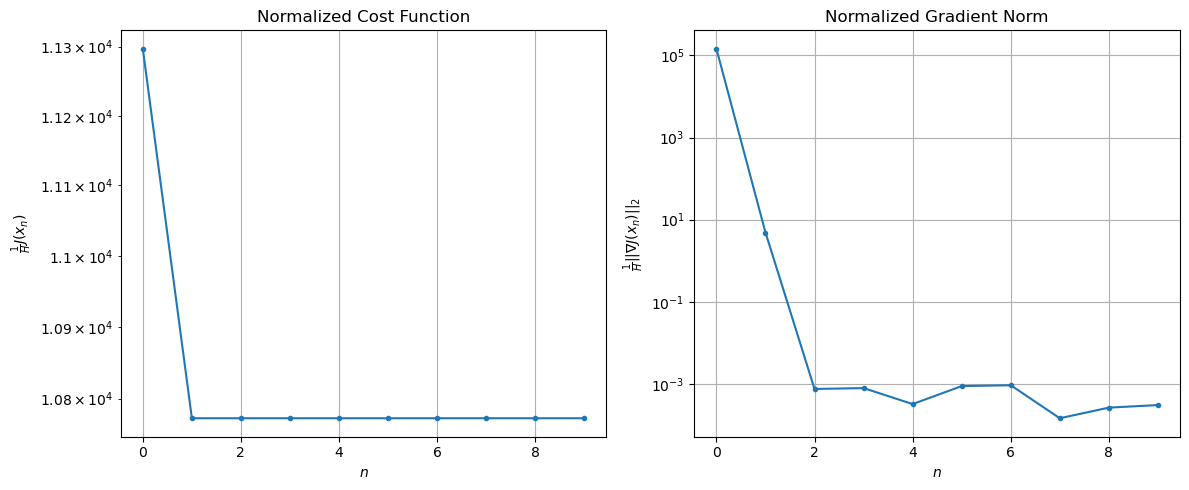

Before applying the algorithm
Cost function: 334424.2777536606
Gradient norm: 4438218.663900967
Global estimation error: 41.16029277775738
Initial conditions estimation errors: 23.95987477305569 m, 21.07947322320342 m, 23.952683561199436 m, 10.098994199959309 m
Position estimation errors: 32.24864872315404 m, 30.745951874515516 m, 34.08430922333942 m, 36.41037256879405 m

Iteration 1
Cost function: 318523.81925353763 (-4.75%)
Gradient norm: 336.53075072081094 (-99.99%)
Global estimation error: 55.528162478325214 (34.91%)
Initial conditions estimation errors: 28.874591733875768 m, 26.14454018574991 m, 33.203785526528996 m, 21.530807330596726 m
Position estimation errors: 26.985491649230433 m, 28.122774852534587 m, 25.70608655913704 m, 36.67591169832387 m

Iteration 2
Cost function: 318523.8184896879 (-0.00%)
Gradient norm: 0.01756601076802843 (-99.99%)
Global estimation error: 55.507785744033185 (-0.04%)
Initial conditions estimation errors: 28.874592174858652 m, 26.137579492815657 m, 3

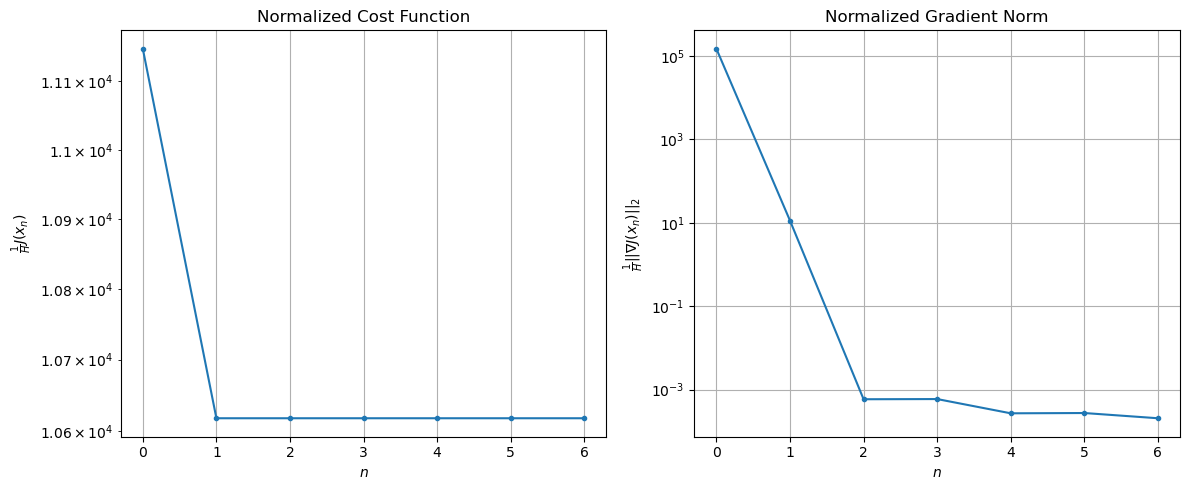

Before applying the algorithm
Cost function: 326773.4832602646
Gradient norm: 4389700.873399145
Global estimation error: 45.91370292813523
Initial conditions estimation errors: 24.031601820966507 m, 21.255944087709178 m, 27.99053827076667 m, 17.182394154098166 m
Position estimation errors: 31.72658963105227 m, 33.13682422222837 m, 29.936189496694613 m, 42.037151050932735 m

Iteration 1
Cost function: 311020.48072669434 (-4.82%)
Gradient norm: 81.52182138752714 (-100.00%)
Global estimation error: 58.81396533901729 (28.10%)
Initial conditions estimation errors: 28.904348916756312 m, 27.568129114764044 m, 33.22089243328037 m, 27.56732736928846 m
Position estimation errors: 26.462666734593277 m, 26.765832881338476 m, 24.694311417353664 m, 30.272116507974125 m

Iteration 2
Cost function: 311020.48068682436 (-0.00%)
Gradient norm: 0.005536281503754088 (-99.99%)
Global estimation error: 58.81050019493292 (-0.01%)
Initial conditions estimation errors: 28.90434909615281 m, 27.5654359135539 m, 3

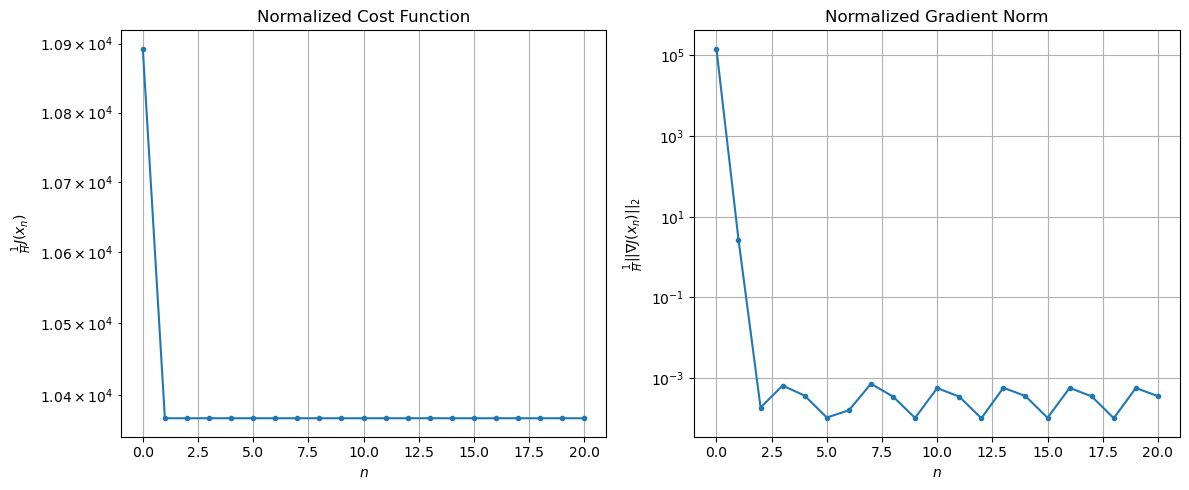

Before applying the algorithm
Cost function: 317525.53488627437
Gradient norm: 4233653.354185264
Global estimation error: 48.608646239292646
Initial conditions estimation errors: 23.90111875797936 m, 22.447268359028822 m, 27.89609488443718 m, 22.570595291857014 m
Position estimation errors: 31.167976065901154 m, 31.64569588645748 m, 28.99334554064809 m, 35.11069875398329 m

Iteration 1
Cost function: 302088.7343880342 (-4.86%)
Gradient norm: 36.72478431933421 (-100.00%)
Global estimation error: 62.62485530923758 (28.83%)
Initial conditions estimation errors: 28.711669513627292 m, 28.83520839048405 m, 33.06231035274776 m, 34.24748472934037 m
Position estimation errors: 25.943278777209777 m, 25.595118985100317 m, 23.700275590408577 m, 25.430437373298176 m

Iteration 2
Cost function: 302088.7343461168 (-0.00%)
Gradient norm: 0.025123620483563373 (-99.93%)
Global estimation error: 62.68685115670812 (0.10%)
Initial conditions estimation errors: 28.711669413186552 m, 28.848226539445417 m, 33

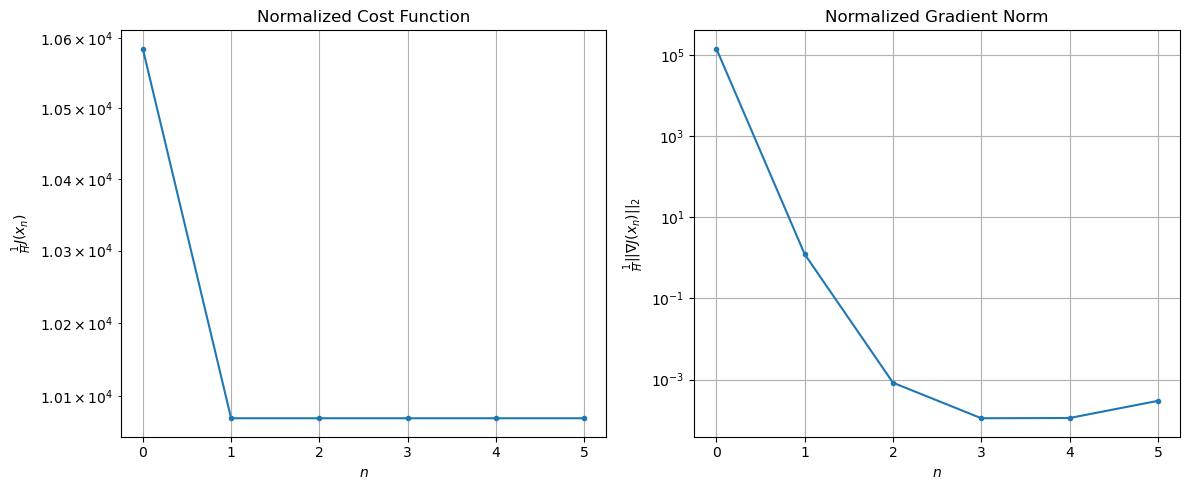

Before applying the algorithm
Cost function: 307360.7333529501
Gradient norm: 3933492.7251302605
Global estimation error: 52.13617437647919
Initial conditions estimation errors: 23.580876603154 m, 23.578296625465633 m, 27.677089205183226 m, 28.98500322645276 m
Position estimation errors: 30.631465175771936 m, 30.337041974993678 m, 28.051712553751706 m, 29.68082639624477 m

Iteration 1
Cost function: 292231.4047096596 (-4.92%)
Gradient norm: 162.23860131243643 (-100.00%)
Global estimation error: 65.74967977680578 (26.11%)
Initial conditions estimation errors: 28.345571933896736 m, 29.987362272233085 m, 32.86948674238658 m, 39.241101050663765 m
Position estimation errors: 25.469243215256395 m, 23.029843260946517 m, 22.695493866014885 m, 16.039504648342714 m

Iteration 2
Cost function: 292231.4046028321 (-0.00%)
Gradient norm: 0.01830077014253306 (-99.99%)
Global estimation error: 65.77855498966191 (0.04%)
Initial conditions estimation errors: 28.34557156691301 m, 29.993503485885416 m, 32

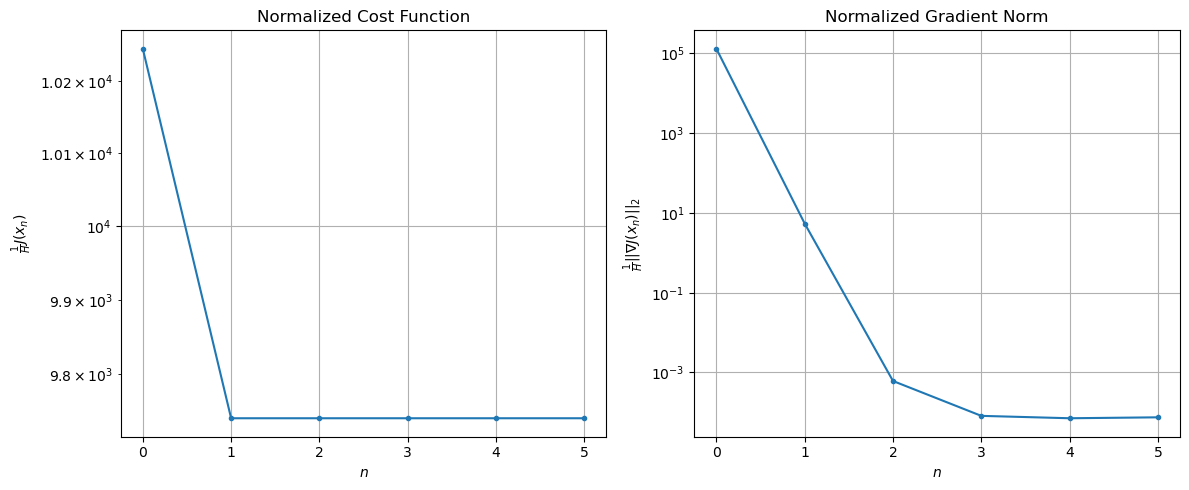

Before applying the algorithm
Cost function: 297165.0224806632
Gradient norm: 3544391.6232965556
Global estimation error: 54.82691378226821
Initial conditions estimation errors: 23.143578651252447 m, 24.524828566327518 m, 27.386468064421496 m, 33.449095667365135 m
Position estimation errors: 30.131592252025843 m, 27.64127172003632 m, 27.08708927535046 m, 20.021568811087608 m

Iteration 1
Cost function: 282655.4147822378 (-4.88%)
Gradient norm: 13.84187961415393 (-100.00%)
Global estimation error: 62.423490463874955 (13.86%)
Initial conditions estimation errors: 27.83430562356195 m, 29.35097414603656 m, 30.118321905570973 m, 36.78737418724672 m
Position estimation errors: 25.10812984425994 m, 22.90262349684699 m, 23.541947646464454 m, 15.917169550810788 m

Iteration 2
Cost function: 282655.4147789284 (-0.00%)
Gradient norm: 0.03342989854912886 (-99.76%)
Global estimation error: 62.4361984776768 (0.02%)
Initial conditions estimation errors: 27.83430501712109 m, 29.355244314208864 m, 30.1

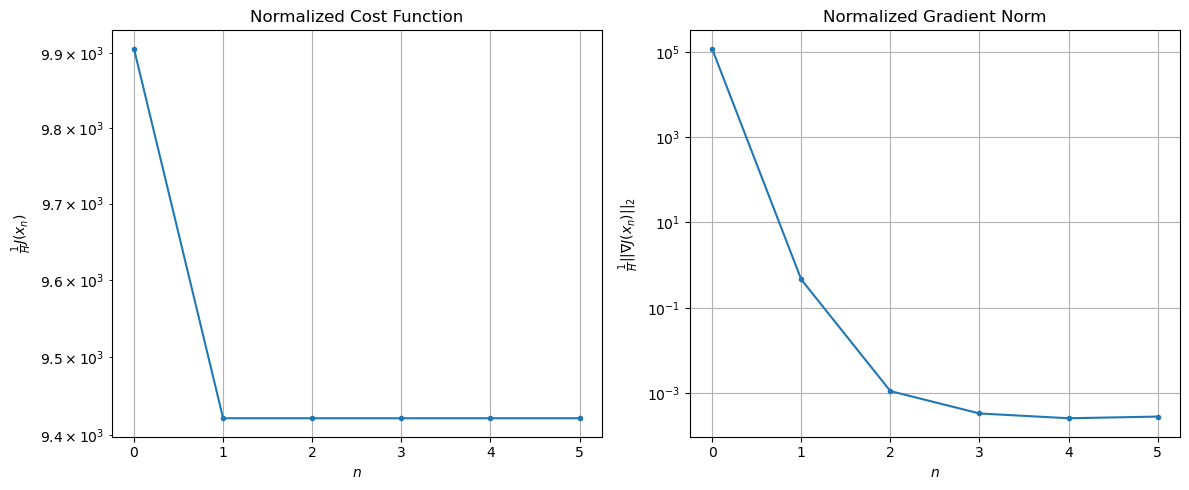

Before applying the algorithm
Cost function: 287628.2905230738
Gradient norm: 3210639.309685676
Global estimation error: 51.58205067478912
Initial conditions estimation errors: 22.640224816085272 m, 23.910411590361228 m, 24.782000753479128 m, 31.019939231657993 m
Position estimation errors: 29.727051641598237 m, 27.395631708018712 m, 28.020059802779926 m, 20.03941593457761 m

Iteration 1
Cost function: 273579.383605123 (-4.88%)
Gradient norm: 535.528309047638 (-99.98%)
Global estimation error: 69.56875363506552 (34.87%)
Initial conditions estimation errors: 27.28285324384644 m, 30.932650216695993 m, 30.520611555204294 m, 46.97961450376626 m
Position estimation errors: 24.825880552711517 m, 25.16857192328608 m, 19.734579289743152 m, 21.102850489667503 m

Iteration 2
Cost function: 273579.3816836948 (-0.00%)
Gradient norm: 0.028847090540757896 (-99.99%)
Global estimation error: 69.46286362021361 (-0.15%)
Initial conditions estimation errors: 27.28285246440194 m, 30.909999276268344 m, 30.

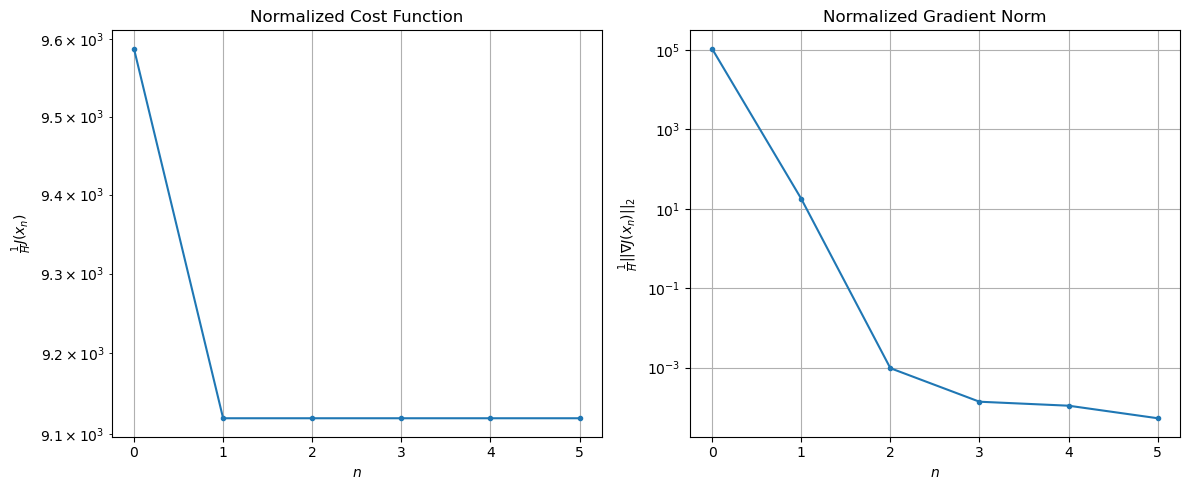

Before applying the algorithm
Cost function: 279177.09928325505
Gradient norm: 2928880.3839280205
Global estimation error: 59.400163659319446
Initial conditions estimation errors: 22.151526513070085 m, 25.79010931660302 m, 24.993519677152122 m, 41.80730369441367 m
Position estimation errors: 29.409023640647813 m, 29.43340499163063 m, 24.271985495353256 m, 24.397328541658464 m

Iteration 1
Cost function: 265528.72163743956 (-4.89%)
Gradient norm: 13.67473956066568 (-100.00%)
Global estimation error: 71.35226743202463 (20.12%)
Initial conditions estimation errors: 26.765806326069264 m, 30.54687314763758 m, 30.44232696358982 m, 50.148335941716475 m
Position estimation errors: 24.62476281260467 m, 25.026841288431626 m, 19.028882785745022 m, 18.151606904391034 m

Iteration 2
Cost function: 265528.7216091751 (-0.00%)
Gradient norm: 0.04505270017099976 (-99.67%)
Global estimation error: 71.45266606856295 (0.14%)
Initial conditions estimation errors: 26.76580543045425 m, 30.567593841955826 m, 

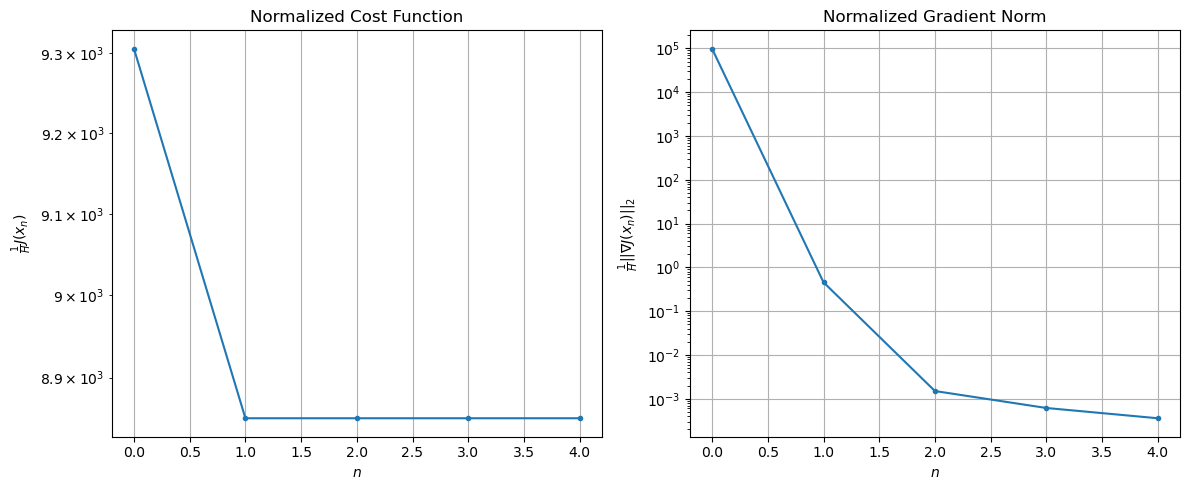

Before applying the algorithm
Cost function: 271618.79636417306
Gradient norm: 2755542.6920602806
Global estimation error: 61.608813256525785
Initial conditions estimation errors: 21.716082749867283 m, 25.523802703351787 m, 24.91846221662575 m, 45.29493969354947 m
Position estimation errors: 29.235110740913374 m, 29.299816034990453 m, 23.48598422391493 m, 21.300703565070183 m

Iteration 1
Cost function: 258344.09689241587 (-4.89%)
Gradient norm: 175.65425484972846 (-99.99%)
Global estimation error: 75.86397109795287 (23.14%)
Initial conditions estimation errors: 26.315475647346602 m, 31.624998275424346 m, 28.098222432047862 m, 57.21148986013451 m
Position estimation errors: 24.5694022613033 m, 26.292476848810498 m, 19.66363359617695 m, 19.913282223352258 m

Iteration 2
Cost function: 258344.09651128456 (-0.00%)
Gradient norm: 0.08150151265115703 (-99.95%)
Global estimation error: 75.63942216845132 (-0.30%)
Initial conditions estimation errors: 26.315474697942374 m, 31.578402804012693 m

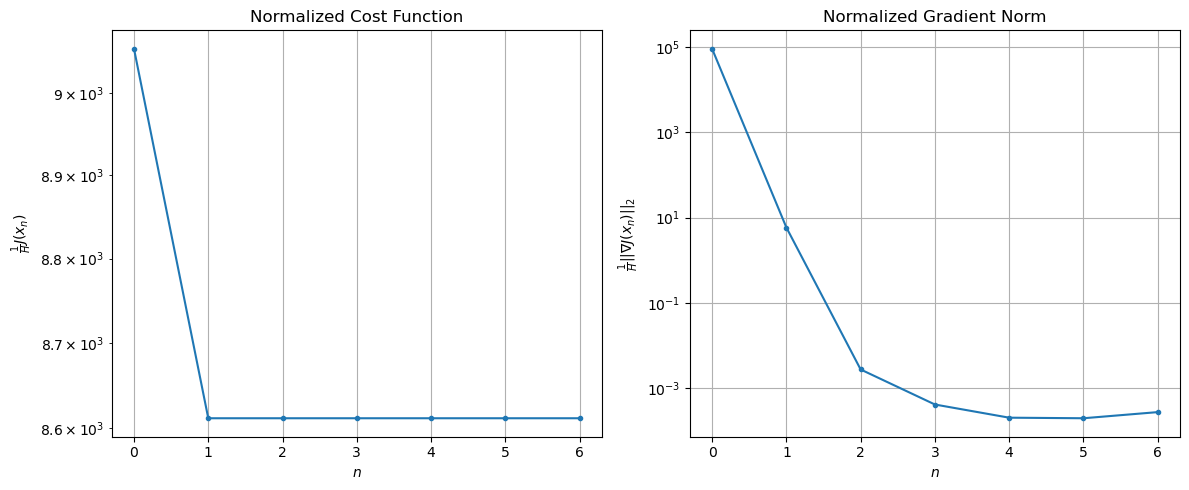

Before applying the algorithm
Cost function: 266732.9360846181
Gradient norm: 2732980.266531288
Global estimation error: 66.54477625542718
Initial conditions estimation errors: 21.33908626317154 m, 26.77191347002009 m, 22.522745784607388 m, 52.42910899314927 m
Position estimation errors: 29.300609126322147 m, 30.622020876366072 m, 24.4177868142694 m, 22.971894719390658 m

Iteration 1
Cost function: 253637.9268475549 (-4.91%)
Gradient norm: 354.16917817009744 (-99.99%)
Global estimation error: 60.574072054718904 (-8.97%)
Initial conditions estimation errors: 25.930884751333583 m, 28.17701885993805 m, 25.674383344126724 m, 39.289388066784966 m
Position estimation errors: 24.696346230066464 m, 23.63986968788487 m, 23.982765473189584 m, 21.06610636091355 m

Iteration 2
Cost function: 253637.9246685225 (-0.00%)
Gradient norm: 0.11181052623689808 (-99.97%)
Global estimation error: 60.33497731576848 (-0.39%)
Initial conditions estimation errors: 25.930883793668855 m, 28.118431872828406 m, 25.

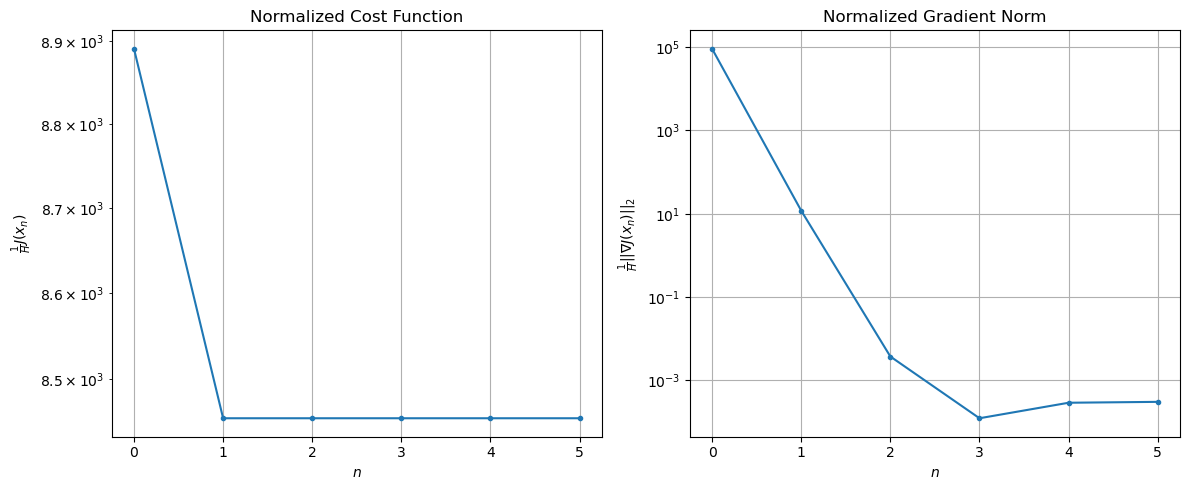

Before applying the algorithm
Cost function: 263375.63269963564
Gradient norm: 2805001.647560643
Global estimation error: 50.66565502445036
Initial conditions estimation errors: 21.018110450368297 m, 23.153513948197194 m, 20.511900362230122 m, 34.18177975367376 m
Position estimation errors: 29.61543966439854 m, 28.421304762649896 m, 28.958960323188126 m, 25.399030311371945 m

Iteration 1
Cost function: 250366.20822390908 (-4.94%)
Gradient norm: 40.513320810651564 (-100.00%)
Global estimation error: 64.08510960999324 (26.49%)
Initial conditions estimation errors: 25.617751985063506 m, 29.46970964807291 m, 25.338910660087105 m, 44.04628477446336 m
Position estimation errors: 25.054885426903592 m, 23.9728198647878 m, 22.93018655346942 m, 20.37109643035596 m

Iteration 2
Cost function: 250366.20820382534 (-0.00%)
Gradient norm: 0.009059847927179907 (-99.98%)
Global estimation error: 64.08537350843186 (0.00%)
Initial conditions estimation errors: 25.617751032664646 m, 29.468470859917446 m, 

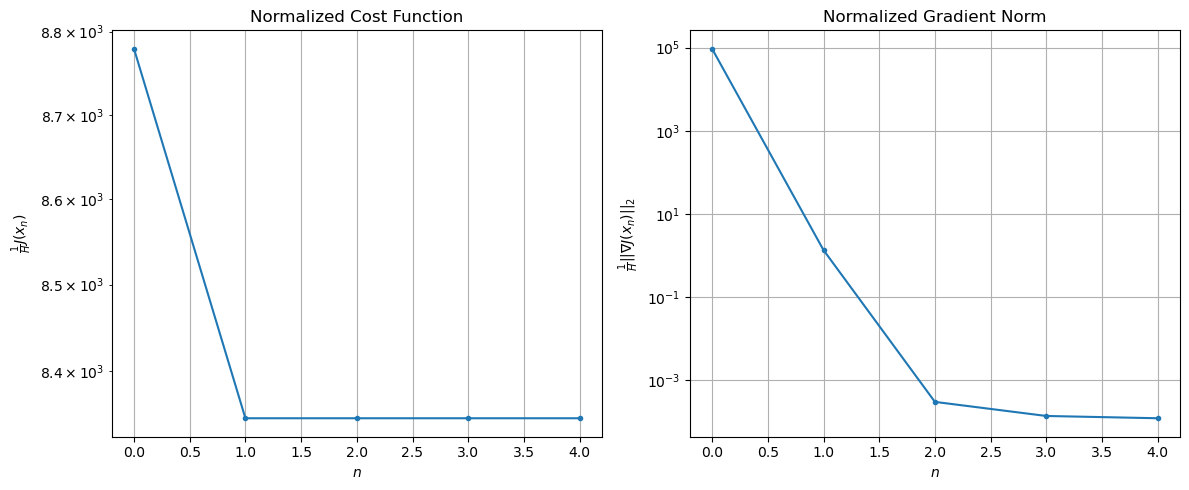

Before applying the algorithm
Cost function: 263751.4531864406
Gradient norm: 2974943.7145566745
Global estimation error: 54.73543401783322
Initial conditions estimation errors: 20.777800287747212 m, 24.612684900532038 m, 20.110685041390294 m, 39.42076610264367 m
Position estimation errors: 30.170764520280642 m, 28.896072425215774 m, 28.026839652864144 m, 24.561818664240164 m

Iteration 1
Cost function: 250647.82710005852 (-4.97%)
Gradient norm: 401.2674749421596 (-99.99%)
Global estimation error: 79.75883601694326 (45.72%)
Initial conditions estimation errors: 25.369782088018766 m, 35.0832612677313 m, 25.348491778265107 m, 62.00348411403855 m
Position estimation errors: 25.58995273946952 m, 23.494982331919832 m, 18.32372911590493 m, 17.706692336329827 m

Iteration 2
Cost function: 250647.8245016776 (-0.00%)
Gradient norm: 0.017467785410846835 (-100.00%)
Global estimation error: 79.82157341667452 (0.08%)
Initial conditions estimation errors: 25.369781167600582 m, 35.094715542041165 m, 

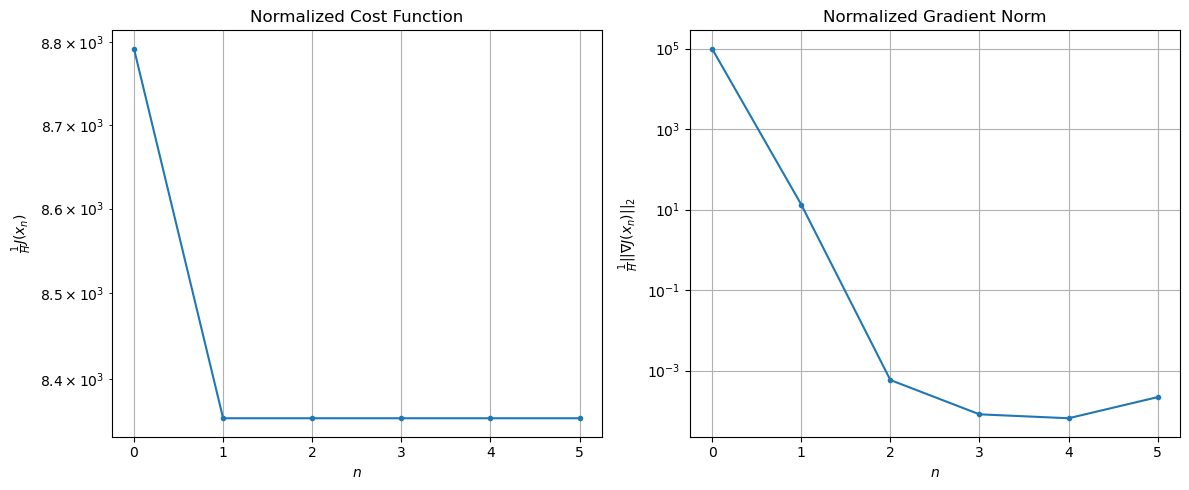

Before applying the algorithm
Cost function: 266434.4811596936
Gradient norm: 3220456.6270359596
Global estimation error: 71.15576255452723
Initial conditions estimation errors: 20.614191785658193 m, 30.362510512321126 m, 19.66310962996773 m, 57.70309810940464 m
Position estimation errors: 30.86475712893565 m, 28.273553404567156 m, 23.409536578935914 m, 21.42321019082178 m

Iteration 1
Cost function: 253219.70399860048 (-4.96%)
Gradient norm: 22.30411901167182 (-100.00%)
Global estimation error: 76.49505087413807 (7.50%)
Initial conditions estimation errors: 25.19519945665459 m, 34.20300026336323 m, 22.713249656359682 m, 59.42158522186519 m
Position estimation errors: 26.25783335455396 m, 24.25286618031176 m, 21.03616301101422 m, 17.47174551722652 m

Iteration 2
Cost function: 253219.70398803346 (-0.00%)
Gradient norm: 0.008198038867273712 (-99.96%)
Global estimation error: 76.48819523521907 (-0.01%)
Initial conditions estimation errors: 25.195198576041292 m, 34.202311771759575 m, 22.7

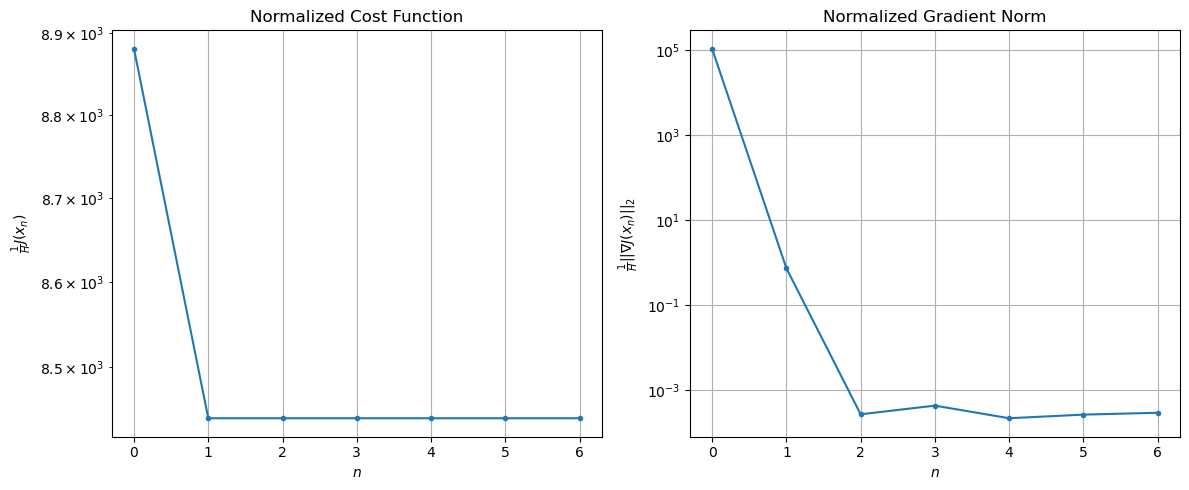

Before applying the algorithm
Cost function: 271497.40802002326
Gradient norm: 3485545.3167933775
Global estimation error: 67.83563443928563
Initial conditions estimation errors: 20.5299027781669 m, 29.50154366492335 m, 17.207689345577922 m, 54.897365435076516 m
Position estimation errors: 31.650049210790925 m, 29.199969534886254 m, 26.26886452810618 m, 21.58341507034211 m

Iteration 1
Cost function: 258022.7089331522 (-4.96%)
Gradient norm: 5355.053795359284 (-99.85%)
Global estimation error: 45.586611245476874 (-32.80%)
Initial conditions estimation errors: 25.103356163727657 m, 15.839827730010533 m, 33.27231493073847 m, 9.485811538451747 m
Position estimation errors: 26.9704757430377 m, 21.669176381924583 m, 36.33556010524456 m, 28.054535325589875 m

Iteration 2
Cost function: 258022.24042633222 (-0.00%)
Gradient norm: 0.05987404354025046 (-100.00%)
Global estimation error: 45.59639200084357 (0.02%)
Initial conditions estimation errors: 25.10335535481541 m, 15.911926859900442 m, 33.

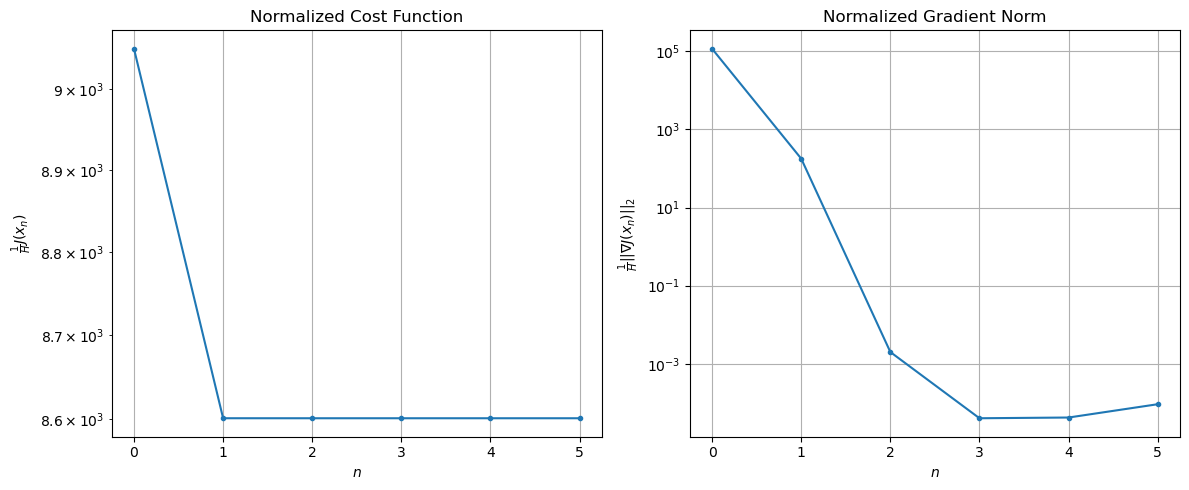

Before applying the algorithm
Cost function: 278449.8652957363
Gradient norm: 3702100.818700666
Global estimation error: 39.21340275699152
Initial conditions estimation errors: 20.532606736333438 m, 11.446539086695573 m, 29.838880119849065 m, 9.730998358221978 m
Position estimation errors: 32.47774080678234 m, 28.088008507757408 m, 41.34842621198188 m, 34.942244409928314 m

Iteration 1
Cost function: 264645.19859836926 (-4.96%)
Gradient norm: 1464.8774570015173 (-99.96%)
Global estimation error: 47.245972681464174 (20.48%)
Initial conditions estimation errors: 25.103540938436424 m, 22.07350246931338 m, 26.31372314293981 m, 20.55023844916021 m
Position estimation errors: 27.70116933202893 m, 27.79654416299454 m, 29.321975499794547 m, 29.718741561493253 m

Iteration 2
Cost function: 264645.17758159596 (-0.00%)
Gradient norm: 0.10450296724873476 (-99.99%)
Global estimation error: 47.17399935789078 (-0.15%)
Initial conditions estimation errors: 25.103540244079756 m, 22.023806811995794 m, 2

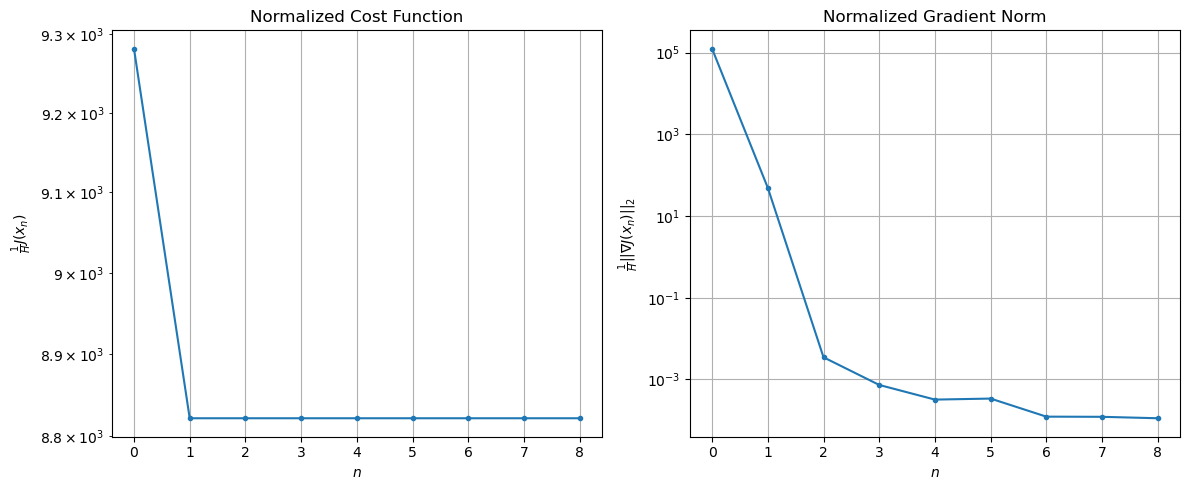

Before applying the algorithm
Cost function: 288943.7637981259
Gradient norm: 3909286.4894277644
Global estimation error: 38.24697883046219
Initial conditions estimation errors: 20.63329920936915 m, 17.372916965539947 m, 22.079939553827142 m, 15.739445864473764 m
Position estimation errors: 33.38273974546728 m, 33.715833840439586 m, 34.953852773522485 m, 35.62284644087167 m

Iteration 1
Cost function: 274605.3904567534 (-4.96%)
Gradient norm: 206.98500264034945 (-99.99%)
Global estimation error: 56.6734931500585 (48.18%)
Initial conditions estimation errors: 25.23211180103858 m, 26.88646924472177 m, 23.99745571325334 m, 35.72723530646563 m
Position estimation errors: 28.465160246519684 m, 26.158666835919636 m, 28.646416249613146 m, 22.227509315120884 m

Iteration 2
Cost function: 274605.38960137643 (-0.00%)
Gradient norm: 0.009777329614447635 (-100.00%)
Global estimation error: 56.6607505042828 (-0.02%)
Initial conditions estimation errors: 25.23211126203459 m, 26.879345208986233 m, 24

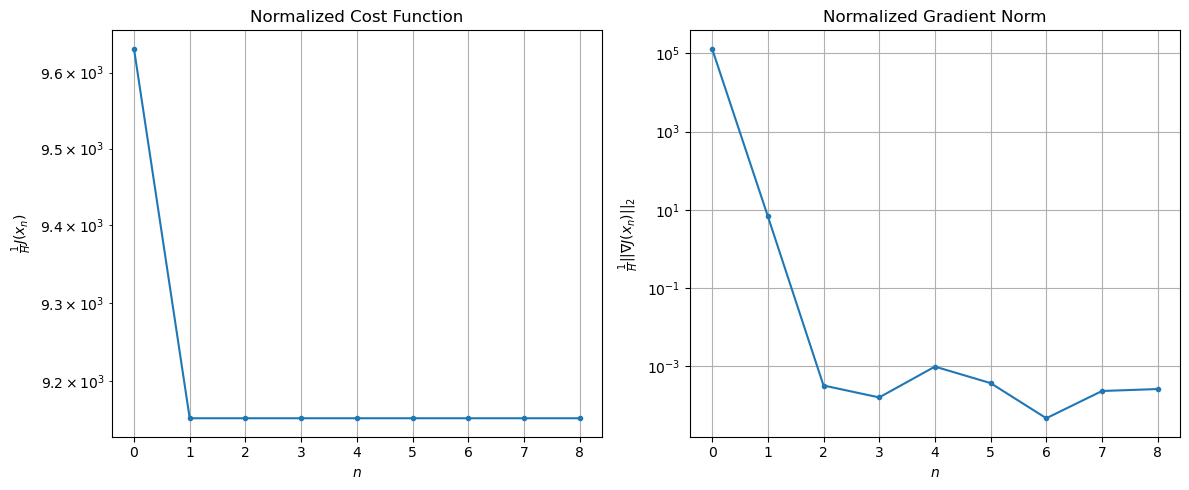

Before applying the algorithm
Cost function: 302521.7487239855
Gradient norm: 4094169.3494256027
Global estimation error: 47.697616177177764
Initial conditions estimation errors: 20.859174543071138 m, 22.240987023288756 m, 19.714478233492354 m, 30.92909810148699 m
Position estimation errors: 34.41628076291818 m, 32.08758517520545 m, 34.53884386669216 m, 27.75866952114853 m

Iteration 1
Cost function: 287699.5867434827 (-4.90%)
Gradient norm: 7.693490128687299 (-100.00%)
Global estimation error: 54.797001028959734 (14.88%)
Initial conditions estimation errors: 25.482661570371864 m, 25.161832267040577 m, 23.76598102376458 m, 33.99083159246526 m
Position estimation errors: 29.362775430287332 m, 27.221469369787236 m, 29.343713614137233 m, 22.564976094731257 m

Iteration 2
Cost function: 287699.5867374571 (-0.00%)
Gradient norm: 0.025537345128873807 (-99.67%)
Global estimation error: 54.80199010280196 (0.01%)
Initial conditions estimation errors: 25.48266122471897 m, 25.1636763905291 m, 23.

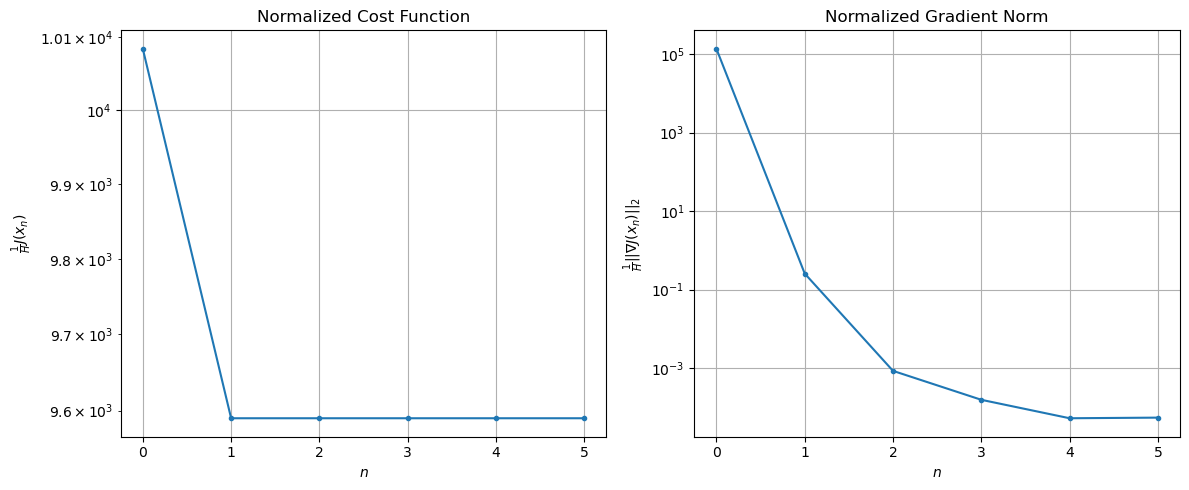

Before applying the algorithm
Cost function: 319158.53302767914
Gradient norm: 4229353.022801186
Global estimation error: 45.85190672709326
Initial conditions estimation errors: 21.18200543020418 m, 20.5698663760612 m, 19.526316645659282 m, 29.142714993003732 m
Position estimation errors: 35.646365077868225 m, 33.59938134779079 m, 35.61718765661233 m, 28.495943854556355 m

Iteration 1
Cost function: 303496.15528990165 (-4.91%)
Gradient norm: 142.47137512883523 (-100.00%)
Global estimation error: 52.576116880201425 (14.67%)
Initial conditions estimation errors: 25.910325649350764 m, 23.278556028050644 m, 26.150740554930955 m, 29.44693645498402 m
Position estimation errors: 30.411985602396875 m, 27.334672582549597 m, 32.59187149108993 m, 21.234380595724083 m

Iteration 2
Cost function: 303496.15513678355 (-0.00%)
Gradient norm: 0.011876612479712906 (-99.99%)
Global estimation error: 52.57895419444926 (0.01%)
Initial conditions estimation errors: 25.910325520316885 m, 23.28099749468366 m,

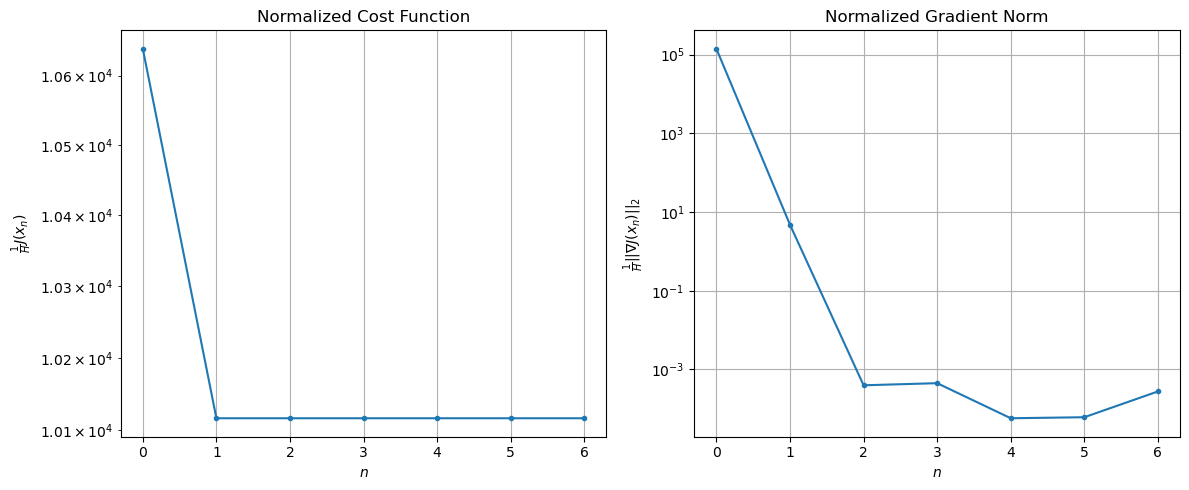

Before applying the algorithm
Cost function: 338338.2542719815
Gradient norm: 4389346.684991253
Global estimation error: 43.55194189915918
Initial conditions estimation errors: 21.630619128986048 m, 18.643679935427127 m, 22.130183449862752 m, 24.321393590126284 m
Position estimation errors: 37.007632846398714 m, 34.18898120203769 m, 39.02071013368223 m, 27.70830619809999 m

Iteration 1
Cost function: 321605.63641236967 (-4.95%)
Gradient norm: 107.59574708553188 (-100.00%)
Global estimation error: 48.142704997968394 (10.54%)
Initial conditions estimation errors: 26.504345404534206 m, 21.290844682994155 m, 25.95189913195756 m, 22.100025161457484 m
Position estimation errors: 31.56367935025045 m, 31.927102279026066 m, 32.992600048422986 m, 26.798894858552842 m

Iteration 2
Cost function: 321605.6363129853 (-0.00%)
Gradient norm: 0.06294934770209575 (-99.94%)
Global estimation error: 48.083841186125916 (-0.12%)
Initial conditions estimation errors: 26.504345506225725 m, 21.24524739439832 m

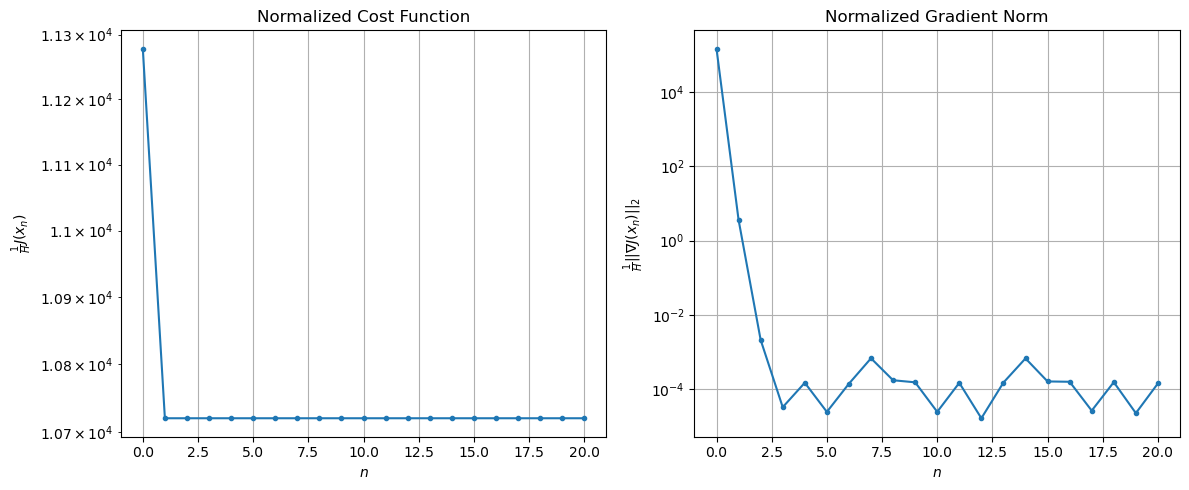

Before applying the algorithm
Cost function: 359143.7644610242
Gradient norm: 4502945.437177233
Global estimation error: 39.238222787222355
Initial conditions estimation errors: 22.184870366725406 m, 16.733820813113088 m, 21.80689481707067 m, 17.08458525304218 m
Position estimation errors: 38.36727099319878 m, 39.02325562952561 m, 39.77784631907934 m, 33.85284673961982 m

Iteration 1
Cost function: 341438.34453007637 (-4.93%)
Gradient norm: 2398.5008712522936 (-99.95%)
Global estimation error: 55.82690748436596 (42.28%)
Initial conditions estimation errors: 27.21245212524149 m, 29.346110077022278 m, 19.100611052282385 m, 33.91273516753339 m
Position estimation errors: 32.74944189656726 m, 39.169310251803395 m, 26.956417636593482 m, 42.73949961619884 m

Iteration 2
Cost function: 341438.3146087088 (-0.00%)
Gradient norm: 0.0386117252596459 (-100.00%)
Global estimation error: 55.90141921017602 (0.13%)
Initial conditions estimation errors: 27.212452461616948 m, 29.38744590547737 m, 19.085

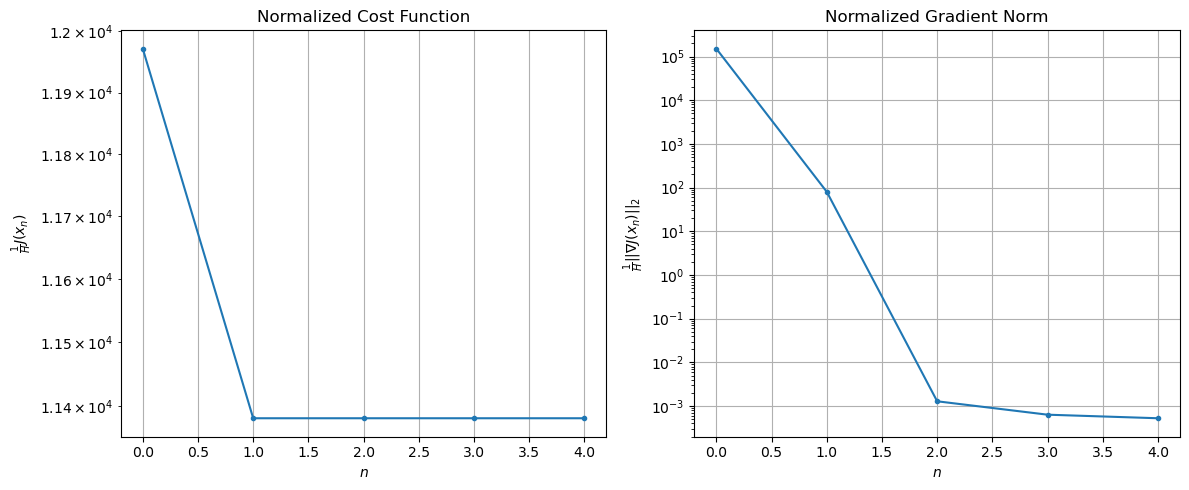

Before applying the algorithm
Cost function: 382750.0543397805
Gradient norm: 4603736.748648456
Global estimation error: 47.8715033543428
Initial conditions estimation errors: 22.80945124512019 m, 25.443981660638425 m, 14.205186260476328 m, 30.367797560076372 m
Position estimation errors: 39.63227884380038 m, 45.673920183832166 m, 34.29236578764039 m, 49.02147877481269 m

Iteration 1
Cost function: 363648.58572152315 (-4.99%)
Gradient norm: 129.08872771256944 (-100.00%)
Global estimation error: 56.20823441035373 (17.41%)
Initial conditions estimation errors: 28.0520942971175 m, 30.696771240574357 m, 19.1491632185901 m, 32.610408711608876 m
Position estimation errors: 33.78260144432436 m, 42.22157768992326 m, 27.407559048496747 m, 49.85006096535033 m

Iteration 2
Cost function: 363648.58566940733 (-0.00%)
Gradient norm: 0.02468786950718061 (-99.98%)
Global estimation error: 56.18408683423842 (-0.04%)
Initial conditions estimation errors: 28.05209487773062 m, 30.680595284238446 m, 19.160

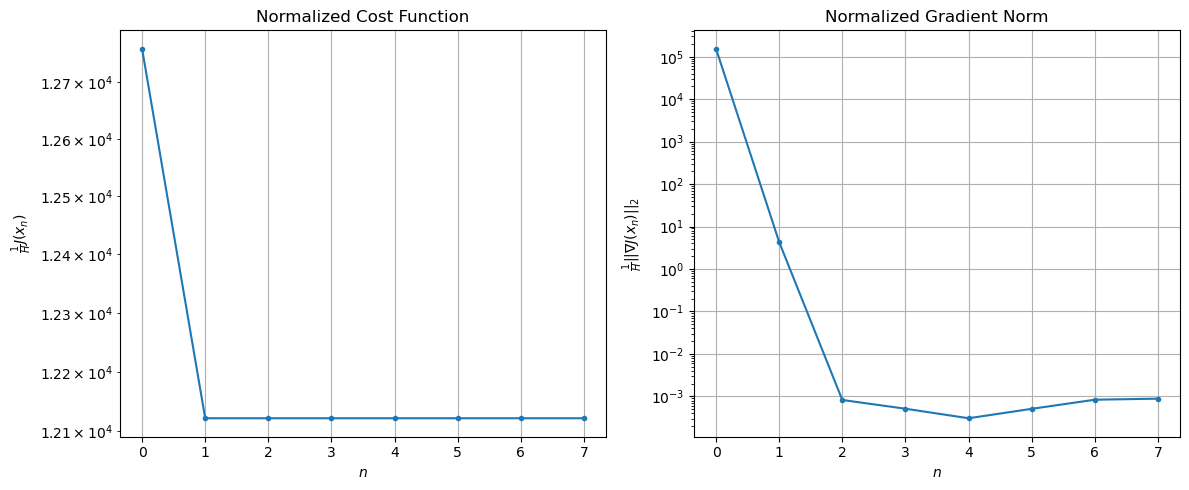

Before applying the algorithm
Cost function: 406773.10970811197
Gradient norm: 4556074.871875741
Global estimation error: 48.207519272959935
Initial conditions estimation errors: 23.539552651580617 m, 26.823764832180853 m, 14.172007401745985 m, 29.14568993531584 m
Position estimation errors: 40.63496233130021 m, 48.614005535174705 m, 34.794255757573445 m, 56.130377485226 m

Iteration 1
Cost function: 386583.67073644197 (-4.96%)
Gradient norm: 234.0718879620124 (-99.99%)
Global estimation error: 63.305331750471744 (31.32%)
Initial conditions estimation errors: 28.9731728338166 m, 35.86067379641463 m, 19.364878806563127 m, 38.821503047308084 m
Position estimation errors: 34.62502915317396 m, 43.78382325592617 m, 27.37861714581596 m, 55.8898226239678 m

Iteration 2
Cost function: 386583.6704445351 (-0.00%)
Gradient norm: 0.05127532437807975 (-99.98%)
Global estimation error: 63.34348349643233 (0.06%)
Initial conditions estimation errors: 28.973173641937418 m, 35.88289321153026 m, 19.35243

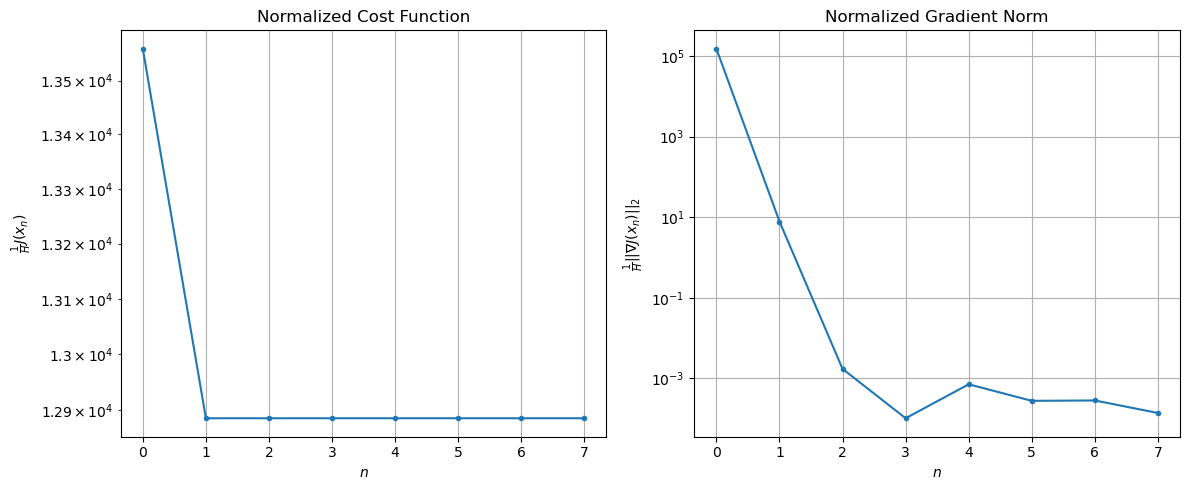

Before applying the algorithm
Cost function: 430421.66886895435
Gradient norm: 4532411.20762446
Global estimation error: 55.60572174856153
Initial conditions estimation errors: 24.340302372252655 m, 32.05868957141802 m, 14.320541657107563 m, 35.59052242853322 m
Position estimation errors: 41.386825342225414 m, 49.83266952959478 m, 34.720551649772794 m, 61.75119962254213 m

Iteration 1
Cost function: 409371.0987076795 (-4.89%)
Gradient norm: 462.85832939301247 (-99.99%)
Global estimation error: 72.9577419755262 (31.21%)
Initial conditions estimation errors: 29.92543049534997 m, 40.16558967318589 m, 22.524296222253188 m, 48.027649514213145 m
Position estimation errors: 35.254920846333114 m, 39.59795002290326 m, 30.310816561488462 m, 43.16568825470497 m

Iteration 2
Cost function: 409371.0981782921 (-0.00%)
Gradient norm: 0.020697726458857115 (-100.00%)
Global estimation error: 72.9584679883469 (0.00%)
Initial conditions estimation errors: 29.92543149864051 m, 40.179430101533896 m, 22.497

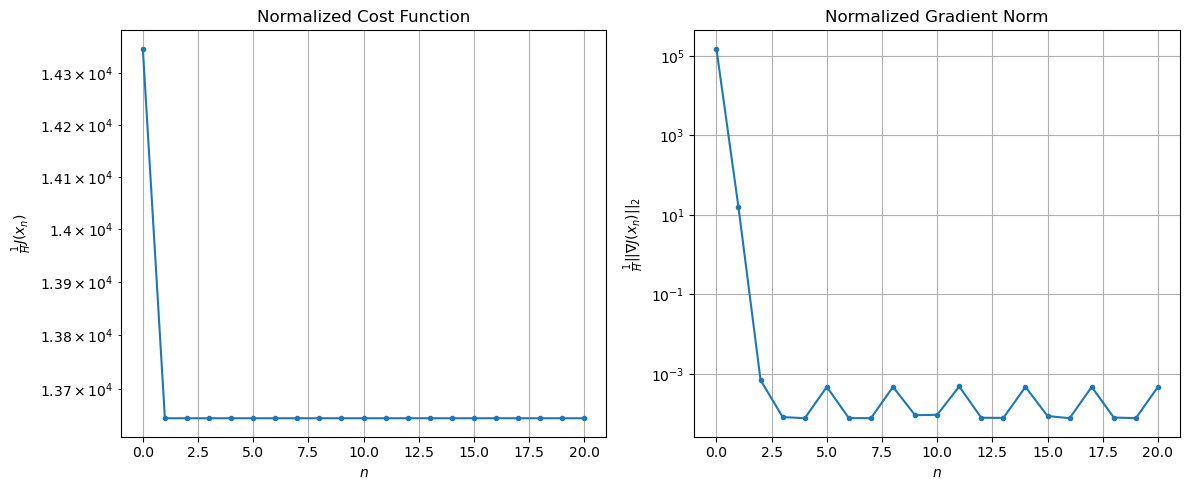

Before applying the algorithm
Cost function: 451841.5226667704
Gradient norm: 4363395.839430241
Global estimation error: 64.56687703809986
Initial conditions estimation errors: 25.17289617830014 m, 35.94036431671006 m, 17.668690893503562 m, 43.946432757895394 m
Position estimation errors: 41.91825808533677 m, 45.449441906682374 m, 37.52062529468752 m, 48.657689089177765 m

Iteration 1
Cost function: 429743.95875164634 (-4.89%)
Gradient norm: 117.76169736105166 (-100.00%)
Global estimation error: 69.23035423470365 (7.22%)
Initial conditions estimation errors: 30.95433556812968 m, 38.17777353549858 m, 26.037089886335867 m, 41.22099228336832 m
Position estimation errors: 35.664493624359594 m, 38.732636782754675 m, 32.438040093329455 m, 44.18605928470132 m

Iteration 2
Cost function: 429743.9584216983 (-0.00%)
Gradient norm: 0.007870521765739805 (-99.99%)
Global estimation error: 69.22178876588478 (-0.01%)
Initial conditions estimation errors: 30.95433674823783 m, 38.17829830722428 m, 26.0

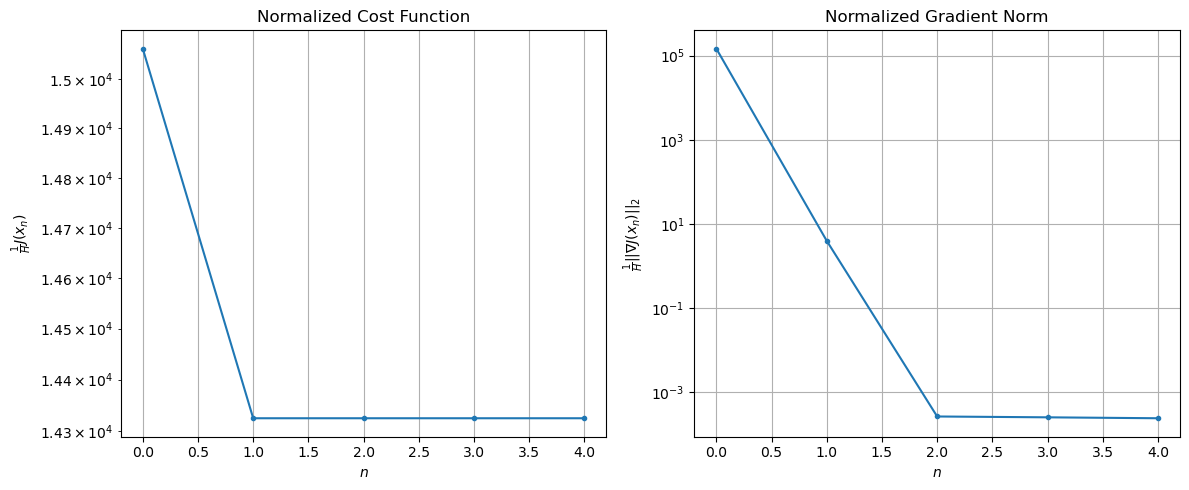

Before applying the algorithm
Cost function: 470742.1319316125
Gradient norm: 4231403.353007066
Global estimation error: 60.18070051684743
Initial conditions estimation errors: 26.08517626300282 m, 33.661193794139855 m, 21.027651997447666 m, 36.95964560982565 m
Position estimation errors: 42.262917657828865 m, 44.76191825883536 m, 39.40243223964737 m, 50.01334590518419 m

Iteration 1
Cost function: 447724.966294427 (-4.89%)
Gradient norm: 3360.58162853129 (-99.92%)
Global estimation error: 77.33677785667902 (28.51%)
Initial conditions estimation errors: 32.03833235717272 m, 37.168865688692655 m, 38.20505939560204 m, 45.9710336372993 m
Position estimation errors: 35.916110314481394 m, 28.861738902252988 m, 39.78167037185342 m, 16.853677242879975 m

Iteration 2
Cost function: 447724.9269613608 (-0.00%)
Gradient norm: 0.8481111274778073 (-99.97%)
Global estimation error: 77.32133244996233 (-0.02%)
Initial conditions estimation errors: 32.03833368247222 m, 37.255303130124446 m, 38.04827756

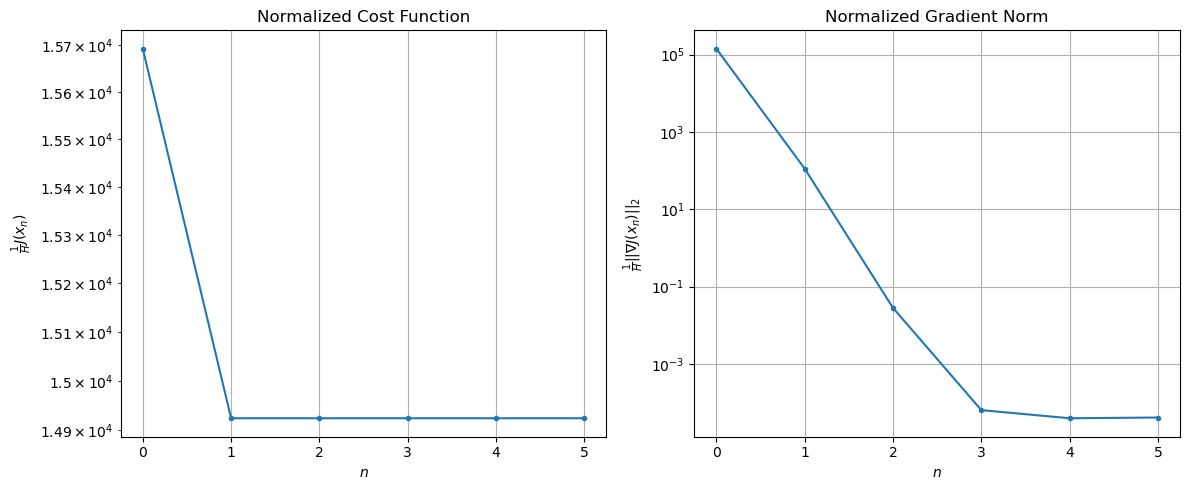

Before applying the algorithm
Cost function: 487245.82216393016
Gradient norm: 4064919.7464815825
Global estimation error: 66.73286001069407
Initial conditions estimation errors: 27.040978371549166 m, 31.864973940145017 m, 33.244888926919806 m, 40.01783413521562 m
Position estimation errors: 42.49937878731249 m, 35.3400183748163 m, 45.925591391238335 m, 22.782946200994154 m

Iteration 1
Cost function: 463215.9160172804 (-4.93%)
Gradient norm: 969.4352538354625 (-99.98%)
Global estimation error: 79.4110884680823 (19.00%)
Initial conditions estimation errors: 33.164069762049905 m, 40.225795022030795 m, 34.15643223027479 m, 49.20827655710477 m
Position estimation errors: 36.05223928730271 m, 33.68995805153269 m, 35.09848216183327 m, 29.057566973663288 m

Iteration 2
Cost function: 463215.9120513412 (-0.00%)
Gradient norm: 0.04655807479484448 (-100.00%)
Global estimation error: 79.47089104074675 (0.08%)
Initial conditions estimation errors: 33.16407120300595 m, 40.22638607227833 m, 34.1967

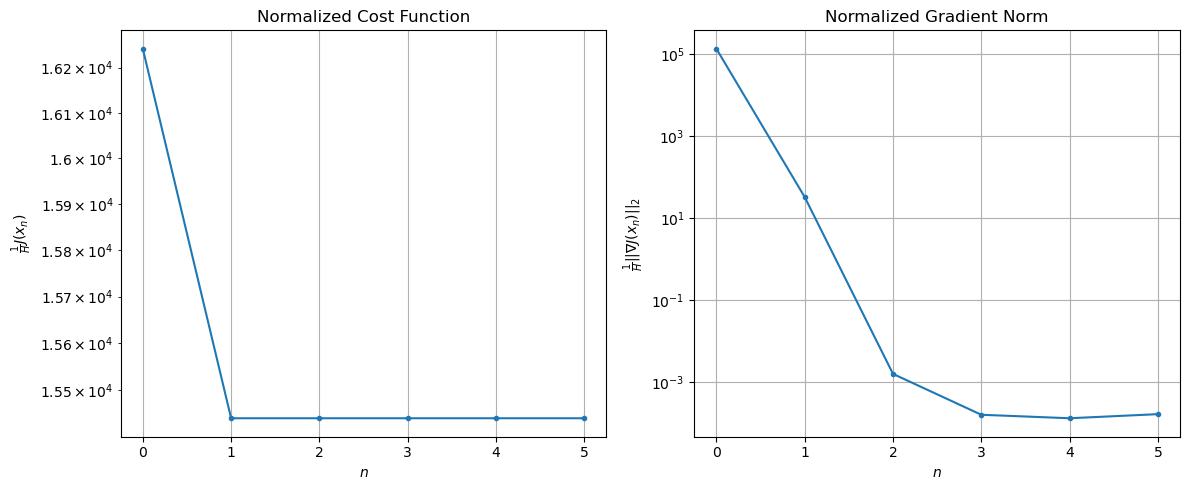

Before applying the algorithm
Cost function: 499264.1535372841
Gradient norm: 3920361.909679332
Global estimation error: 69.11284735669534
Initial conditions estimation errors: 27.998380013837643 m, 35.022070934083445 m, 28.96556113200615 m, 43.89867333880719 m
Position estimation errors: 42.64625747238595 m, 39.80707270789044 m, 41.766501956953505 m, 34.420800412752314 m

Iteration 1
Cost function: 474502.1025184626 (-4.96%)
Gradient norm: 5294.224699597619 (-99.86%)
Global estimation error: 86.55303599427397 (25.23%)
Initial conditions estimation errors: 34.25116722055535 m, 35.73285977936954 m, 47.89245466335633 m, 52.418637626306435 m
Position estimation errors: 36.14966009526128 m, 23.362893192835188 m, 44.229403191535205 m, 11.062522112629567 m

Iteration 2
Cost function: 474502.0046889945 (-0.00%)
Gradient norm: 0.21556932169101434 (-100.00%)
Global estimation error: 86.55459647765468 (0.00%)
Initial conditions estimation errors: 34.25116872223929 m, 35.78381135976712 m, 47.8199

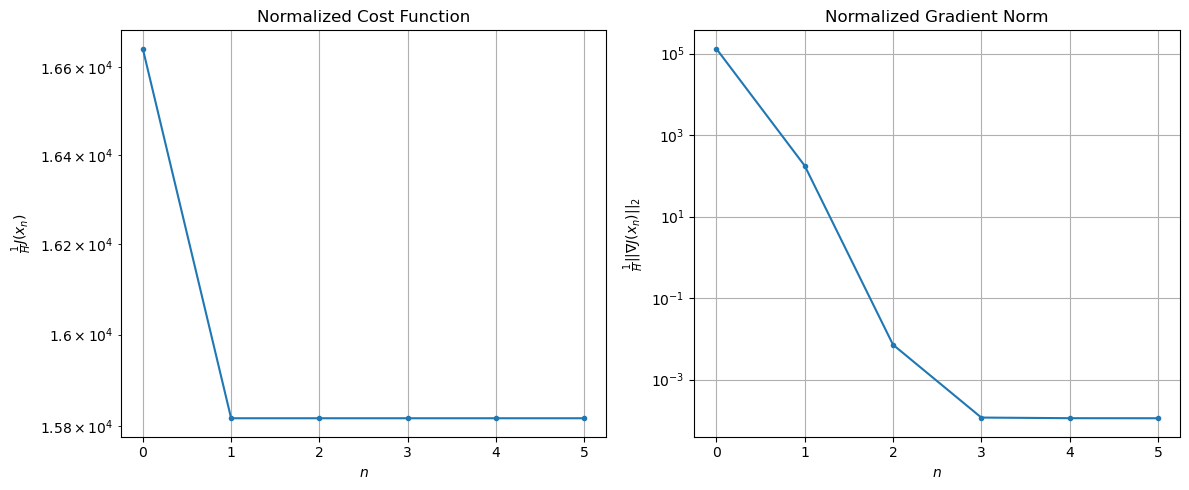

Before applying the algorithm
Cost function: 507222.7043130797
Gradient norm: 3885106.374540789
Global estimation error: 74.34012837595428
Initial conditions estimation errors: 28.861771283074155 m, 29.488547961046493 m, 42.74627834356705 m, 44.683184766693934 m
Position estimation errors: 42.74179480351989 m, 30.103580584758493 m, 49.8771403855884 m, 5.850963079091677 m

Iteration 1
Cost function: 481902.36367507605 (-4.99%)
Gradient norm: 2311.8788397265607 (-99.94%)
Global estimation error: 92.6425798124031 (24.62%)
Initial conditions estimation errors: 35.20636133841444 m, 32.03772886662019 m, 56.40354563255338 m, 55.99394647962103 m
Position estimation errors: 36.21502099508738 m, 17.631026941605096 m, 48.01966181418072 m, 35.833793226947584 m

Iteration 2
Cost function: 481902.3479335469 (-0.00%)
Gradient norm: 0.022378793523077048 (-100.00%)
Global estimation error: 92.6565185583404 (0.02%)
Initial conditions estimation errors: 35.206362855850294 m, 32.059594176388885 m, 56.3847

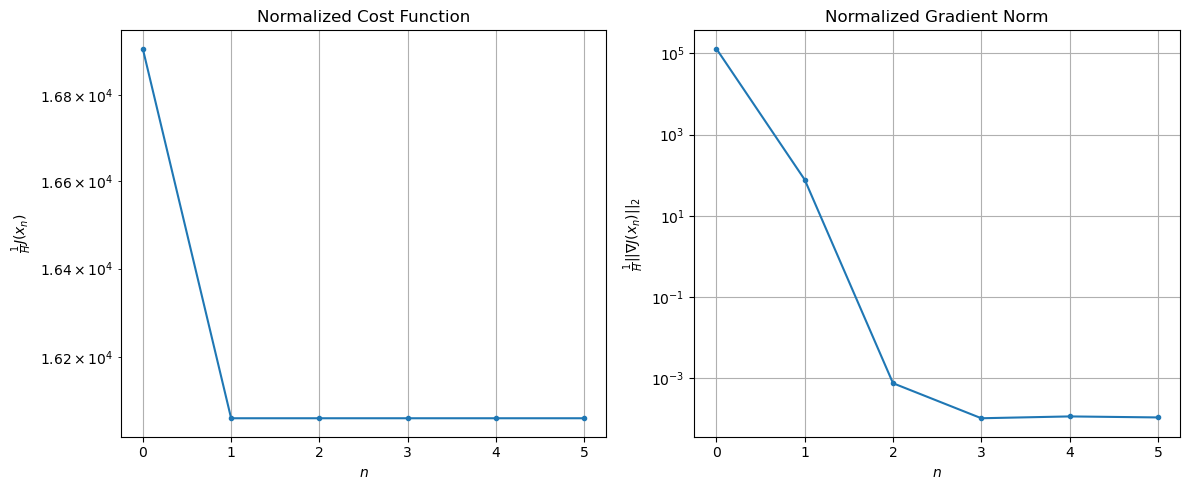

Before applying the algorithm
Cost function: 510969.68486516154
Gradient norm: 4034581.7655234253
Global estimation error: 79.22907031864773
Initial conditions estimation errors: 29.556045984836835 m, 25.02322881749317 m, 51.23883652942691 m, 46.39012791116938 m
Position estimation errors: 42.76360228304362 m, 24.56132881588856 m, 52.98634923361529 m, 29.12267293235978 m

Iteration 1
Cost function: 484967.0270858286 (-5.09%)
Gradient norm: 586.5957812707032 (-99.99%)
Global estimation error: 100.09628885716978 (26.34%)
Initial conditions estimation errors: 35.9946769010166 m, 30.589598528287713 m, 60.68095511723618 m, 64.07554717912531 m
Position estimation errors: 36.18385645489083 m, 16.577707463131887 m, 45.33535403761315 m, 53.280163313256395 m

Iteration 2
Cost function: 484967.0258144806 (-0.00%)
Gradient norm: 0.048067031126896614 (-99.99%)
Global estimation error: 100.06957661990334 (-0.03%)
Initial conditions estimation errors: 35.99467838178953 m, 30.6051250880382 m, 60.65638

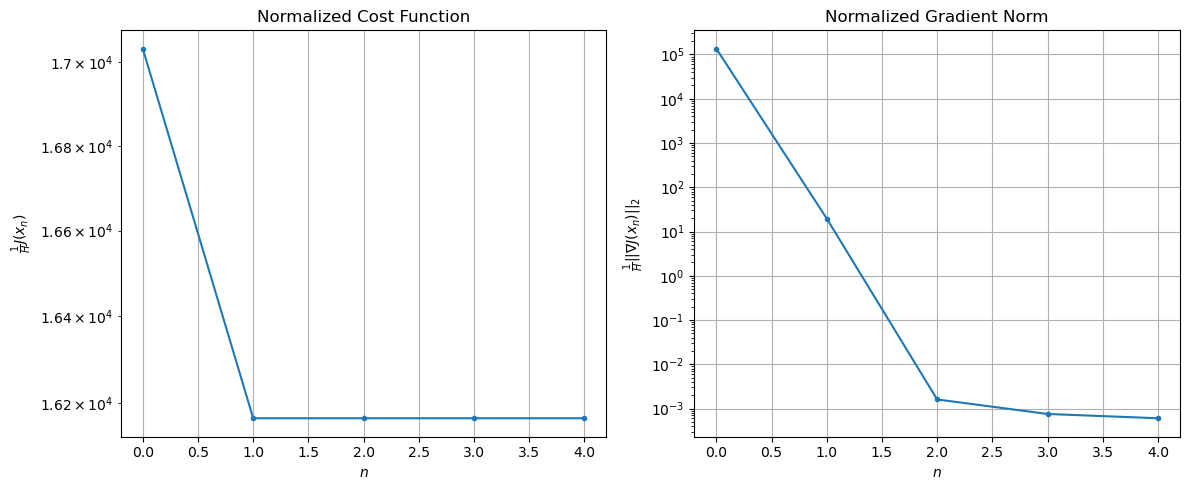

Before applying the algorithm
Cost function: 510175.8419365412
Gradient norm: 4388511.000311711
Global estimation error: 85.59901271196316
Initial conditions estimation errors: 30.07992535263145 m, 23.23850732587813 m, 55.25641304584617 m, 53.18850742380183 m
Position estimation errors: 42.62830679015659 m, 23.66038099588247 m, 49.80167269742798 m, 47.09504072564471 m

Iteration 1
Cost function: 483943.84789500886 (-5.14%)
Gradient norm: 2826.848912156769 (-99.94%)
Global estimation error: 88.23664937766907 (3.08%)
Initial conditions estimation errors: 36.52484287488027 m, 33.780377887535515 m, 51.78073267016625 m, 51.27591319025405 m
Position estimation errors: 36.01983270895804 m, 23.920353150714266 m, 37.57694117427576 m, 23.64681873095761 m

Iteration 2
Cost function: 483943.82126996416 (-0.00%)
Gradient norm: 0.3716378267984577 (-99.99%)
Global estimation error: 88.11982456018492 (-0.13%)
Initial conditions estimation errors: 36.52484421700995 m, 33.808439418121544 m, 51.690240709

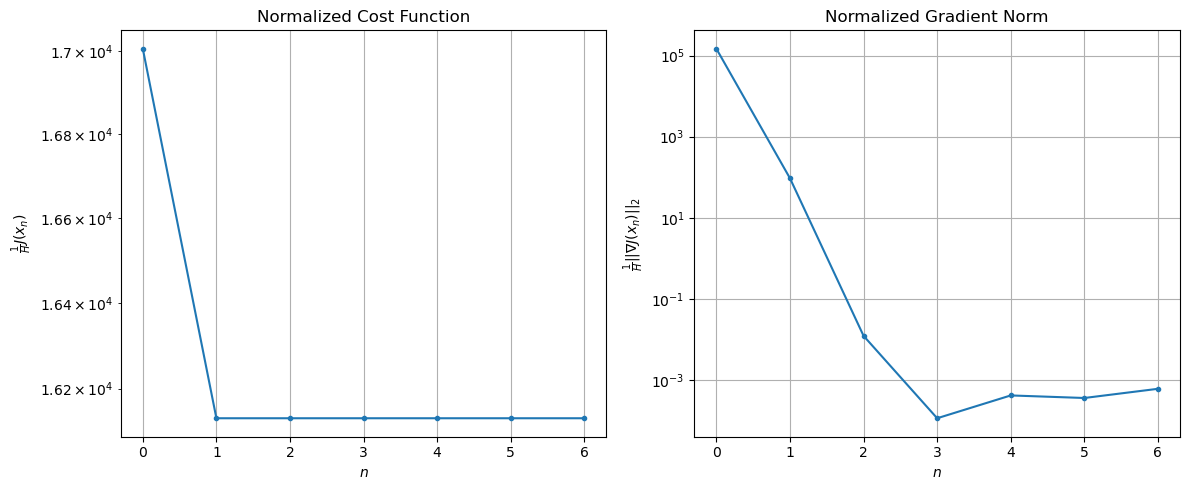

Before applying the algorithm
Cost function: 506783.55178524373
Gradient norm: 4718909.447767829
Global estimation error: 74.12832339983076
Initial conditions estimation errors: 30.380430874242855 m, 26.883898874213994 m, 45.820464522173545 m, 41.829599142206895 m
Position estimation errors: 42.2807090940543 m, 30.803330960371294 m, 42.5631844042742 m, 18.83008326156914 m

Iteration 1
Cost function: 480512.434501749 (-5.18%)
Gradient norm: 136.32347445320377 (-100.00%)
Global estimation error: 86.48684512386941 (16.67%)
Initial conditions estimation errors: 36.804581139170814 m, 30.926731218046456 m, 54.948679747973415 m, 46.36276356988276 m
Position estimation errors: 35.66152553187633 m, 23.63015646758029 m, 36.572575342814396 m, 29.973098845713512 m

Iteration 2
Cost function: 480512.43439698964 (-0.00%)
Gradient norm: 0.014648841245755936 (-99.99%)
Global estimation error: 86.482440261759 (-0.01%)
Initial conditions estimation errors: 36.804582280751944 m, 30.932374357675 m, 54.943

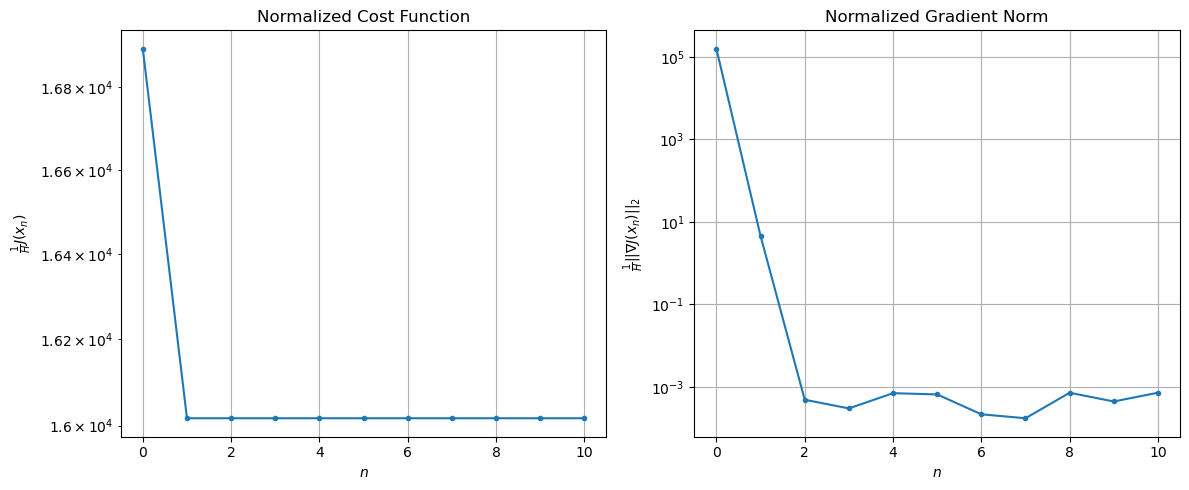

Before applying the algorithm
Cost function: 498652.54351655353
Gradient norm: 5064467.502882827
Global estimation error: 72.23752674990057
Initial conditions estimation errors: 30.48279668399639 m, 23.741576087997885 m, 48.95284632938295 m, 36.454723469764616 m
Position estimation errors: 41.63828282054508 m, 30.3935684370188 m, 40.90224359731968 m, 26.306602447672645 m

Iteration 1
Cost function: 472663.5492635558 (-5.21%)
Gradient norm: 1577.9179229792321 (-99.97%)
Global estimation error: 81.39503853362812 (12.68%)
Initial conditions estimation errors: 36.845614508750934 m, 33.551231539370626 m, 47.57158409247675 m, 43.34451521209785 m
Position estimation errors: 35.03694819035128 m, 28.569207580541686 m, 33.296316861206925 m, 13.331974280704411 m

Iteration 2
Cost function: 472663.54021822836 (-0.00%)
Gradient norm: 0.13378782703643657 (-99.99%)
Global estimation error: 81.33019298220715 (-0.08%)
Initial conditions estimation errors: 36.84561538060034 m, 33.56945477932281 m, 47.52

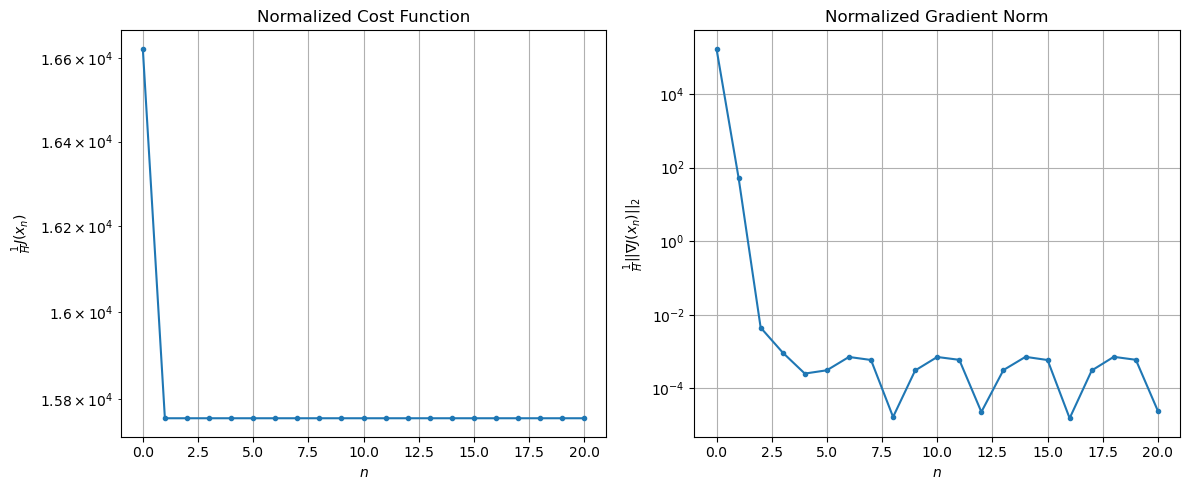

Before applying the algorithm
Cost function: 487267.0798907536
Gradient norm: 5365719.938928466
Global estimation error: 67.2655291832071
Initial conditions estimation errors: 30.41275077000918 m, 26.674269751024017 m, 41.19301120749443 m, 34.514826030356105 m
Position estimation errors: 40.595512883620806 m, 34.68015663494735 m, 38.00538135643145 m, 15.582181306603442 m

Iteration 1
Cost function: 461969.0754080457 (-5.19%)
Gradient norm: 324.84187420062625 (-99.99%)
Global estimation error: 74.96267862719114 (11.44%)
Initial conditions estimation errors: 36.65725418919929 m, 30.990626085614647 m, 45.83277004783254 m, 34.850033667417016 m
Position estimation errors: 34.04650825939129 m, 30.70796470824167 m, 32.56273011072413 m, 13.660132435283797 m

Iteration 2
Cost function: 461969.0751685364 (-0.00%)
Gradient norm: 0.00681767165715198 (-100.00%)
Global estimation error: 74.94377762829342 (-0.03%)
Initial conditions estimation errors: 36.65725473594357 m, 30.993104204602908 m, 45.822

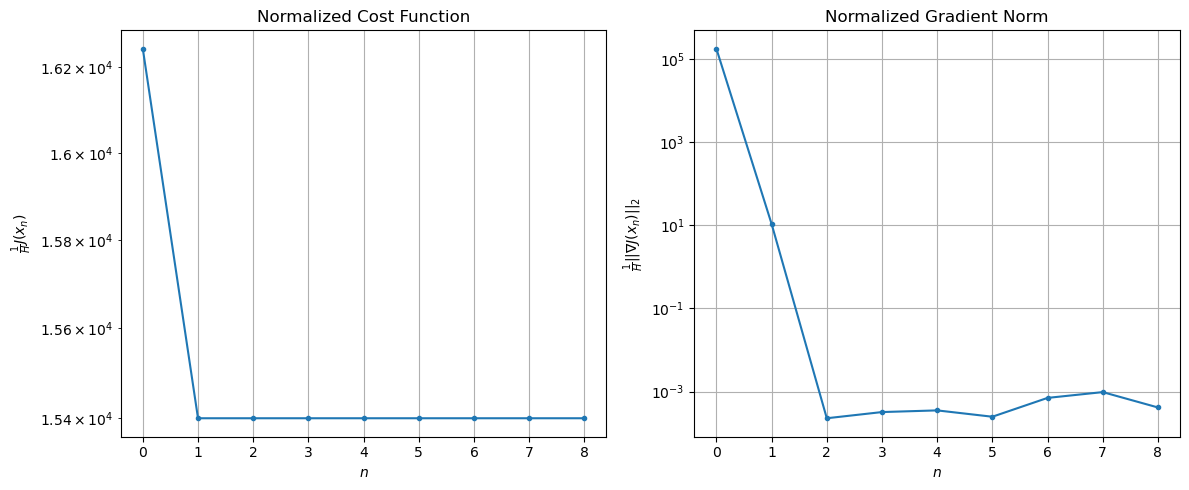

Before applying the algorithm
Cost function: 470916.8743698616
Gradient norm: 5484248.273568424
Global estimation error: 61.3552108171202
Initial conditions estimation errors: 30.169304120159598 m, 24.133636424436272 m, 39.53483311434388 m, 26.622944839821884 m
Position estimation errors: 39.035165735279634 m, 36.2010709281776 m, 36.721665763609614 m, 19.615085834318705 m

Iteration 1
Cost function: 446752.9490783367 (-5.13%)
Gradient norm: 1270.720411570002 (-99.98%)
Global estimation error: 71.59718397177537 (16.69%)
Initial conditions estimation errors: 36.26155459296336 m, 33.37062232785376 m, 40.19702268373256 m, 32.8907484508298 m
Position estimation errors: 32.611770774612395 m, 32.358382804670434 m, 31.503830274704995 m, 28.194095781828647 m

Iteration 2
Cost function: 446752.94438702177 (-0.00%)
Gradient norm: 0.06018058107347131 (-100.00%)
Global estimation error: 71.68251963888737 (0.12%)
Initial conditions estimation errors: 36.261554792160084 m, 33.37072262747861 m, 40.226

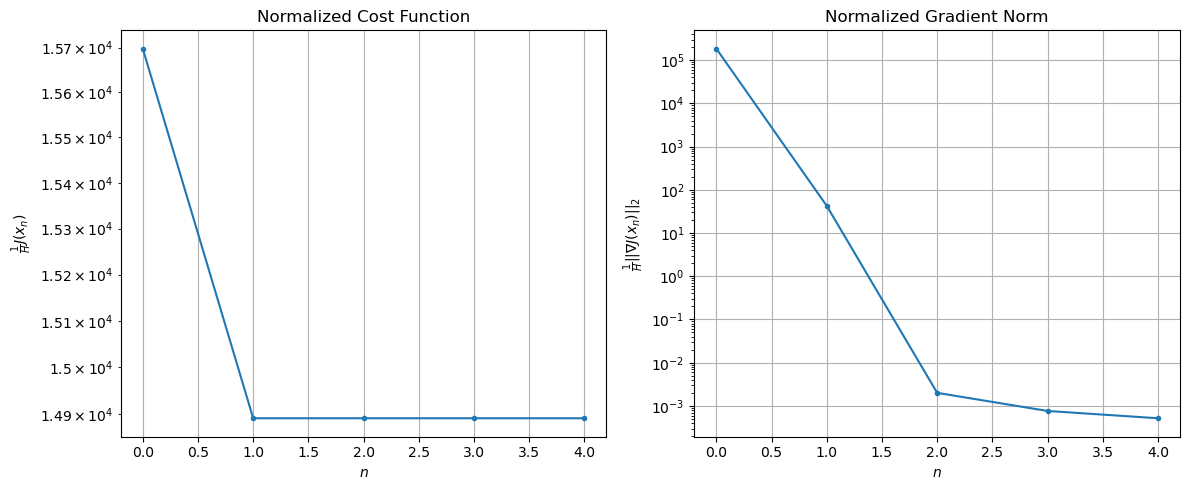

Before applying the algorithm
Cost function: 449439.5358796774
Gradient norm: 5368877.175130816
Global estimation error: 58.50905308745681
Initial conditions estimation errors: 29.747336243927847 m, 26.688880210253103 m, 33.85022703137904 m, 26.0810119033826 m
Position estimation errors: 36.88720019182559 m, 36.81336633115331 m, 35.51247403561942 m, 33.05311089531227 m

Iteration 1
Cost function: 426718.59943901724 (-5.06%)
Gradient norm: 1077.2635891855462 (-99.98%)
Global estimation error: 66.51521664429092 (13.68%)
Initial conditions estimation errors: 35.6629415274642 m, 34.10710555885095 m, 35.38924720129061 m, 27.14194162768725 m
Position estimation errors: 30.644611847258666 m, 33.80719373462025 m, 30.846108812127245 m, 46.017139618046485 m

Iteration 2
Cost function: 426718.5965201954 (-0.00%)
Gradient norm: 0.0741331101327829 (-99.99%)
Global estimation error: 66.60224925899391 (0.13%)
Initial conditions estimation errors: 35.66294136377964 m, 34.10721658748506 m, 35.424470712

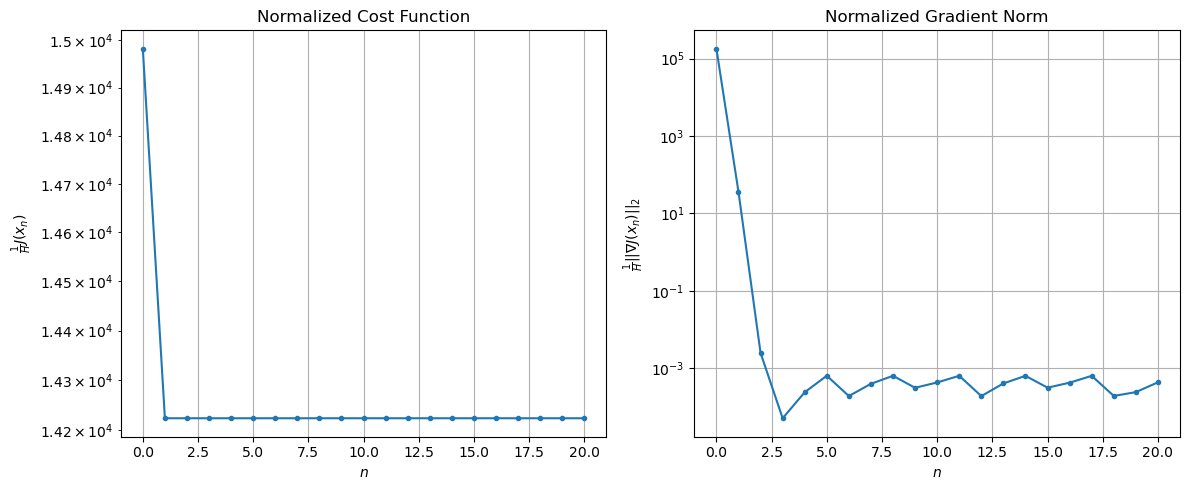

Before applying the algorithm
Cost function: 421377.83815626206
Gradient norm: 5072743.651748056
Global estimation error: 54.12582682096429
Initial conditions estimation errors: 29.139927674910158 m, 27.72621916826043 m, 29.095329081235384 m, 21.567163564755678 m
Position estimation errors: 34.09487577046841 m, 37.22863000108449 m, 34.617095822400714 m, 49.348935842351615 m

Iteration 1
Cost function: 400774.13221801503 (-4.89%)
Gradient norm: 203.69280142328557 (-100.00%)
Global estimation error: 62.36925226003575 (15.23%)
Initial conditions estimation errors: 34.80430956505814 m, 34.38485244121308 m, 33.93466109045211 m, 18.5649398136511 m
Position estimation errors: 28.158075851973987 m, 31.778818207053156 m, 29.520267228287363 m, 54.570145336783234 m

Iteration 2
Cost function: 400774.13170506776 (-0.00%)
Gradient norm: 0.2262440436779668 (-99.89%)
Global estimation error: 62.44025302798214 (0.11%)
Initial conditions estimation errors: 34.80430909347793 m, 34.36482870799378 m, 33.9

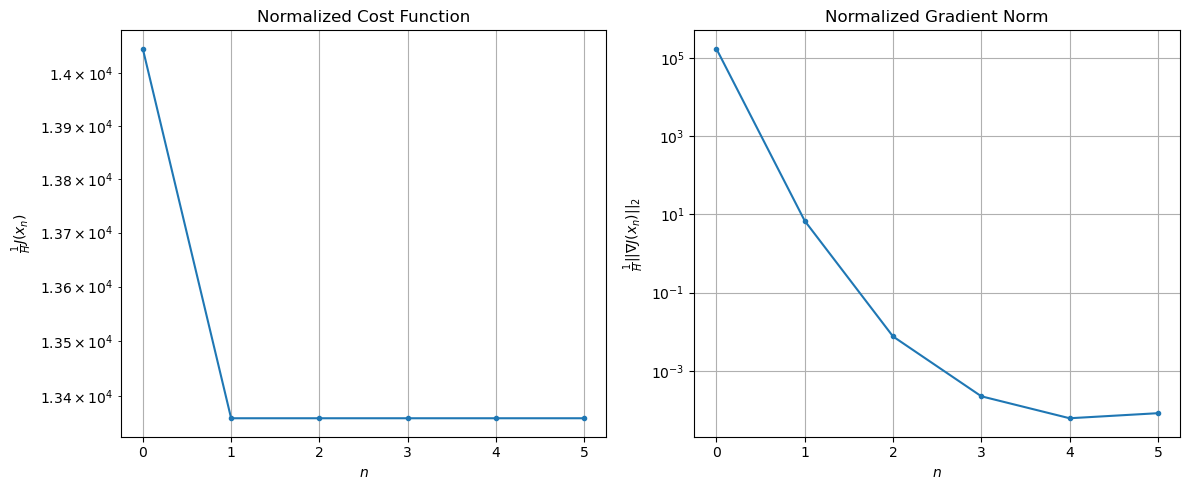

Before applying the algorithm
Cost function: 386858.9329660459
Gradient norm: 4752458.065335839
Global estimation error: 50.41197355025463
Initial conditions estimation errors: 28.30680954165362 m, 28.124538018490465 m, 27.669342446047317 m, 13.545000434395206 m
Position estimation errors: 30.734730357599464 m, 34.28623114821734 m, 32.576969891161035 m, 57.00437468926221 m

Iteration 1
Cost function: 368757.6776209465 (-4.68%)
Gradient norm: 1485.3753964218342 (-99.97%)
Global estimation error: 58.69893287327993 (16.44%)
Initial conditions estimation errors: 33.66330896677358 m, 35.313447861339704 m, 26.882869712621552 m, 18.508856177245857 m
Position estimation errors: 25.191856844403905 m, 32.32631433480933 m, 31.755354443518524 m, 74.77802523606887 m

Iteration 2
Cost function: 368757.67135748704 (-0.00%)
Gradient norm: 0.11720694994799197 (-99.99%)
Global estimation error: 58.78150332277001 (0.14%)
Initial conditions estimation errors: 33.663308249168836 m, 35.310362053438126 m, 26

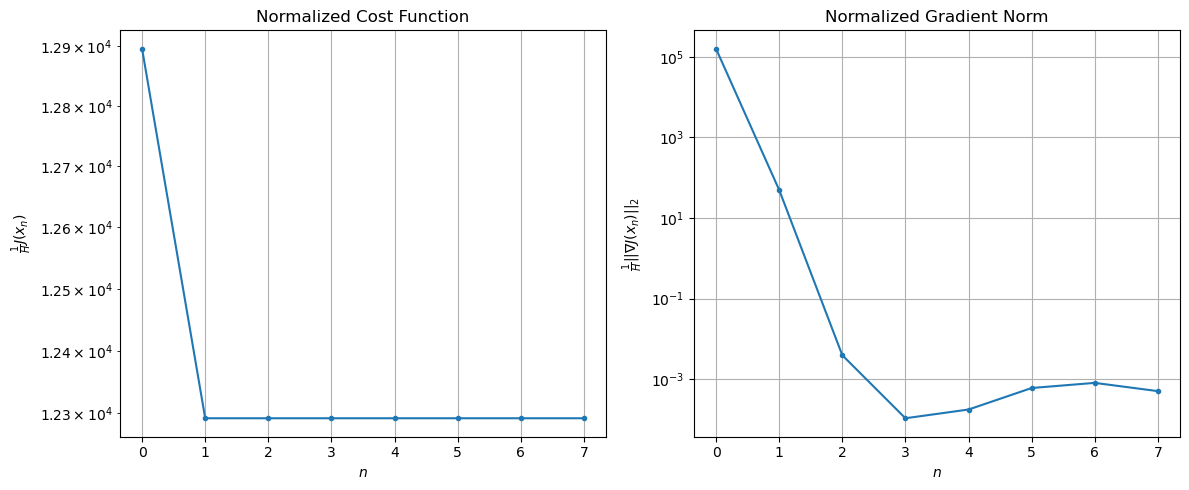

Before applying the algorithm
Cost function: 348735.61634887644
Gradient norm: 4397199.927027959
Global estimation error: 47.79142147413415
Initial conditions estimation errors: 27.259651758066997 m, 29.44239691059361 m, 20.82672868388505 m, 15.501251790809373 m
Position estimation errors: 26.93793397577502 m, 33.77497599381911 m, 34.47682541097874 m, 75.57579090172933 m

Iteration 1
Cost function: 332993.0773009383 (-4.51%)
Gradient norm: 862.9711531625268 (-99.98%)
Global estimation error: 59.117452169027096 (23.70%)
Initial conditions estimation errors: 32.30601275358423 m, 33.236759646929734 m, 28.651567418937127 m, 22.925074033543126 m
Position estimation errors: 21.803973883021794 m, 26.399670886406355 m, 26.5544629292914 m, 51.84084224983581 m

Iteration 2
Cost function: 332993.0754550522 (-0.00%)
Gradient norm: 0.027212110427226294 (-100.00%)
Global estimation error: 59.06829415437149 (-0.08%)
Initial conditions estimation errors: 32.306011868740754 m, 33.23812885229036 m, 28.6

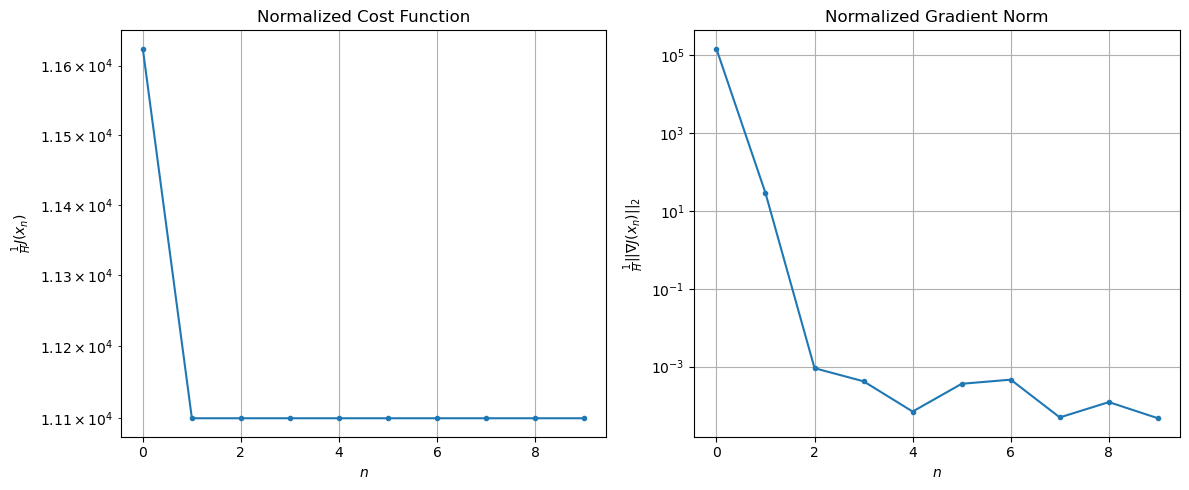

Before applying the algorithm
Cost function: 307876.7088324092
Gradient norm: 3932396.9765751706
Global estimation error: 47.77716290095158
Initial conditions estimation errors: 26.06836969734132 m, 27.34308577229149 m, 22.55603166517468 m, 18.618346363232316 m
Position estimation errors: 22.853565361139058 m, 27.30038152356527 m, 28.412002817873933 m, 52.489432645167305 m

Iteration 1
Cost function: 294778.938741727 (-4.25%)
Gradient norm: 307.41149522726926 (-99.99%)
Global estimation error: 60.39748751123886 (26.41%)
Initial conditions estimation errors: 30.730601550015603 m, 32.32291099824188 m, 29.439054947150705 m, 28.142806860358874 m
Position estimation errors: 18.231665089231672 m, 19.831148803134887 m, 20.954004561482883 m, 35.594441414577986 m

Iteration 2
Cost function: 294778.93847756914 (-0.00%)
Gradient norm: 0.04970408496511322 (-99.98%)
Global estimation error: 60.357647456096224 (-0.07%)
Initial conditions estimation errors: 30.730600577038985 m, 32.31545068758095 m, 

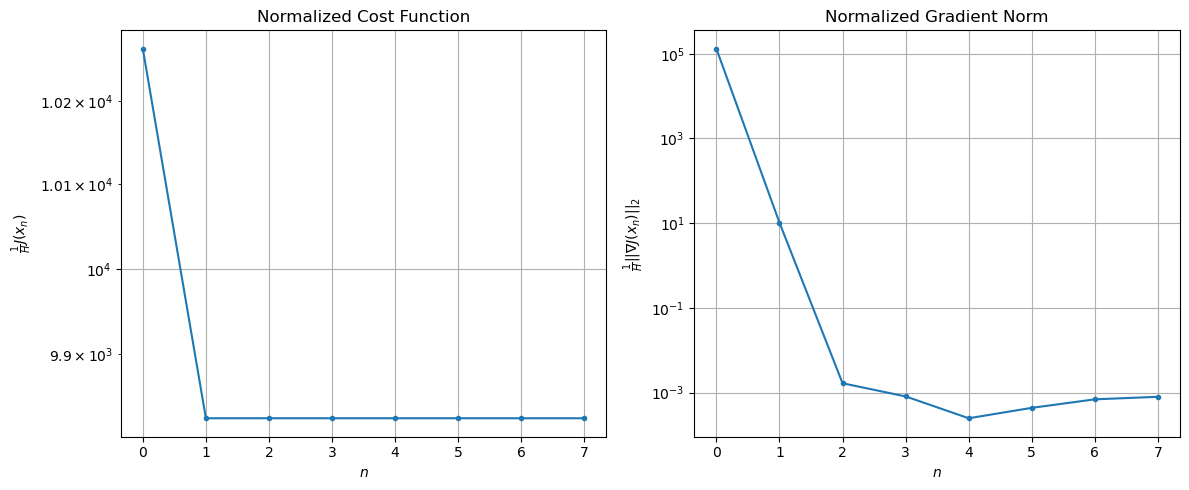

Before applying the algorithm
Cost function: 265146.3991684854
Gradient norm: 3406402.259273595
Global estimation error: 49.017507036617594
Initial conditions estimation errors: 24.706162156147595 m, 26.409423868805032 m, 23.484066455876377 m, 23.30937916687859 m
Position estimation errors: 18.77700986184574 m, 20.268051861939462 m, 21.883387318417473 m, 35.54576427655671 m

Iteration 1
Cost function: 254532.78848401614 (-4.00%)
Gradient norm: 8.02446945959719 (-100.00%)
Global estimation error: 55.92664563548334 (14.10%)
Initial conditions estimation errors: 28.98158886114668 m, 30.184263861387972 m, 27.55421620283881 m, 24.849453187403586 m
Position estimation errors: 14.739907721954383 m, 16.53179363933033 m, 18.18405785306764 m, 33.40223705347666 m

Iteration 2
Cost function: 254532.78847997836 (-0.00%)
Gradient norm: 0.038661730799434184 (-99.52%)
Global estimation error: 55.93446466611684 (0.01%)
Initial conditions estimation errors: 28.981587871778242 m, 30.183728640447658 m, 27

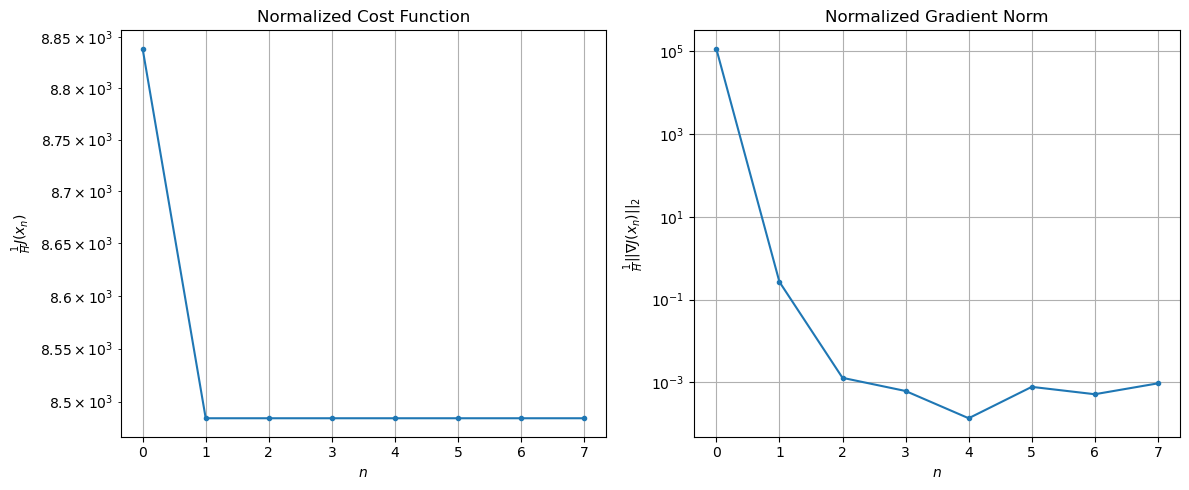

Before applying the algorithm
Cost function: 224191.20514720306
Gradient norm: 2864624.20551427
Global estimation error: 45.04497804630494
Initial conditions estimation errors: 23.167323130417767 m, 24.480011641114277 m, 21.842577767844602 m, 20.394191375815588 m
Position estimation errors: 14.98591926100288 m, 16.69902839356967 m, 18.83493598122958 m, 32.882677349418216 m

Iteration 1
Cost function: 215861.07425667573 (-3.72%)
Gradient norm: 19.49677062558801 (-100.00%)
Global estimation error: 54.41018262542796 (20.79%)
Initial conditions estimation errors: 27.02049148480781 m, 29.0214665030872 m, 24.518432757933624 m, 28.052229524342525 m
Position estimation errors: 11.574400564049037 m, 13.30419808703403 m, 16.094637983063446 m, 30.411402065536493 m

Iteration 2
Cost function: 215861.0742452171 (-0.00%)
Gradient norm: 0.011927692723460545 (-99.94%)
Global estimation error: 54.416366054494496 (0.01%)
Initial conditions estimation errors: 27.02049054737805 m, 29.020495150147017 m, 24

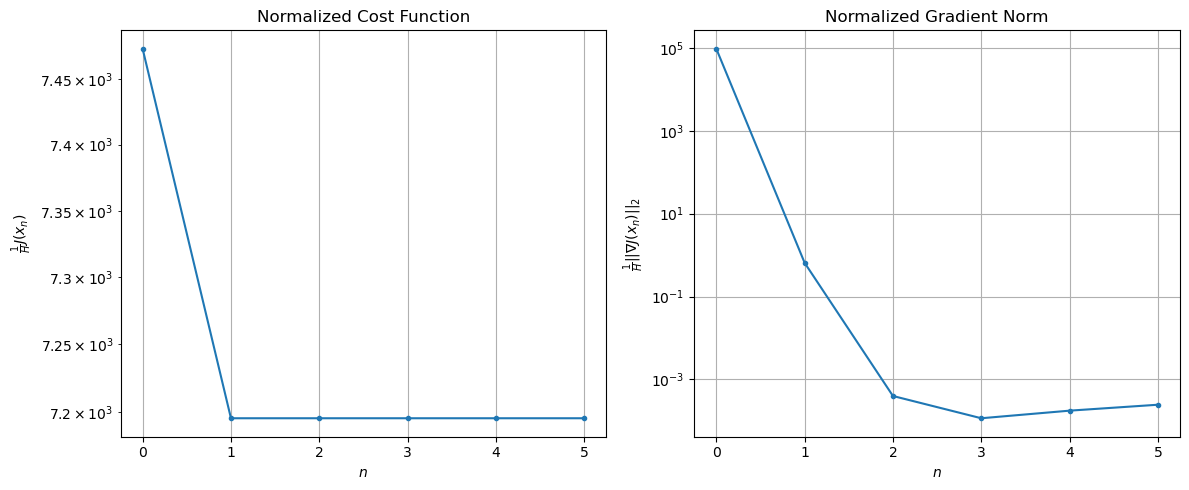

Before applying the algorithm
Cost function: 186157.01735024268
Gradient norm: 2291563.0017418773
Global estimation error: 44.01135882660795
Initial conditions estimation errors: 21.376409452535356 m, 23.475167209799537 m, 19.071585866037868 m, 23.77412180171101 m
Position estimation errors: 11.695239182946324 m, 13.31468199575124 m, 16.536600049111506 m, 29.363008567999834 m

Iteration 1
Cost function: 179649.2465586619 (-3.50%)
Gradient norm: 153.16812179399432 (-99.99%)
Global estimation error: 53.4119026207589 (21.36%)
Initial conditions estimation errors: 24.845375315609004 m, 28.205192195246887 m, 21.3495578598797 m, 31.37150209526504 m
Position estimation errors: 8.966325501534833 m, 10.363995627295001 m, 14.78357573125735 m, 32.44152347599164 m

Iteration 2
Cost function: 179649.24645438907 (-0.00%)
Gradient norm: 0.019949924462060967 (-99.99%)
Global estimation error: 53.40804545862186 (-0.01%)
Initial conditions estimation errors: 24.845374486923852 m, 28.202934062881557 m, 2

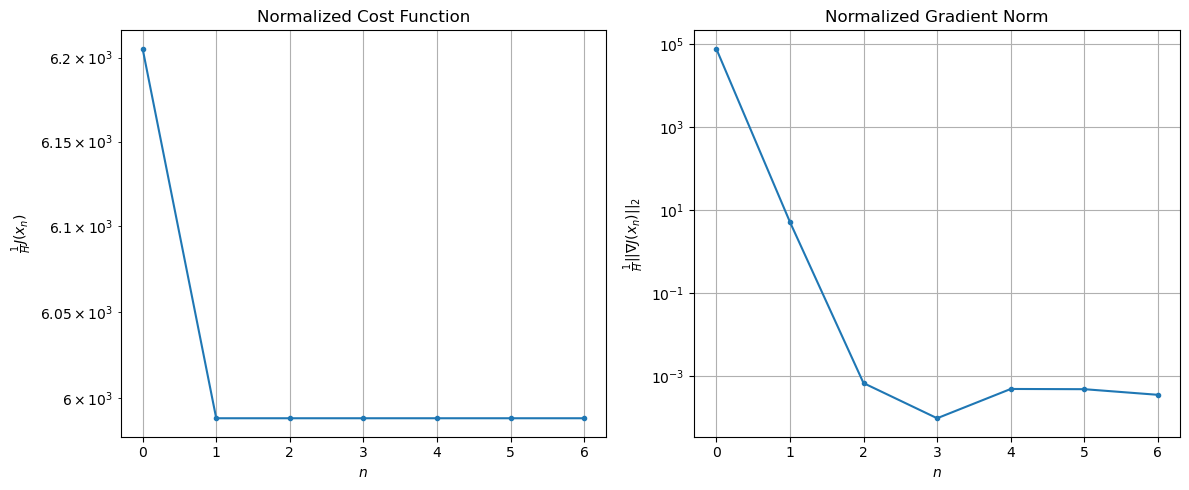

Before applying the algorithm
Cost function: 152878.8598533454
Gradient norm: 1666039.8327693585
Global estimation error: 43.79581919680342
Initial conditions estimation errors: 19.34001362964455 m, 22.80951642029231 m, 16.261714218009036 m, 27.555254462693142 m
Position estimation errors: 9.12765949260155 m, 10.279148884010146 m, 14.996181707570694 m, 30.654803220896937 m

Iteration 1
Cost function: 148119.53306313822 (-3.11%)
Gradient norm: 236.36574730476977 (-99.99%)
Global estimation error: 46.30616653064052 (5.73%)
Initial conditions estimation errors: 22.373343285097103 m, 24.237356105850395 m, 20.656315508553664 m, 25.09044365124191 m
Position estimation errors: 7.2899197960746225 m, 8.297952533210118 m, 11.88997221412608 m, 21.016138183773734 m

Iteration 2
Cost function: 148119.53278384553 (-0.00%)
Gradient norm: 0.026111026050504454 (-99.99%)
Global estimation error: 46.30536156782732 (-0.00%)
Initial conditions estimation errors: 22.373342611925843 m, 24.240183350687207 m, 

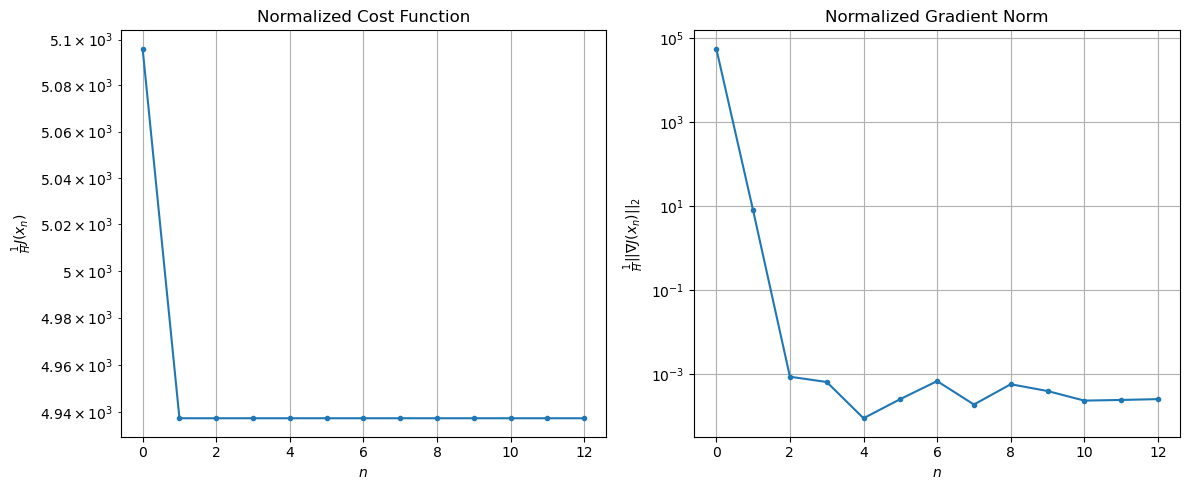

Before applying the algorithm
Cost function: 126179.70946011224
Gradient norm: 986229.2194308144
Global estimation error: 36.43122802003186
Initial conditions estimation errors: 17.053851375810538 m, 18.972429834063046 m, 15.544513278672714 m, 20.851567523632863 m
Position estimation errors: 7.705412772308341 m, 8.509208097800101 m, 12.219692990224457 m, 19.721650037325055 m

Iteration 1
Cost function: 122803.43092328991 (-2.68%)
Gradient norm: 123.01370003047522 (-99.99%)
Global estimation error: 41.07672864408166 (12.75%)
Initial conditions estimation errors: 19.656485216455792 m, 20.716399265817547 m, 18.744792892692885 m, 22.81125664128915 m
Position estimation errors: 6.783172067207331 m, 7.321823404049786 m, 9.373825134166736 m, 12.206485400163213 m

Iteration 2
Cost function: 122803.43088454766 (-0.00%)
Gradient norm: 0.005488957922687105 (-100.00%)
Global estimation error: 41.08415686043545 (0.02%)
Initial conditions estimation errors: 19.656484718285526 m, 20.71759123105981 m,

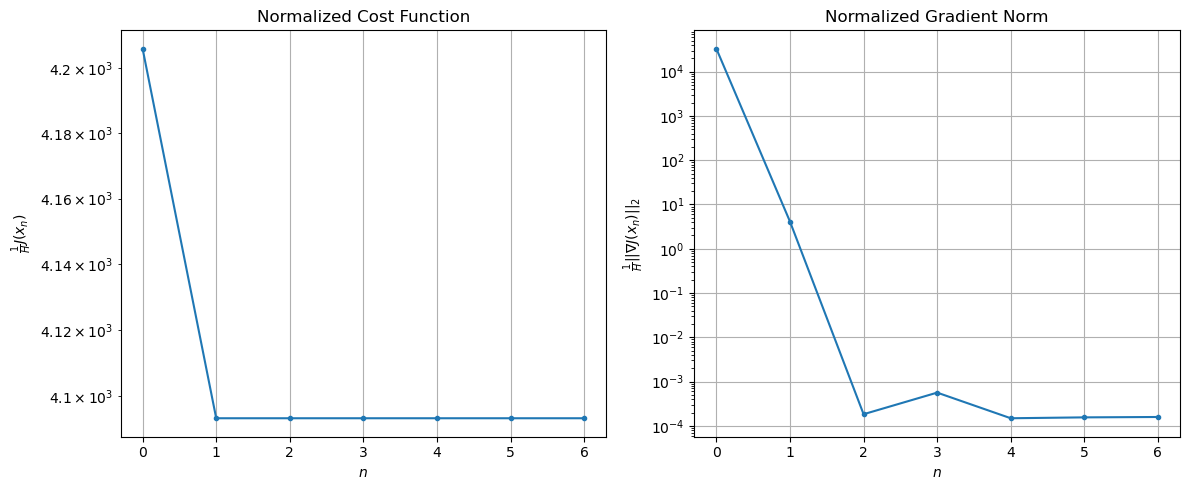

Before applying the algorithm
Cost function: 106839.29828967668
Gradient norm: 932698.4650180747
Global estimation error: 31.51956952226714
Initial conditions estimation errors: 14.668918929689468 m, 15.714639768912384 m, 13.924659497844525 m, 18.36939901570168 m
Position estimation errors: 7.659145027626542 m, 8.038285216700539 m, 9.809826050823567 m, 11.460581211152503 m

Iteration 1
Cost function: 104492.54107272171 (-2.20%)
Gradient norm: 9.669670231175962 (-100.00%)
Global estimation error: 34.70382227139019 (10.10%)
Initial conditions estimation errors: 16.85187953026112 m, 17.64362425613441 m, 15.868822446446433 m, 18.90043666071731 m
Position estimation errors: 7.332592247406911 m, 7.928937610749979 m, 9.279291448479004 m, 12.862677875804625 m

Iteration 2
Cost function: 104492.54107179359 (-0.00%)
Gradient norm: 0.006931172850119253 (-99.93%)
Global estimation error: 34.70607478408858 (0.01%)
Initial conditions estimation errors: 16.851879202295606 m, 17.643965148814623 m, 15.

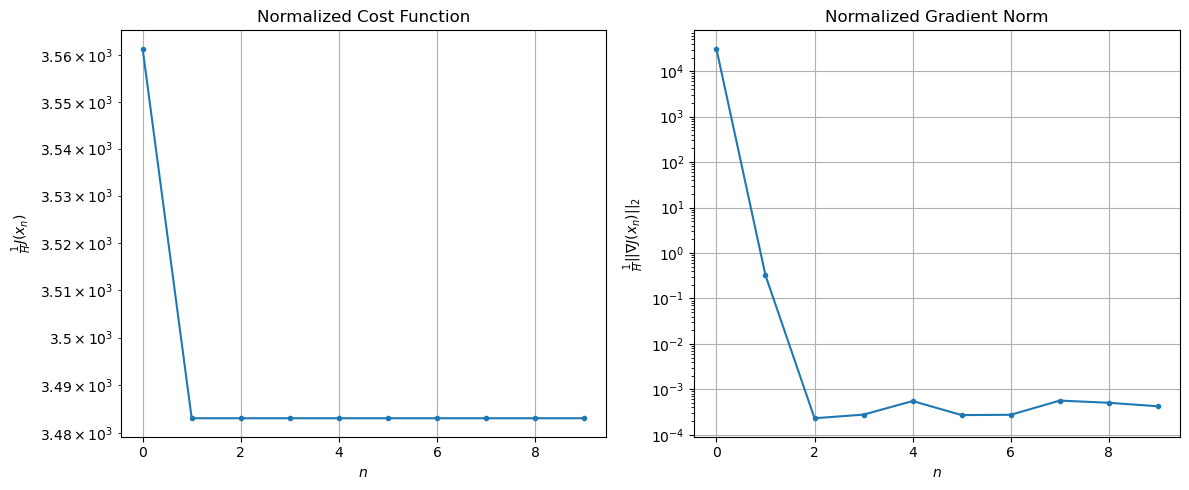

Before applying the algorithm
Cost function: 93709.53424446708
Gradient norm: 1463651.5188290067
Global estimation error: 26.270456585423414
Initial conditions estimation errors: 12.397334313448265 m, 13.15101029675463 m, 11.694835096930902 m, 15.056712532037421 m
Position estimation errors: 8.771288549151777 m, 8.96358090940043 m, 9.836970663386742 m, 12.138544640984005 m

Iteration 1
Cost function: 92073.31582767633 (-1.75%)
Gradient norm: 67.77081457694976 (-100.00%)
Global estimation error: 30.12389301521479 (14.67%)
Initial conditions estimation errors: 14.20632831255645 m, 15.461350207464205 m, 13.209177755574004 m, 17.090162640413663 m
Position estimation errors: 8.623442459359056 m, 8.744893132784291 m, 9.37076719227902 m, 15.643522210268168 m

Iteration 2
Cost function: 92073.31581482333 (-0.00%)
Gradient norm: 0.015193830786629501 (-99.98%)
Global estimation error: 30.115228922862382 (-0.03%)
Initial conditions estimation errors: 14.206328131354537 m, 15.459182027182095 m, 13

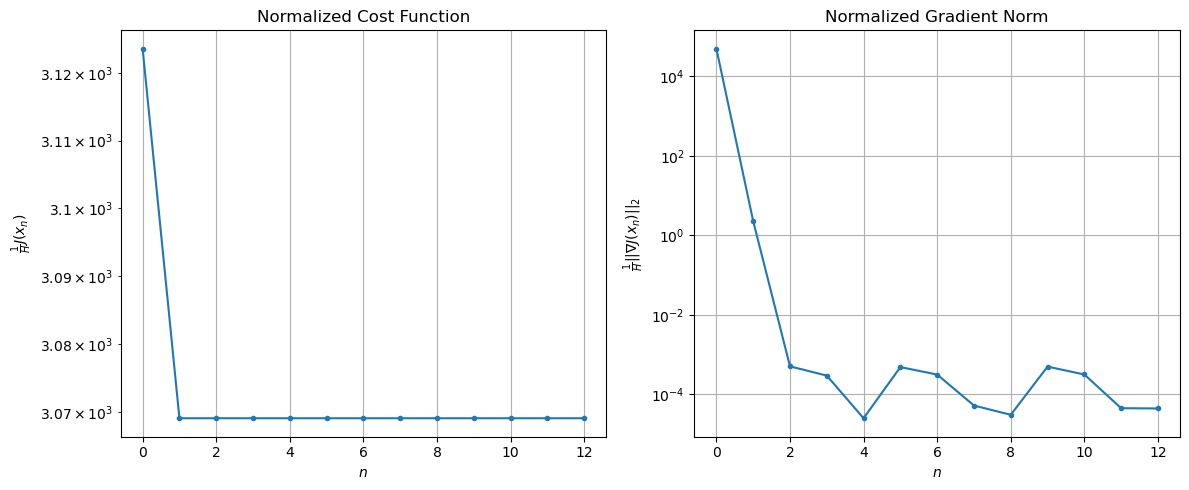

Before applying the algorithm
Cost function: 87776.58464557328
Gradient norm: 2343507.439327382
Global estimation error: 23.186162685020296
Initial conditions estimation errors: 10.444055632965693 m, 11.562222271659929 m, 9.94237321105339 m, 13.998899249979171 m
Position estimation errors: 10.607822813651955 m, 10.293548359798246 m, 10.235762073724878 m, 14.748748576805648 m

Iteration 1
Cost function: 86569.13766195647 (-1.38%)
Gradient norm: 349.14552554819625 (-99.99%)
Global estimation error: 22.600316305307928 (-2.53%)
Initial conditions estimation errors: 11.832675559186821 m, 11.036268013754349 m, 12.08419808711471 m, 10.144873740757518 m
Position estimation errors: 10.18998074310929 m, 9.651978261131886 m, 10.60896257560018 m, 7.793551109683779 m

Iteration 2
Cost function: 86569.13710022553 (-0.00%)
Gradient norm: 0.012819009246110968 (-100.00%)
Global estimation error: 22.608924403803282 (0.04%)
Initial conditions estimation errors: 11.832675482799482 m, 11.041476385257672 m,

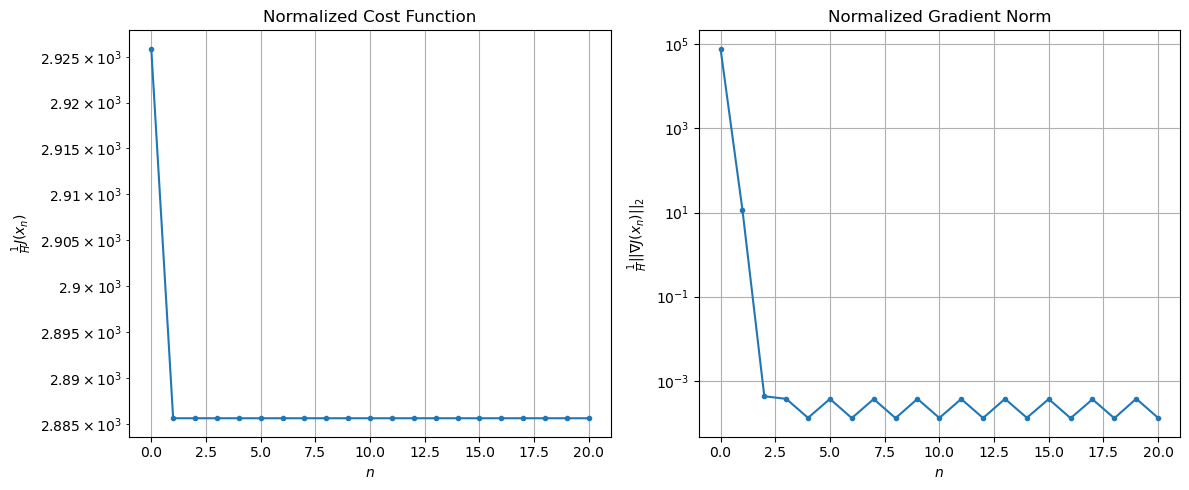

Before applying the algorithm
Cost function: 87332.47872887558
Gradient norm: 3046459.253363153
Global estimation error: 16.927363671217392
Initial conditions estimation errors: 8.827817603836833 m, 7.992133696442352 m, 8.889923958254796 m, 8.104783701331556 m
Position estimation errors: 12.6657170503273 m, 11.797743581716535 m, 12.41320472716681 m, 9.556262031748766 m

Iteration 1
Cost function: 86236.36956838386 (-1.26%)
Gradient norm: 702.9634023594448 (-99.98%)
Global estimation error: 18.781655585133304 (10.95%)
Initial conditions estimation errors: 9.91588760808837 m, 7.668980910055786 m, 10.573961871591388 m, 9.153604801375106 m
Position estimation errors: 11.902456161657176 m, 11.296705556247051 m, 14.535895207489297 m, 17.90784077645331 m

Iteration 2
Cost function: 86236.36767444792 (-0.00%)
Gradient norm: 0.008796709661140855 (-100.00%)
Global estimation error: 18.77142248702245 (-0.05%)
Initial conditions estimation errors: 9.915887574728641 m, 7.670664360327632 m, 10.57386

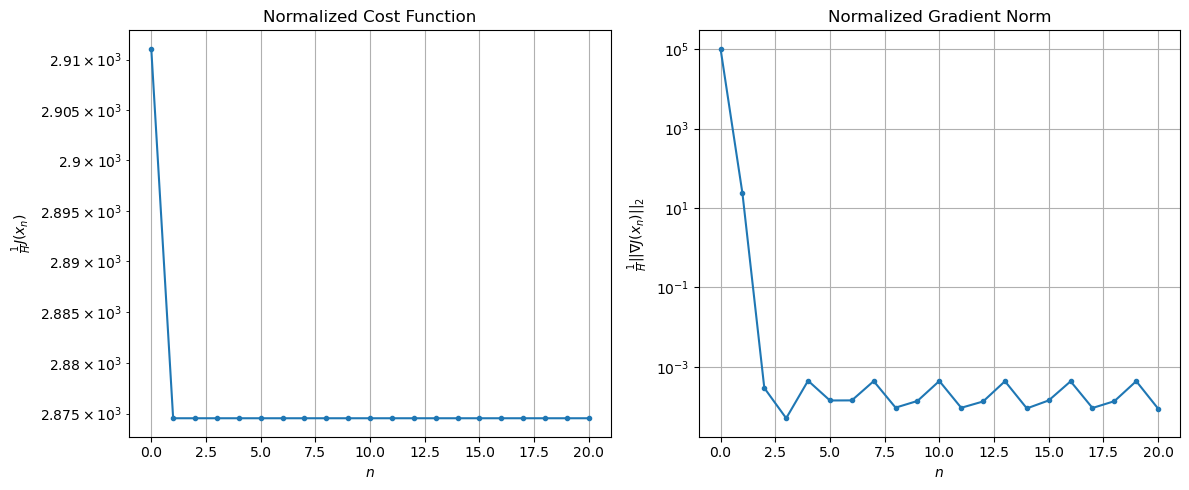

Before applying the algorithm
Cost function: 92418.81448498002
Gradient norm: 3918254.8654251695
Global estimation error: 16.752280731446856
Initial conditions estimation errors: 7.656582213895692 m, 6.115610915808217 m, 7.3836083307506435 m, 11.405474701866229 m
Position estimation errors: 14.808453555093958 m, 13.997195931487207 m, 17.073250098125325 m, 19.846357514747112 m

Iteration 1
Cost function: 91118.5315712772 (-1.41%)
Gradient norm: 31.252029308736237 (-100.00%)
Global estimation error: 16.95872752012186 (1.23%)
Initial conditions estimation errors: 8.497133558404913 m, 7.272095584405237 m, 8.276834630186498 m, 9.695137560805136 m
Position estimation errors: 13.56077237268979 m, 12.65616123256046 m, 15.146034537069871 m, 17.52472046905269 m

Iteration 2
Cost function: 91118.53155406796 (-0.00%)
Gradient norm: 0.021565391497962612 (-99.93%)
Global estimation error: 16.960650169512707 (0.01%)
Initial conditions estimation errors: 8.49713348917255 m, 7.2718181775996875 m, 8.276

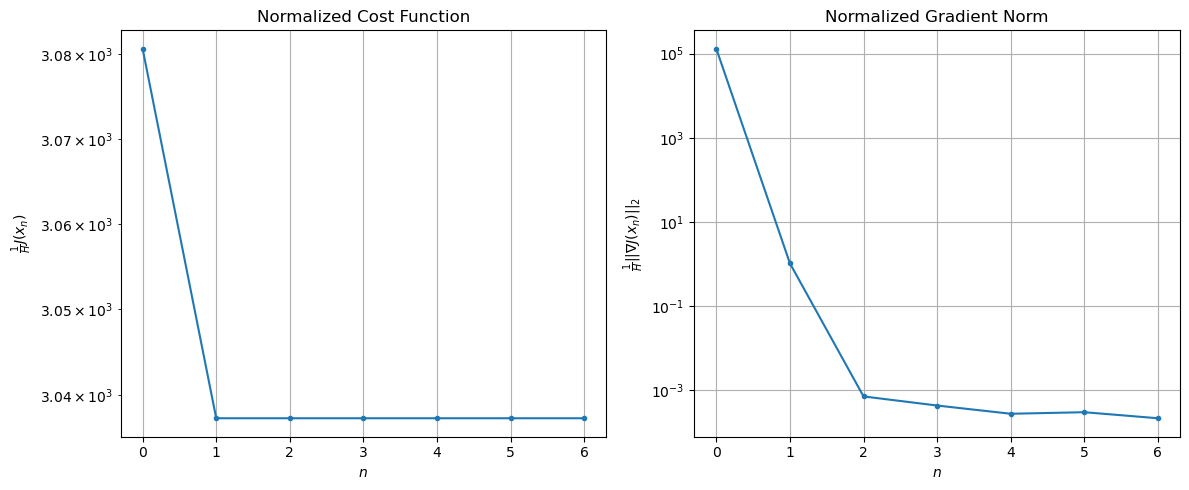

Before applying the algorithm
Cost function: 101839.01619308945
Gradient norm: 4570189.983207651
Global estimation error: 15.629252997918693
Initial conditions estimation errors: 6.993843165027753 m, 6.520768156962653 m, 6.083462724822644 m, 10.762000965524537 m
Position estimation errors: 16.81577865089392 m, 15.731484436939128 m, 18.244688471731756 m, 19.960265985112507 m

Iteration 1
Cost function: 100125.19768694766 (-1.68%)
Gradient norm: 57.48968413456206 (-100.00%)
Global estimation error: 14.723838665107188 (-5.79%)
Initial conditions estimation errors: 7.7602107964487805 m, 7.207708605663674 m, 7.07221624647365 m, 7.388697699849999 m
Position estimation errors: 15.10598704971262 m, 14.870216893225262 m, 18.434907860366597 m, 25.537085446784797 m

Iteration 2
Cost function: 100125.19765041488 (-0.00%)
Gradient norm: 0.023866853989354217 (-99.96%)
Global estimation error: 14.722661343969069 (-0.01%)
Initial conditions estimation errors: 7.760210642699173 m, 7.20836152042883 m, 7

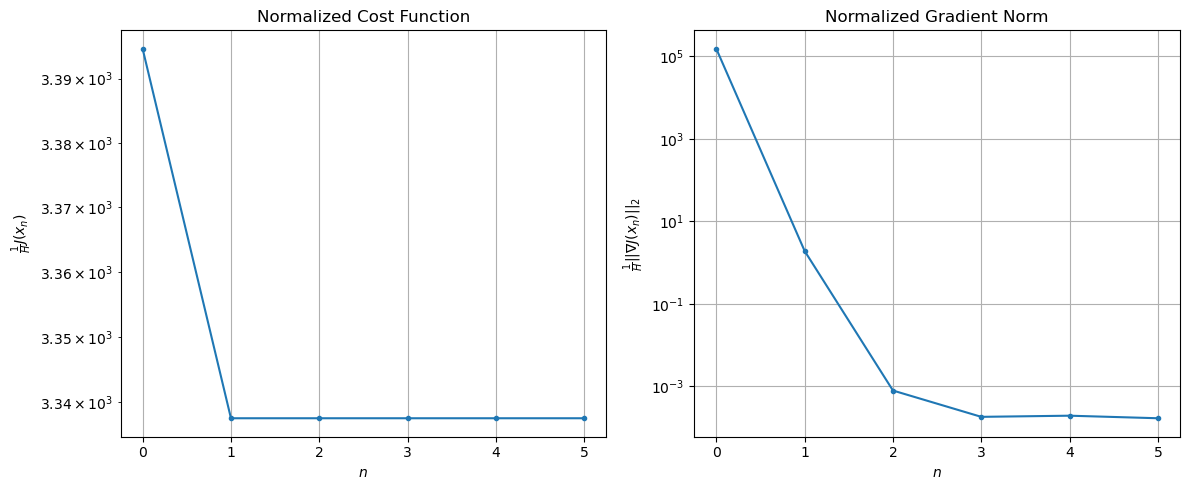

Before applying the algorithm
Cost function: 114700.83582434143
Gradient norm: 5098016.878755732
Global estimation error: 13.647312073758663
Initial conditions estimation errors: 7.024413172795999 m, 7.137780288303966 m, 5.673532867591611 m, 7.332198379978522 m
Position estimation errors: 18.628917313981088 m, 18.38552614595013 m, 22.122234961991964 m, 28.34060269923175 m

Iteration 1
Cost function: 112457.10402023704 (-1.96%)
Gradient norm: 79.92239372977345 (-100.00%)
Global estimation error: 21.1205865421453 (54.76%)
Initial conditions estimation errors: 7.866701765582886 m, 8.562321420094463 m, 7.633236066924941 m, 15.89359926595831 m
Position estimation errors: 16.493115363630398 m, 15.79363322911812 m, 17.94786542575265 m, 19.413898467969865 m

Iteration 2
Cost function: 112457.10395359578 (-0.00%)
Gradient norm: 0.0061994362660420296 (-99.99%)
Global estimation error: 21.17789697003145 (0.27%)
Initial conditions estimation errors: 7.866701568531101 m, 8.567559031865793 m, 7.6356

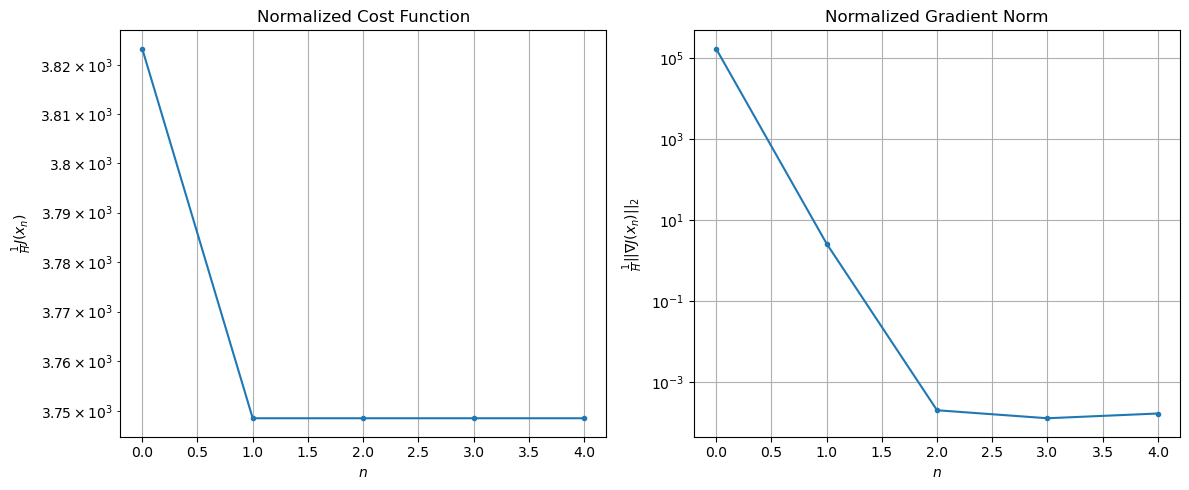

Before applying the algorithm
Cost function: 129836.76957288409
Gradient norm: 5551711.369905761
Global estimation error: 22.13149187013878
Initial conditions estimation errors: 7.756268395191999 m, 8.885337762373993 m, 7.402795879602641 m, 17.201334149894038 m
Position estimation errors: 20.19971188924905 m, 19.469230772475548 m, 21.612126414717597 m, 22.673571909002785 m

Iteration 1
Cost function: 126950.77704735805 (-2.22%)
Gradient norm: 19.730060181477516 (-100.00%)
Global estimation error: 30.03505379913256 (35.71%)
Initial conditions estimation errors: 8.812224529848407 m, 11.186895813562263 m, 9.419695148537459 m, 24.70961240963449 m
Position estimation errors: 17.671979946103914 m, 16.078316414383014 m, 18.98604093251514 m, 18.48889354471038 m

Iteration 2
Cost function: 126950.77702740219 (-0.00%)
Gradient norm: 0.01406288950022703 (-99.93%)
Global estimation error: 30.044502002776024 (0.03%)
Initial conditions estimation errors: 8.812224377999616 m, 11.188089699017995 m, 9.

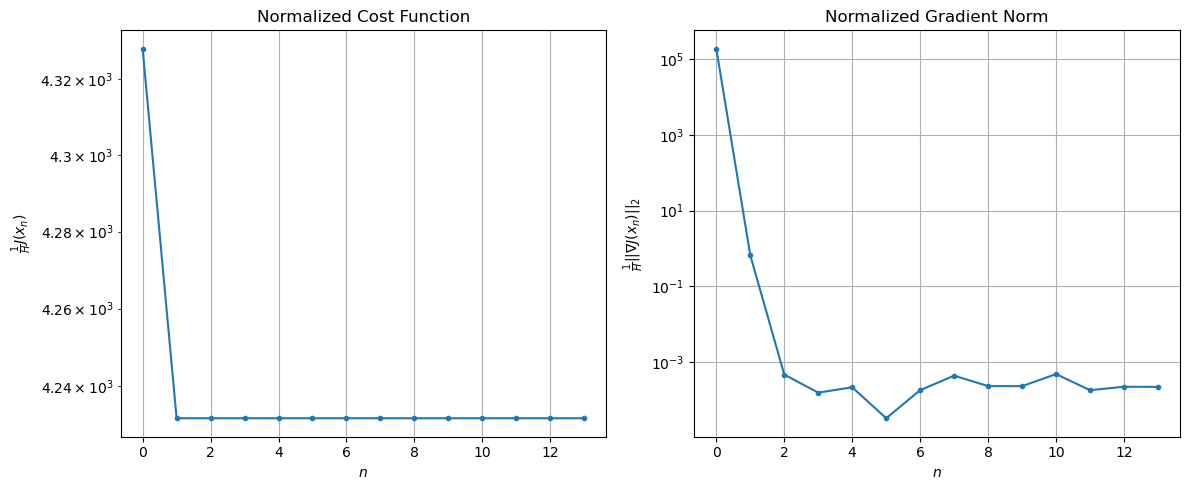

Before applying the algorithm
Cost function: 146058.98532962115
Gradient norm: 5793933.698535423
Global estimation error: 30.950443082470013
Initial conditions estimation errors: 8.997369043420692 m, 11.4737901565083 m, 9.562005785557316 m, 25.571303082488612 m
Position estimation errors: 21.480304408441093 m, 19.672738153167295 m, 22.639596235826204 m, 21.477545203477867 m

Iteration 1
Cost function: 142404.37970413468 (-2.50%)
Gradient norm: 160.35996304839406 (-100.00%)
Global estimation error: 38.84064308671831 (25.49%)
Initial conditions estimation errors: 10.406434897977517 m, 14.448118255049147 m, 11.15693004414105 m, 32.66604745786537 m
Position estimation errors: 18.59308873133908 m, 16.717942958001338 m, 21.446845975916943 m, 23.97704625353283 m

Iteration 2
Cost function: 142404.379572 (-0.00%)
Gradient norm: 0.005612592971274273 (-100.00%)
Global estimation error: 38.84004599090066 (-0.00%)
Initial conditions estimation errors: 10.406434893305589 m, 14.447928354341693 m, 11

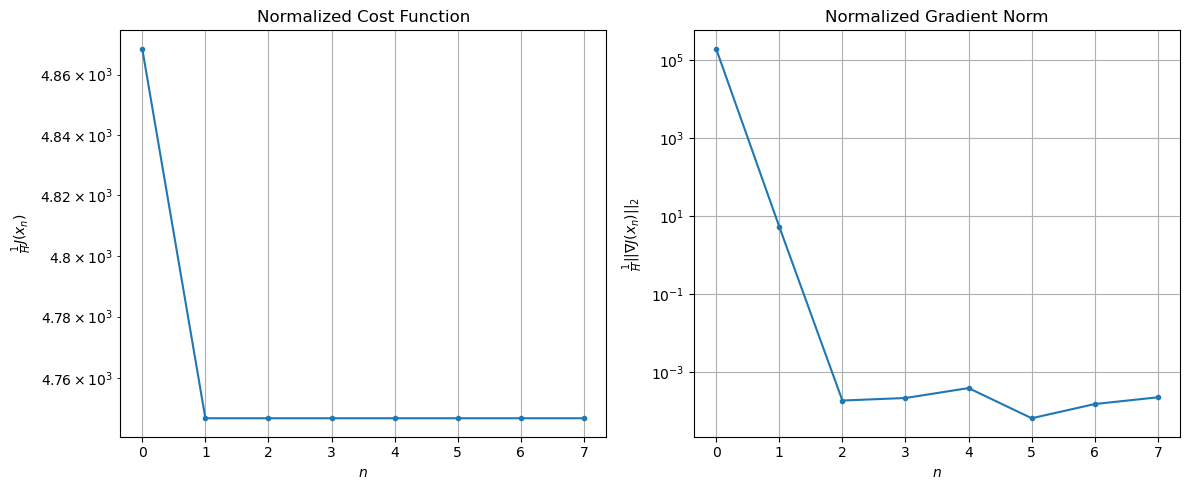

Before applying the algorithm
Cost function: 162072.28128613855
Gradient norm: 5968824.792983028
Global estimation error: 40.037061426338404
Initial conditions estimation errors: 10.540248536535792 m, 14.587984931488998 m, 11.556540008309574 m, 33.84525645564214 m
Position estimation errors: 22.443604547318003 m, 20.340830643479286 m, 25.07073484976225 m, 26.46826997721524 m

Iteration 1
Cost function: 157602.13389544009 (-2.76%)
Gradient norm: 78.05931280537058 (-100.00%)
Global estimation error: 43.78903366795108 (9.37%)
Initial conditions estimation errors: 12.317980349729767 m, 16.16863365478763 m, 13.70323197628789 m, 36.28413816375416 m
Position estimation errors: 19.24686146296932 m, 16.616076550100388 m, 20.509214608377185 m, 17.749462168129174 m

Iteration 2
Cost function: 157602.13386960689 (-0.00%)
Gradient norm: 0.017167979543222564 (-99.98%)
Global estimation error: 43.8366426927386 (0.11%)
Initial conditions estimation errors: 12.31798052953766 m, 16.17625924175029 m, 13.

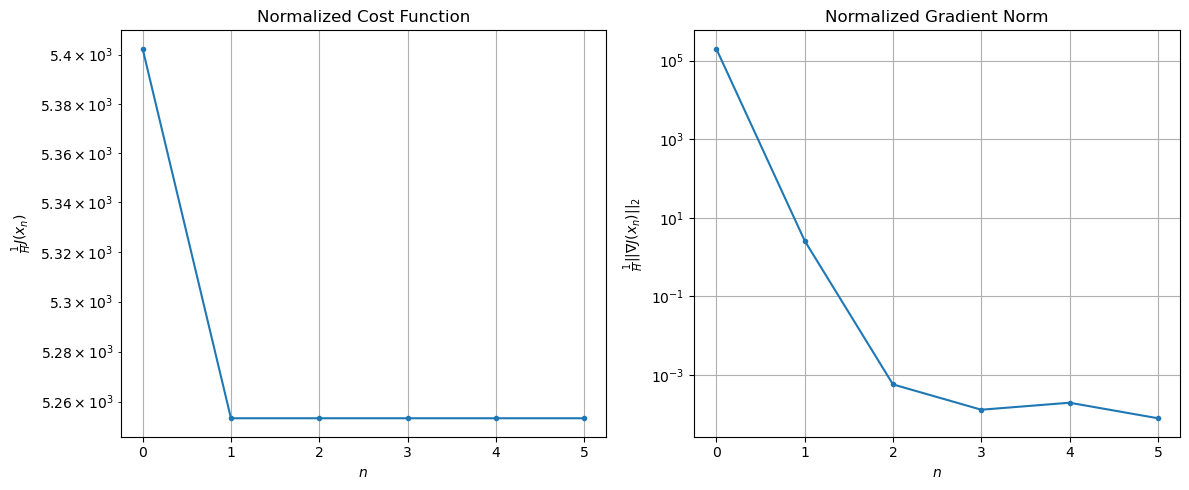

Before applying the algorithm
Cost function: 176486.1841559536
Gradient norm: 5988568.158374971
Global estimation error: 43.56480261360321
Initial conditions estimation errors: 12.112049192342086 m, 15.82221830964065 m, 13.686540383098277 m, 36.24253541259042 m
Position estimation errors: 23.09749999182345 m, 20.15528217312196 m, 24.08700426969539 m, 20.562756728688424 m

Iteration 1
Cost function: 171181.20487227823 (-3.01%)
Gradient norm: 1529.2035123042292 (-99.97%)
Global estimation error: 65.30517676401494 (49.90%)
Initial conditions estimation errors: 14.301820316305525 m, 21.242654307550346 m, 16.821195144392274 m, 57.671621574951715 m
Position estimation errors: 19.659649359816736 m, 17.125985724672557 m, 27.86647801823551 m, 35.349241075472726 m

Iteration 2
Cost function: 171181.1922454415 (-0.00%)
Gradient norm: 0.6315687563417567 (-99.96%)
Global estimation error: 64.86123059027558 (-0.68%)
Initial conditions estimation errors: 14.30182068943757 m, 21.175403157734458 m, 16.

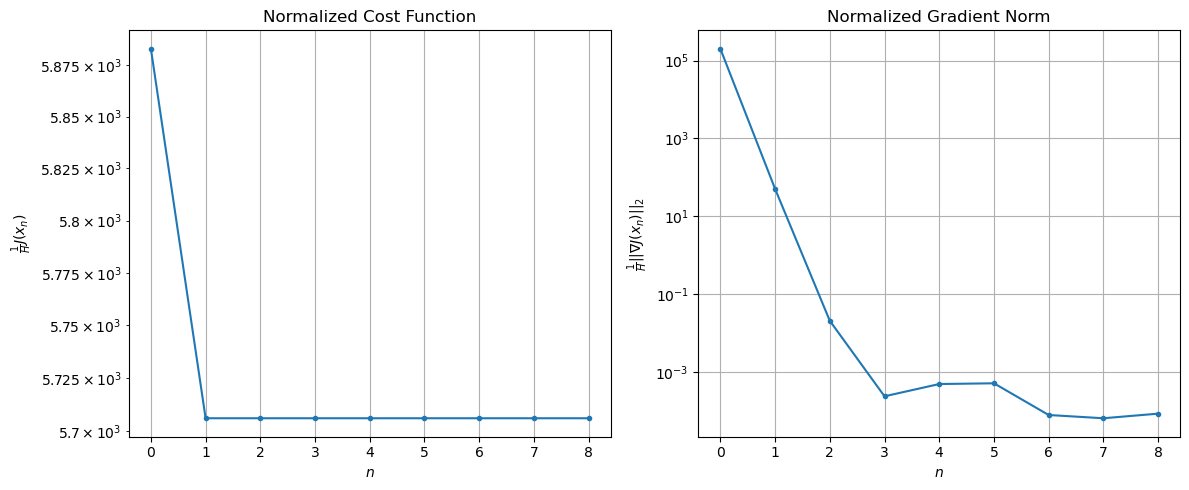

Before applying the algorithm
Cost function: 188593.5936064069
Gradient norm: 5940793.427120181
Global estimation error: 65.53319578735635
Initial conditions estimation errors: 13.564496166739454 m, 20.363240279288846 m, 17.151134028048872 m, 58.324745794646866 m
Position estimation errors: 23.498909810584298 m, 20.55397413449329 m, 31.03485102395117 m, 35.860339811142566 m

Iteration 1
Cost function: 182479.1023146672 (-3.24%)
Gradient norm: 1649.1526835324958 (-99.97%)
Global estimation error: 44.24344646050998 (-32.49%)
Initial conditions estimation errors: 16.160594253366817 m, 19.139815344505525 m, 16.940208586865452 m, 32.2956548279042 m
Position estimation errors: 19.872161077704714 m, 17.23764889720178 m, 22.052937575584565 m, 17.129476089628284 m

Iteration 2
Cost function: 182479.08001968297 (-0.00%)
Gradient norm: 0.15767960117061744 (-99.99%)
Global estimation error: 44.44270336711898 (0.45%)
Initial conditions estimation errors: 16.160594769257877 m, 19.173000064356767 m, 

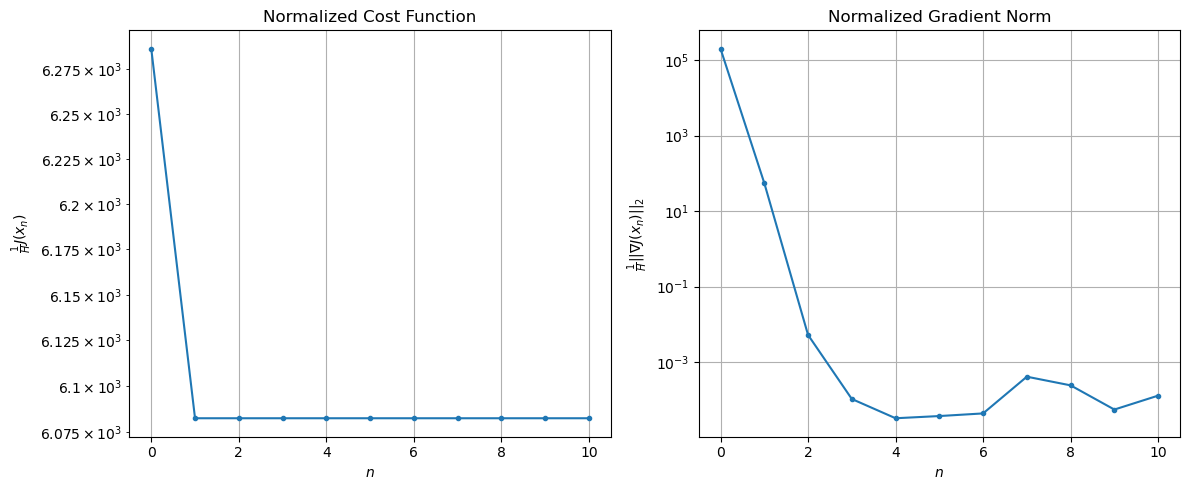

Before applying the algorithm
Cost function: 197052.51669943513
Gradient norm: 5764256.247579821
Global estimation error: 41.8534405172658
Initial conditions estimation errors: 14.801981014635313 m, 17.67195589334124 m, 15.90866168895112 m, 31.100182083622983 m
Position estimation errors: 23.7068619084391 m, 20.86985120066033 m, 25.84190842227377 m, 20.28633670861514 m

Iteration 1
Cost function: 190235.0289168272 (-3.46%)
Gradient norm: 85.81300724864263 (-100.00%)
Global estimation error: 49.38415969728954 (17.99%)
Initial conditions estimation errors: 17.771749872685906 m, 21.41233635169013 m, 19.535903490395338 m, 35.816389099559586 m
Position estimation errors: 19.95897458896323 m, 16.89728115317843 m, 22.414076753493596 m, 21.0365474586647 m

Iteration 2
Cost function: 190235.02889328104 (-0.00%)
Gradient norm: 0.004593195458023532 (-99.99%)
Global estimation error: 49.41517870208609 (0.06%)
Initial conditions estimation errors: 17.77175049366484 m, 21.41843354125529 m, 19.540242

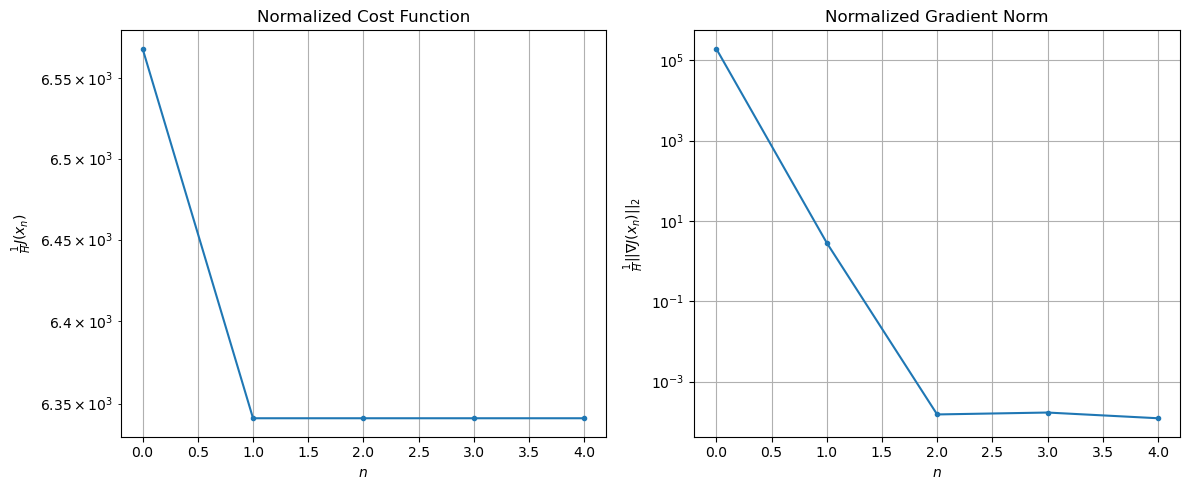

Before applying the algorithm
Cost function: 202186.4922835405
Gradient norm: 5693309.718684455
Global estimation error: 45.98721476554512
Initial conditions estimation errors: 15.76438806137955 m, 19.25408624381972 m, 18.000531760494017 m, 34.22805690640808 m
Position estimation errors: 23.797158672122432 m, 20.52301778695825 m, 26.03400957178034 m, 23.773561467164573 m

Iteration 1
Cost function: 194502.16425174783 (-3.80%)
Gradient norm: 3659.8760851932384 (-99.94%)
Global estimation error: 95.90991033552662 (108.56%)
Initial conditions estimation errors: 19.12622741158447 m, 27.90772560015919 m, 29.0120954271832 m, 84.9255356431778 m
Position estimation errors: 19.904889982382397 m, 15.926194989151643 m, 29.443222911553832 m, 42.58960641497408 m

Iteration 2
Cost function: 194502.03798987708 (-0.00%)
Gradient norm: 0.40318324277543205 (-99.99%)
Global estimation error: 96.32304125647266 (0.43%)
Initial conditions estimation errors: 19.126228065404643 m, 27.96343364694037 m, 29.0905

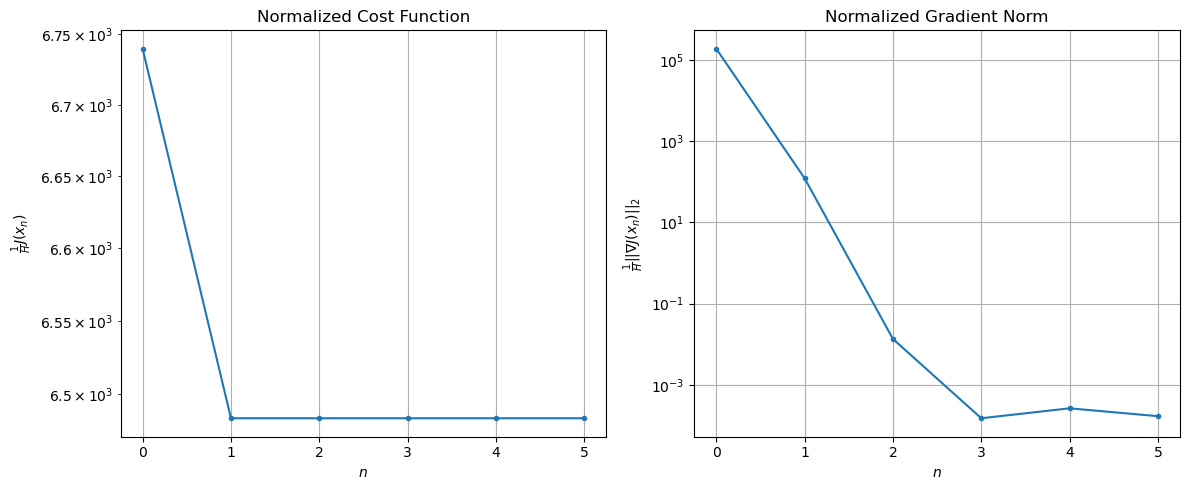

Before applying the algorithm
Cost function: 204210.5250782971
Gradient norm: 5707679.853266127
Global estimation error: 94.89560202287912
Initial conditions estimation errors: 16.479493965524764 m, 25.221653117990957 m, 28.169751729959817 m, 85.46299643319479 m
Position estimation errors: 23.744331816258633 m, 19.27370872268046 m, 32.12348585941237 m, 42.10918454138097 m

Iteration 1
Cost function: 195761.3497486092 (-4.14%)
Gradient norm: 652.3191856720814 (-99.99%)
Global estimation error: 112.33827228987296 (18.38%)
Initial conditions estimation errors: 20.173783023453428 m, 30.42741034314328 m, 34.109663432557795 m, 100.61608372637457 m
Position estimation errors: 19.736940590800216 m, 15.659067989005106 m, 32.77546831164353 m, 53.17575383018948 m

Iteration 2
Cost function: 195761.34770680097 (-0.00%)
Gradient norm: 0.4820388207276986 (-99.93%)
Global estimation error: 112.85505027765602 (0.46%)
Initial conditions estimation errors: 20.173783673363545 m, 30.48681505213481 m, 34.2

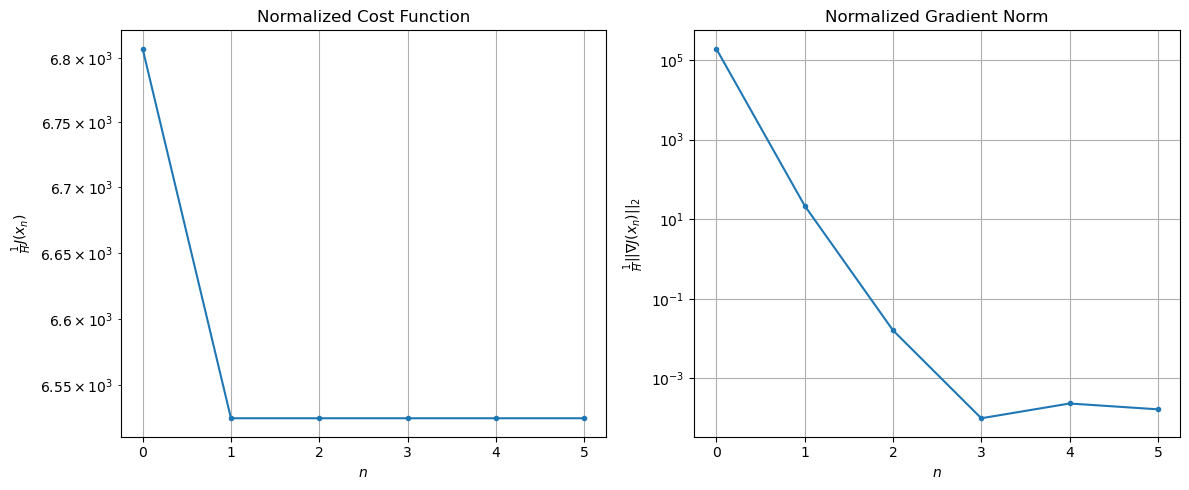

Before applying the algorithm
Cost function: 202210.3404137718
Gradient norm: 5510592.276463284
Global estimation error: 111.56836396814224
Initial conditions estimation errors: 16.91531592248775 m, 27.148783271624612 m, 33.02824515417632 m, 101.65350602559269 m
Position estimation errors: 23.568767495485442 m, 18.971609525795028 m, 35.07675166910477 m, 51.469684633980584 m

Iteration 1
Cost function: 193236.82352223614 (-4.44%)
Gradient norm: 6074.777178508689 (-99.89%)
Global estimation error: 62.87511886014411 (-43.64%)
Initial conditions estimation errors: 20.875061510341045 m, 25.342540082730252 m, 26.084415263001905 m, 46.849241694969436 m
Position estimation errors: 19.515056185312925 m, 14.825812186473257 m, 20.064837461902734 m, 18.262938166435756 m

Iteration 2
Cost function: 193236.5075080701 (-0.00%)
Gradient norm: 0.016964243666220315 (-100.00%)
Global estimation error: 62.76793628409384 (-0.17%)
Initial conditions estimation errors: 20.875062108290937 m, 25.33242977985704

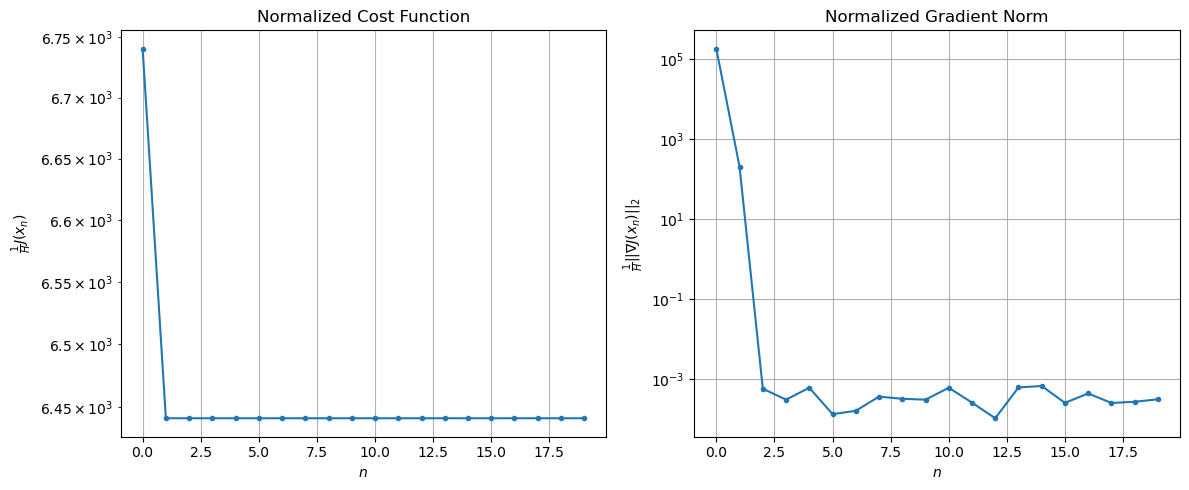

Before applying the algorithm
Cost function: 198449.36551748242
Gradient norm: 5492636.797994959
Global estimation error: 55.76159666936561
Initial conditions estimation errors: 17.066100513553074 m, 21.253746616237148 m, 22.657946822970466 m, 43.04622417017182 m
Position estimation errors: 23.328815350313043 m, 18.468201557165777 m, 23.434926858619203 m, 21.32825271069749 m

Iteration 1
Cost function: 189069.83899065523 (-4.73%)
Gradient norm: 760.4739283912156 (-99.99%)
Global estimation error: 40.100380002411946 (-28.09%)
Initial conditions estimation errors: 21.21159305719274 m, 21.123186000024457 m, 20.24169026079727 m, 17.38297079513357 m
Position estimation errors: 19.241829554675743 m, 16.397976507380637 m, 16.61173080572282 m, 13.230120526985175 m

Iteration 2
Cost function: 189069.82620781037 (-0.00%)
Gradient norm: 0.1851531714575066 (-99.98%)
Global estimation error: 39.96331901990034 (-0.34%)
Initial conditions estimation errors: 21.21159360784583 m, 21.092173877639418 m, 

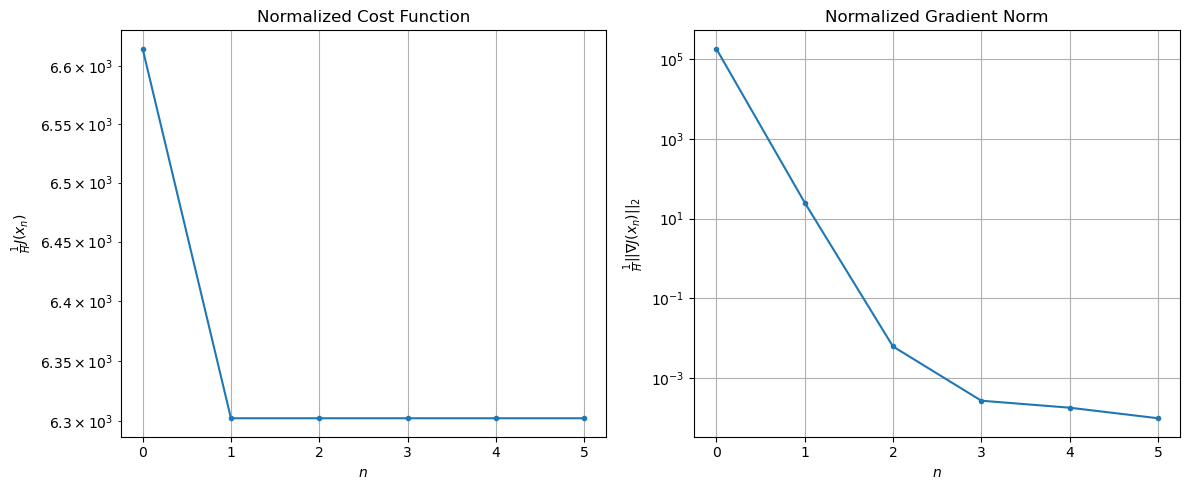

Before applying the algorithm
Cost function: 193019.92075136467
Gradient norm: 5412984.253359472
Global estimation error: 31.432094466106882
Initial conditions estimation errors: 16.953153223849192 m, 16.727144609151033 m, 15.781596952898212 m, 13.102848644745075 m
Position estimation errors: 23.02956200634887 m, 20.206037804408844 m, 20.40932157583445 m, 17.219932961044496 m

Iteration 1
Cost function: 183469.23270766146 (-4.95%)
Gradient norm: 10177.215183630504 (-99.81%)
Global estimation error: 78.89565227844122 (151.00%)
Initial conditions estimation errors: 21.197520501331077 m, 16.49646417152844 m, 15.747942854078431 m, 72.49143246571921 m
Position estimation errors: 18.93785725461632 m, 15.26298592790027 m, 12.737764491253913 m, 35.176827987421845 m

Iteration 2
Cost function: 183468.30950884396 (-0.00%)
Gradient norm: 2.3667492124864578 (-99.98%)
Global estimation error: 80.29460605318671 (1.77%)
Initial conditions estimation errors: 21.197520992143467 m, 16.417678880043034 m,

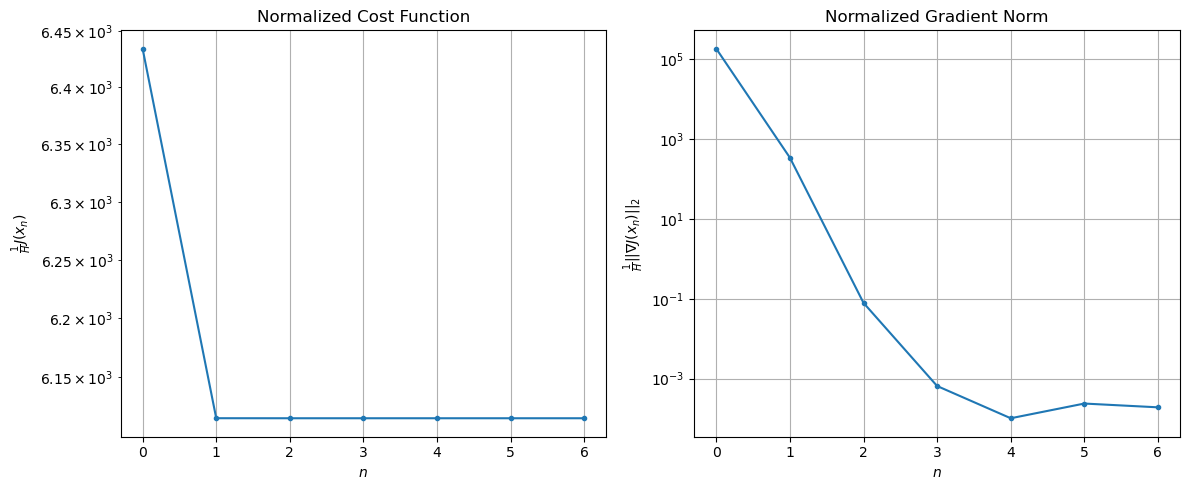

Before applying the algorithm
Cost function: 186344.59506968065
Gradient norm: 5223289.298511602
Global estimation error: 86.04663670998855
Initial conditions estimation errors: 16.66119552938409 m, 12.014258236537186 m, 13.922599725856326 m, 82.3905405884395 m
Position estimation errors: 22.69087806054163 m, 19.488480449228685 m, 15.686992868177308 m, 26.316602825992195 m

Iteration 1
Cost function: 176964.70259593078 (-5.03%)
Gradient norm: 11129.905584330214 (-99.79%)
Global estimation error: 39.135876271958196 (-54.52%)
Initial conditions estimation errors: 20.91978996297765 m, 19.760786796019676 m, 17.394084472259074 m, 20.022672949219352 m
Position estimation errors: 18.67315470809171 m, 17.966249068498566 m, 17.898157356057506 m, 26.09794613249203 m

Iteration 2
Cost function: 176963.80755921337 (-0.00%)
Gradient norm: 0.7036719051007269 (-99.99%)
Global estimation error: 39.21169264070295 (0.19%)
Initial conditions estimation errors: 20.919790428462257 m, 19.817728510476904 m, 

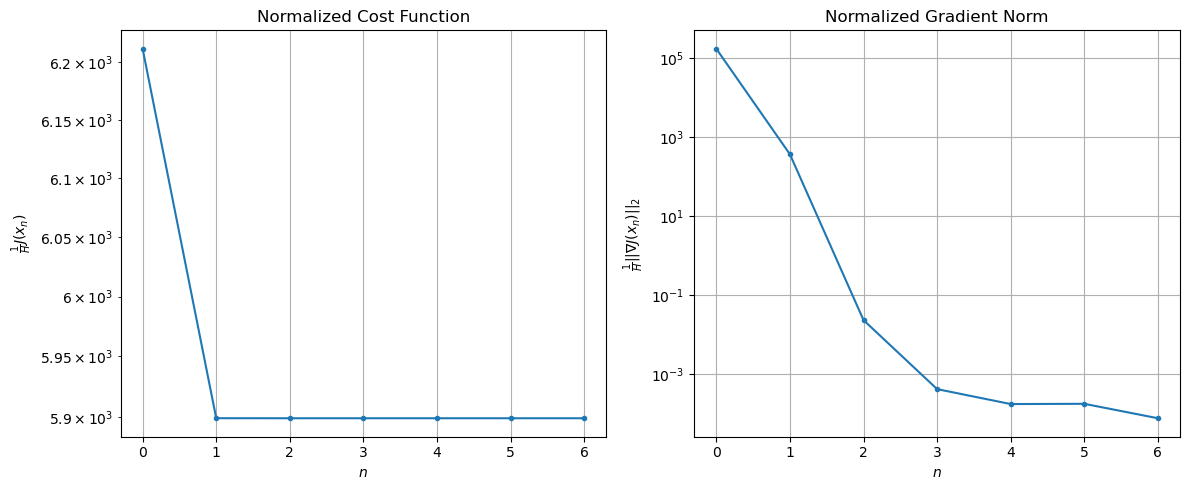

Before applying the algorithm
Cost function: 179603.8612186167
Gradient norm: 5131594.230033385
Global estimation error: 31.387900774485885
Initial conditions estimation errors: 16.318264299332142 m, 15.231743848848996 m, 13.001370925174479 m, 17.828308508593686 m
Position estimation errors: 22.39576307508116 m, 21.709131130781397 m, 21.877603776359784 m, 30.950549493507328 m

Iteration 1
Cost function: 170366.14669486586 (-5.14%)
Gradient norm: 642.2725413970934 (-99.99%)
Global estimation error: 36.3109202732514 (15.68%)
Initial conditions estimation errors: 20.573432081444288 m, 19.347870100341233 m, 16.938458471952348 m, 15.294942132091471 m
Position estimation errors: 18.429662254918846 m, 17.017526997382593 m, 16.798498113805987 m, 10.679372606814683 m

Iteration 2
Cost function: 170366.1455563546 (-0.00%)
Gradient norm: 0.06577860902334202 (-99.99%)
Global estimation error: 36.311456859859554 (0.00%)
Initial conditions estimation errors: 20.573432531799973 m, 19.34907028958618 m

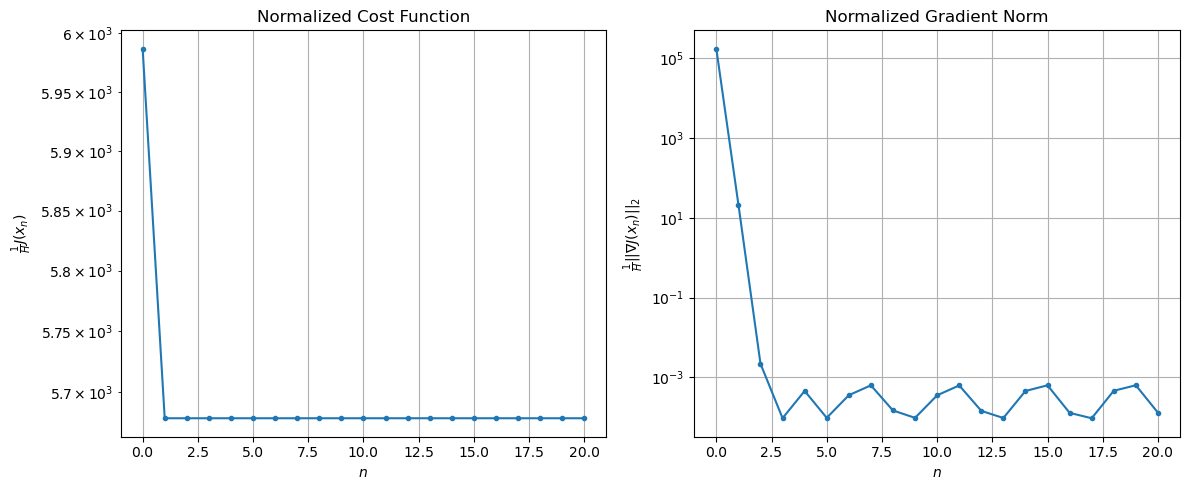

Before applying the algorithm
Cost function: 173685.83337984842
Gradient norm: 5106061.928113954
Global estimation error: 29.188293567108953
Initial conditions estimation errors: 16.09576071498359 m, 14.901008383320065 m, 12.319492397329183 m, 14.800300692857604 m
Position estimation errors: 22.130848965799032 m, 20.761659741282557 m, 20.824089991653473 m, 15.282424882785145 m

Iteration 1
Cost function: 164653.3697557865 (-5.20%)
Gradient norm: 4420.920065921493 (-99.91%)
Global estimation error: 40.738524901899424 (39.57%)
Initial conditions estimation errors: 20.311580229150543 m, 19.095290335183204 m, 18.419713614693705 m, 23.304715423013885 m
Position estimation errors: 18.218638166023766 m, 12.772500004358353 m, 11.679979667025334 m, 42.9263482782255 m

Iteration 2
Cost function: 164653.30448261893 (-0.00%)
Gradient norm: 1.146023806713504 (-99.97%)
Global estimation error: 40.61203490268029 (-0.31%)
Initial conditions estimation errors: 20.3115806755577 m, 19.09055736752465 m, 1

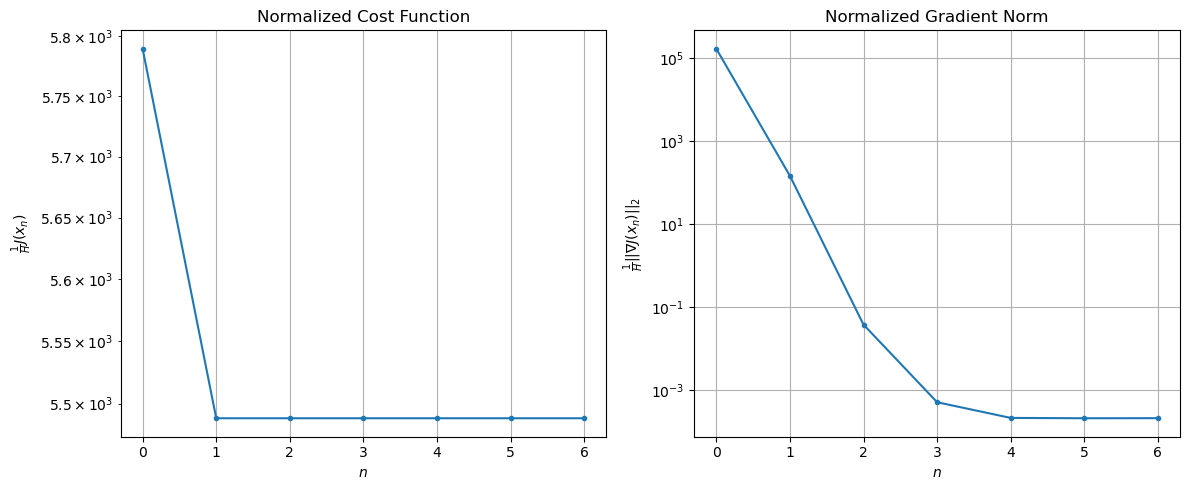

Before applying the algorithm
Cost function: 168661.08771010645
Gradient norm: 5123690.269912504
Global estimation error: 39.302402194245836
Initial conditions estimation errors: 16.058760896087662 m, 14.655787238658117 m, 14.236449547192562 m, 29.48377055269833 m
Position estimation errors: 21.90086414482094 m, 16.65576606421989 m, 16.153735245825768 m, 36.45218339409101 m

Iteration 1
Cost function: 159766.91708495544 (-5.27%)
Gradient norm: 6467.44122709907 (-99.87%)
Global estimation error: 36.17363415632968 (-7.96%)
Initial conditions estimation errors: 20.227886202848616 m, 18.514427501211113 m, 17.658144809470766 m, 15.64441459468437 m
Position estimation errors: 18.00512862547037 m, 18.976396180153625 m, 20.291011337442367 m, 18.83184316187477 m

Iteration 2
Cost function: 159766.7382381654 (-0.00%)
Gradient norm: 12.524261032630204 (-99.81%)
Global estimation error: 35.95014169113273 (-0.62%)
Initial conditions estimation errors: 20.227886658346314 m, 18.546378608955376 m, 17.

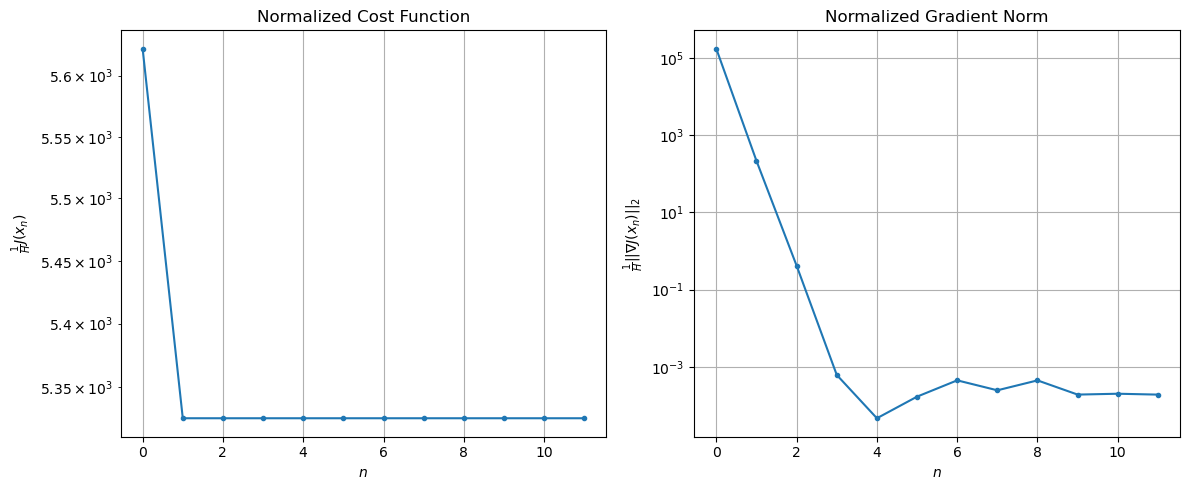

Before applying the algorithm
Cost function: 162537.1860493523
Gradient norm: 5023437.569895898
Global estimation error: 28.202035695643236
Initial conditions estimation errors: 16.196176853026085 m, 14.634061364670817 m, 13.69078780811203 m, 11.464138085503366 m
Position estimation errors: 21.652011944126798 m, 22.230092694689684 m, 23.528353464300324 m, 20.627731919082034 m

Iteration 1
Cost function: 153801.95470639886 (-5.37%)
Gradient norm: 2290.349662540127 (-99.95%)
Global estimation error: 41.165899409700344 (45.97%)
Initial conditions estimation errors: 20.33668850114331 m, 18.1920708532471 m, 19.182276181151636 m, 24.127139814939394 m
Position estimation errors: 17.80307185976754 m, 23.37308933293041 m, 24.050503957121418 m, 53.92256622314789 m

Iteration 2
Cost function: 153801.93915583452 (-0.00%)
Gradient norm: 0.1374561972288248 (-99.99%)
Global estimation error: 41.11421296730483 (-0.13%)
Initial conditions estimation errors: 20.336689006859096 m, 18.194313622963342 m, 1

MC run:   0%|          | 0/1 [25:18<?, ?it/s]


In [ ]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []
for m in tqdm(range(M), desc="MC run", leave=True):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    
    # Observations
    Y = np.zeros((o, 1, K))
    for k in range(K):
        Y[:, :, k] = h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

    # Cold-start
    x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
    
    # Apply the algorithm
    X_est = np.zeros((n, 1, K))
    for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
        centralized_gauss_newton = CentralizedGaussNewton()
        x_init, x_est = centralized_gauss_newton.solve(k, dt, Y, x_init, X_true[:, :, k - H + 1],  X_true[:, :, k])
        X_est[:, :, k] = x_est
        
        plots(centralized_gauss_newton)

        if k == 0: # Check divergence in the beginning
            position_estimation_error_init_1, position_estimation_error_init_2, position_estimation_error_init_3, position_estimation_error_init_4 = [], [], [], []
            x_est_tau = x_est
            for tau in range(H):
                position_estimation_error_init_1.append(np.linalg.norm(x_est_tau[:n_p, :] - X_true[:n_p, :, tau]))
                position_estimation_error_init_2.append(np.linalg.norm(x_est_tau[n_x:n_x + n_p, :] - X_true[n_x:n_x + n_p, :, tau]))
                position_estimation_error_init_3.append(np.linalg.norm(x_est_tau[2*n_x:2*n_x + n_p, :] - X_true[2*n_x:2*n_x + n_p, :, tau]))    
                position_estimation_error_init_4.append(np.linalg.norm(x_est_tau[3*n_x:3*n_x + n_p, :] - X_true[3*n_x:3*n_x + n_p, :, tau]))
                x_est_tau = f(dt, x_est_tau)
            rmse_init_1 = np.sqrt(np.mean(np.array(position_estimation_error_init_1) ** 2))
            rmse_init_2 = np.sqrt(np.mean(np.array(position_estimation_error_init_2) ** 2))
            rmse_init_3 = np.sqrt(np.mean(np.array(position_estimation_error_init_3) ** 2))
            rmse_init_4 = np.sqrt(np.mean(np.array(position_estimation_error_init_4) ** 2))
            if rmse_init_1 > invalid_rmse or rmse_init_2 > invalid_rmse or rmse_init_3 > invalid_rmse or rmse_init_4 > invalid_rmse:
                print(f"This Monte Carlo run #{m + 1} diverged!")
            else:
                first_round_stop_iteration.append(centralized_gauss_newton.iterations)
        else:
            K_minus_H_next_rounds_stop_iteration.append(centralized_gauss_newton.iterations)

        # Warm-start
        x_init = f(dt, x_init)

    # After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
    position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
    rmse_1, rmse_2, rmse_3, rmse_4 = [], [], [], []
    for k in range(H - 1, K):
        position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
        position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
        position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
        position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
    rmse_m_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
    rmse_m_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
    rmse_m_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
    rmse_m_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
    print(f'This MC run RMSE for the {K - H + 1} timestamps:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > invalid_rmse or rmse_m_2 > invalid_rmse or rmse_m_3 > invalid_rmse or rmse_m_4 > invalid_rmse:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the {K - H + 1} timestamps for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of CentralizedGaussNewton converged with {np.mean(first_round_stop_iteration)} iterations on average.')
print(f'The next {K - H} rounds of CentralizedGaussNewton converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

In [ ]:
import pandas as pd

k = H - 1
x_init = X_true[:, :, k - H + 1] + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

HJ_x = HJ(k, dt, Y, x_init)
print("Hessian matrix eigenvalues:", np.linalg.eigvalsh(HJ_x))
print("Hessian matrix condition number:", np.linalg.cond(HJ_x))
pd.DataFrame(HJ_x)

Hessian matrix eigenvalues: [4.51161064e-03 1.38653881e-01 5.71289787e-01 2.07201375e+00
 2.69085668e+00 2.98568413e+00 3.83433820e+00 7.02439971e+00
 9.23547340e+00 3.75799820e+02 4.36987232e+02 4.44159329e+02
 3.65005853e+03 1.47655312e+05 2.00473142e+05 4.58405498e+05
 1.16115300e+06 3.51489438e+06 5.86233414e+06 1.02636354e+07
 1.68077122e+07 3.04901934e+08 3.12342599e+08 5.25338400e+08]
Hessian matrix condition number: 116441431709.30745


0              1              2             3             4   \
0   2.642245e+03     -46.683427     347.822551  1.056450e+06 -2.480862e+04   
1  -4.668343e+01    1135.496726     -16.082524 -2.018565e+04  4.617098e+05   
2   3.478226e+02     -16.082524    1257.053684  1.514461e+05 -8.935554e+03   
3   1.056450e+06  -20185.650942  151446.122544  4.939446e+08 -9.993202e+06   
4  -2.480862e+04  461709.763881   -8935.553681 -9.993202e+06  3.055627e+08   
5   1.856176e+05   -8909.373925  527802.128158  7.474424e+07 -5.070491e+06   
6  -9.009794e+00       0.655629      -7.289387 -4.342619e+03  4.038864e+02   
7   6.555724e-01      -0.074451       0.912267  2.847573e+02 -3.176164e+01   
8  -7.288458e+00       0.912246     -11.358990 -3.060541e+03  3.624483e+02   
9  -4.342573e+03     284.785441   -3061.014188 -2.134257e+06  1.908389e+05   
10  4.038695e+02     -31.763289     362.481043  1.908315e+05 -1.876779e+04   
11 -4.574267e+03     378.732206   -4389.179472 -2.130746e+06  2.166634e+05   
12 -1.627875e+01      -4.078439       1.401024 -7.658902e+03 -2.617419e+03   
13 -4.079508e+00      -1.544012       1.706385 -1.666350e+03 -6.712449e+02   
14  1.403039e+00       1.706823      -4.137409  1.704047e+02  2.660370e+02   
15 -7.658869e+03   -1665.761699     169.326974 -3.788805e+06 -1.229209e+06   
16 -2.617773e+03    -671.127314     265.678194 -1.229409e+06 -4.253238e+05   
17  7.539335e+02     425.229941    -578.498589  2.096555e+05  1.307892e+05   
18 -1.747375e+01       5.155656       1.430387 -7.861602e+03  3.173493e+03   
19  5.157105e+00      -1.705757      -0.759337  2.128938e+03 -8.947154e+02   
20  1.432875e+00      -0.760067      -3.454312 -6.262252e+01 -4.700779e+01   
21 -7.861958e+03    2128.266990     -63.939393 -3.789113e+06  1.495277e+06   
22  3.174152e+03    -894.579310     -46.449888  1.495554e+06 -5.986846e+05   
23  4.076890e+02    -250.674276    -414.964876  3.319328e+04 -4.130576e+04   

              5             6            7            8             9   ...  \
0   1.856176e+05     -9.009794     0.655572    -7.288458 -4.342573e+03  ...   
1  -8.909374e+03      0.655629    -0.074451     0.912246  2.847854e+02  ...   
2   5.278021e+05     -7.289387     0.912267   -11.358990 -3.061014e+03  ...   
3   7.474424e+07  -4342.618520   284.757330 -3060.540853 -2.134257e+06  ...   
4  -5.070491e+06    403.886397   -31.761642   362.448318  1.908389e+05  ...   
5   3.429427e+08  -4574.569589   378.720714 -4388.886279 -2.130892e+06  ...   
6  -4.574570e+03     51.337279    -1.610387    11.233716  2.185083e+04  ...   
7   3.787207e+02     -1.610387     4.315142    -1.897190 -7.834107e+02  ...   
8  -4.388886e+03     11.233716    -1.897190    12.812176  5.042087e+03  ...   
9  -2.130892e+06  21850.831490  -783.410671  5042.086535  1.040612e+07  ...   
10  2.166687e+05  -1019.345842  1547.897750  -568.143097 -5.033378e+05  ...   
11 -2.530340e+06   6155.811320  -550.141707  4722.472060  3.029727e+06  ...   
12  7.533531e+02    -20.782090    -4.853976    -1.493567 -8.860349e+03  ...   
13  4.251325e+02     -4.855678    -2.226239     0.618094 -1.733386e+03  ...   
14 -5.785534e+02     -1.492044     0.618546    -0.971685 -8.877953e+02  ...   
15  2.093345e+05  -8860.808133 -1732.580200  -888.653053 -4.217532e+06  ...   
16  1.306910e+05  -2653.854267  -630.298130  -171.734636 -1.176167e+06  ...   
17 -1.642759e+05   -652.165466    -9.866784  -166.166753 -4.027221e+05  ...   
18  4.068616e+02    -21.540169     5.808328    -2.450769 -8.645232e+03  ...   
19 -2.504544e+02      5.810465    -2.014999     0.366897  2.232016e+03  ...   
20 -4.150059e+02     -2.449082     0.366215    -0.481426 -1.091587e+03  ...   
21  3.274517e+04  -8646.040547  2231.117398 -1092.587661 -4.053631e+06  ...   
22 -4.112189e+04   3269.289793  -886.014180   377.431908  1.488650e+06  ...   
23 -1.126924e+05   -927.504695   181.194518  -167.212092 -4.952768e+05  ...   

            14            15            16             17            18  \
0     1.4030

In [ ]:
for _ in range(100):
    k = H - 1
    x_init = X_true[:, :, k - H + 1] + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

    HJ_x = HJ(k, dt, Y, x_init)
    eigenvalues = np.linalg.eigvalsh(HJ_x)
    if np.min(np.linalg.eigvalsh(HJ_x)) < 0:
        print("Found a negative eigenvalue:")
        print(eigenvalues)

In [ ]:
HJ_x_chief = HJ_x[:n_x, :n_x]
HJ_x_deputy1 = HJ_x[n_x:2*n_x, n_x:2*n_x]
HJ_x_deputy2 = HJ_x[2*n_x:3*n_x, 2*n_x:3*n_x]
HJ_x_deputy3 = HJ_x[3*n_x:, 3*n_x:]
print(np.linalg.eigvalsh(HJ_x_chief))
print(np.linalg.eigvalsh(HJ_x_deputy1))
print(np.linalg.eigvalsh(HJ_x_deputy2))
print(np.linalg.eigvalsh(HJ_x_deputy3))

[3.77560020e+02 4.37665763e+02 4.45195229e+02 3.04941470e+08
 3.12088661e+08 5.25481311e+08]
[1.01667536e+00 4.93552424e+00 5.49321804e+00 8.04461882e+05
 1.14225553e+06 1.23308512e+07]
[2.32425995e+00 3.47828768e+00 4.52988768e+00 2.89014629e+05
 3.25370791e+06 8.54857628e+06]
[1.36225543e+00 2.67297352e+00 5.49918363e+00 2.44941508e+05
 1.68645285e+06 1.03464215e+07]


In [1]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

NameError: name 'plt' is not defined